In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation
from librosa.feature import chroma_stft
from librosa import load
import numpy as np
import os
import matplotlib.pyplot as plt
from utils import mirex_evaluate, ks_template, inv_key_map

In [37]:
data_dim = 12
timesteps = 12
num_classes = 24

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(Conv2D(6, (5, 5), padding='same', input_shape=(timesteps, data_dim, 1), activation='sigmoid')) #12
model.add(Conv2D(16, (5, 5), padding='valid', activation='sigmoid'))  #8
model.add(Conv2D(30, (5, 5), padding='valid', activation='sigmoid'))  #4
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 12, 12, 6)         156       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 16)          2416      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 30)          12030     
_________________________________________________________________
flatten_6 (Flatten)          (None, 480)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 480)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              492544    
_________________________________________________________________
dense_12 (Dense)             (None, 24)                24600     
Total para

In [22]:
sym2num = np.vectorize(inv_key_map.get)
evaluate_vec = np.vectorize(mirex_evaluate, otypes=[float])

train_set = [1, 3, 5, 11, 16, 19, 20, 22, 25, 26, 32]
val_set = [6, 13, 14, 21, 23, 31]
test_set = [8, 12, 18, 24, 27, 28]

data_dir = '/media/ycy/86A4D88BA4D87F5D/DataSet/BPS_piano'
ref_prefix = 'REF_key_'

In [23]:
train_data_list = []
train_target_list = []
val_data_list = []
val_target_list = []
test_data_list = []
test_target_list = []

file_names = [".".join(f.split(".")[:-1]) for f in os.listdir(data_dir) if f[-4:] == '.wav']

for f in file_names:
    label = np.loadtxt(os.path.join(data_dir, ref_prefix + f + '.txt'), dtype='str')
    t = sym2num(label[:, 1])
    t2 = np.zeros((len(t), num_classes))
    t2[(np.arange(len(t)), t)] = 1

    data, sr = load(os.path.join(data_dir, f + '.wav'), sr=None)
    hop_size = int(sr / timesteps)
    window_size = hop_size * 2

    chroma_a = chroma_stft(y=data, sr=sr, hop_length=hop_size, n_fft=window_size, base_c=False)
    if chroma_a.shape[1] > len(t) * timesteps:
        chroma_a = chroma_a[:, :len(t) * timesteps]
    elif chroma_a.shape[1] < len(t) * timesteps:
        chroma_a = np.column_stack((chroma_a, np.zeros((data_dim, len(t) * timesteps - chroma_a.shape[1]))))
    chroma_a = chroma_a.T.reshape(-1, timesteps, data_dim)
    
    if int(f) in train_set:
        train_data_list.append(chroma_a)
        train_target_list.append(t2)
    elif int(f) in val_set:
        val_data_list.append(chroma_a)
        val_target_list.append(t2)
    else:
        test_data_list.append(chroma_a)
        test_target_list.append(t2)
    
    print(f, chroma_a.shape, t2.shape)

print(len(train_data_list), len(val_data_list), len(test_data_list))

32 (836, 12, 12) (836, 24)


1 (800, 12, 12) (800, 24)


11 (1068, 12, 12) (1068, 24)


12 (365, 12, 12) (365, 24)


13 (390, 12, 12) (390, 24)


14 (276, 12, 12) (276, 24)


16 (872, 12, 12) (872, 24)


18 (1024, 12, 12) (1024, 24)


19 (290, 12, 12) (290, 24)


20 (996, 12, 12) (996, 24)


21 (1554, 12, 12) (1554, 24)


22 (555, 12, 12) (555, 24)


23 (1669, 12, 12) (1669, 24)


24 (816, 12, 12) (816, 24)


25 (1116, 12, 12) (1116, 24)


26 (1200, 12, 12) (1200, 24)


27 (735, 12, 12) (735, 24)


28 (306, 12, 12) (306, 24)


3 (1390, 12, 12) (1390, 24)


31 (348, 12, 12) (348, 24)


5 (1438, 12, 12) (1438, 24)


6 (808, 12, 12) (808, 24)


8 (1728, 12, 12) (1728, 24)
11 6 6


In [24]:
train_data = np.concatenate(train_data_list)
train_target = np.concatenate(train_target_list)
val_data = np.concatenate(val_data_list)
val_target = np.concatenate(val_target_list)
test_data = np.concatenate(test_data_list)
test_target = np.concatenate(test_target_list)

train_data = np.expand_dims(train_data, axis=3)
val_data = np.expand_dims(val_data, axis=3)
test_data = np.expand_dims(test_data, axis=3)
print(train_data.shape)

(10561, 12, 12, 1)


In [38]:
history = model.fit(train_data, train_target, batch_size=64, epochs=50, validation_data=(val_data, val_target))

Train on 10561 samples, validate on 5045 samples
Epoch 1/50


   64/10561 [..............................] - ETA: 1:00 - loss: 3.2343 - acc: 0.1406

  192/10561 [..............................] - ETA: 23s - loss: 3.4411 - acc: 0.1354 

  320/10561 [..............................] - ETA: 15s - loss: 3.2944 - acc: 0.1187

  448/10561 [>.............................] - ETA: 12s - loss: 3.1453 - acc: 0.1071

  576/10561 [>.............................] - ETA: 10s - loss: 3.0441 - acc: 0.1128

  704/10561 [>.............................] - ETA: 9s - loss: 2.9909 - acc: 0.1009 

  832/10561 [=>............................] - ETA: 8s - loss: 2.9459 - acc: 0.1010

  960/10561 [=>............................] - ETA: 7s - loss: 2.8853 - acc: 0.1042

 1152/10561 [==>...........................] - ETA: 6s - loss: 2.8475 - acc: 0.1050

 1344/10561 [==>...........................] - ETA: 6s - loss: 2.8171 - acc: 0.1101

 1536/10561 [===>..........................] - ETA: 5s - loss: 2.7913 - acc: 0.1146

 1728/10561 [===>..........................] - ETA: 5s - loss: 2.7854 - acc: 0.1209

 1920/10561 [====>.........................] - ETA: 4s - loss: 2.7740 - acc: 0.1187

 2112/10561 [====>.........................] - ETA: 4s - loss: 2.7551 - acc: 0.1179

 2304/10561 [=====>........................] - ETA: 4s - loss: 2.7440 - acc: 0.1176

 2496/10561 [======>.......................] - ETA: 4s - loss: 2.7436 - acc: 0.1154

 2688/10561 [======>.......................] - ETA: 3s - loss: 2.7366 - acc: 0.1205

 2880/10561 [=======>......................] - ETA: 3s - loss: 2.7339 - acc: 0.1208

 3072/10561 [=======>......................] - ETA: 3s - loss: 2.7203 - acc: 0.1250

 3264/10561 [========>.....................] - ETA: 3s - loss: 2.7140 - acc: 0.1238

 3520/10561 [========>.....................] - ETA: 3s - loss: 2.7054 - acc: 0.1261

 3712/10561 [=========>....................] - ETA: 2s - loss: 2.7005 - acc: 0.1277

 3968/10561 [==========>...................] - ETA: 2s - loss: 2.6946 - acc: 0.1288

 4160/10561 [==========>...................] - ETA: 2s - loss: 2.6988 - acc: 0.1255

 4352/10561 [===========>..................] - ETA: 2s - loss: 2.7007 - acc: 0.1255

 4544/10561 [===========>..................] - ETA: 2s - loss: 2.6992 - acc: 0.1254

 4736/10561 [============>.................] - ETA: 2s - loss: 2.6936 - acc: 0.1252

 4992/10561 [=============>................] - ETA: 2s - loss: 2.6915 - acc: 0.1270

 5184/10561 [=============>................] - ETA: 2s - loss: 2.6935 - acc: 0.1267

 5376/10561 [==============>...............] - ETA: 1s - loss: 2.6918 - acc: 0.1267

 5568/10561 [==============>...............] - ETA: 1s - loss: 2.6946 - acc: 0.1261

 5760/10561 [===============>..............] - ETA: 1s - loss: 2.6946 - acc: 0.1266

 5952/10561 [===============>..............] - ETA: 1s - loss: 2.6912 - acc: 0.1268

 6144/10561 [================>.............] - ETA: 1s - loss: 2.6915 - acc: 0.1268

 6336/10561 [================>.............] - ETA: 1s - loss: 2.6918 - acc: 0.1283

 6528/10561 [=================>............] - ETA: 1s - loss: 2.6902 - acc: 0.1297

 6720/10561 [==================>...........] - ETA: 1s - loss: 2.6871 - acc: 0.1314

 6912/10561 [==================>...........] - ETA: 1s - loss: 2.6868 - acc: 0.1330

 7104/10561 [===================>..........] - ETA: 1s - loss: 2.6838 - acc: 0.1322

 7296/10561 [===================>..........] - ETA: 1s - loss: 2.6843 - acc: 0.1319

 7488/10561 [====================>.........] - ETA: 1s - loss: 2.6841 - acc: 0.1322

 7680/10561 [====================>.........] - ETA: 1s - loss: 2.6839 - acc: 0.1332

 7872/10561 [=====================>........] - ETA: 0s - loss: 2.6854 - acc: 0.1319

 8064/10561 [=====================>........] - ETA: 0s - loss: 2.6847 - acc: 0.1313

 8320/10561 [======================>.......] - ETA: 0s - loss: 2.6852 - acc: 0.1311

 8512/10561 [=======================>......] - ETA: 0s - loss: 2.6855 - acc: 0.1312

 8704/10561 [=======================>......] - ETA: 0s - loss: 2.6874 - acc: 0.1310

 8896/10561 [========================>.....] - ETA: 0s - loss: 2.6874 - acc: 0.1310

 9088/10561 [========================>.....] - ETA: 0s - loss: 2.6873 - acc: 0.1305

 9280/10561 [=========================>....] - ETA: 0s - loss: 2.6852 - acc: 0.1308

 9472/10561 [=========================>....] - ETA: 0s - loss: 2.6843 - acc: 0.1308

 9664/10561 [==========================>...] - ETA: 0s - loss: 2.6849 - acc: 0.1301

 9856/10561 [==========================>...] - ETA: 0s - loss: 2.6838 - acc: 0.1307

10048/10561 [===========================>..] - ETA: 0s - loss: 2.6859 - acc: 0.1298

10240/10561 [============================>.] - ETA: 0s - loss: 2.6857 - acc: 0.1303

10432/10561 [============================>.] - ETA: 0s - loss: 2.6856 - acc: 0.1312

10561/10561 [==============================] - 4s 375us/step - loss: 2.6849 - acc: 0.1314 - val_loss: 4.2984 - val_acc: 0.0107


Epoch 2/50
   64/10561 [..............................] - ETA: 3s - loss: 3.0104 - acc: 0.0625

  256/10561 [..............................] - ETA: 3s - loss: 2.7824 - acc: 0.0742

  448/10561 [>.............................] - ETA: 3s - loss: 2.6992 - acc: 0.0893

  640/10561 [>.............................] - ETA: 2s - loss: 2.6852 - acc: 0.1094

  832/10561 [=>............................] - ETA: 2s - loss: 2.6722 - acc: 0.1238

 1088/10561 [==>...........................] - ETA: 2s - loss: 2.6757 - acc: 0.1278

 1280/10561 [==>...........................] - ETA: 2s - loss: 2.6669 - acc: 0.1352

 1472/10561 [===>..........................] - ETA: 2s - loss: 2.6670 - acc: 0.1420

 1664/10561 [===>..........................] - ETA: 2s - loss: 2.6701 - acc: 0.1418

 1856/10561 [====>.........................] - ETA: 2s - loss: 2.6798 - acc: 0.1390

 2048/10561 [====>.........................] - ETA: 2s - loss: 2.6840 - acc: 0.1357

 2304/10561 [=====>........................] - ETA: 2s - loss: 2.6736 - acc: 0.1359

 2496/10561 [======>.......................] - ETA: 2s - loss: 2.6829 - acc: 0.1334

 2688/10561 [======>.......................] - ETA: 2s - loss: 2.6738 - acc: 0.1354

 2880/10561 [=======>......................] - ETA: 2s - loss: 2.6725 - acc: 0.1392

 3072/10561 [=======>......................] - ETA: 2s - loss: 2.6736 - acc: 0.1390

 3264/10561 [========>.....................] - ETA: 2s - loss: 2.6688 - acc: 0.1382

 3456/10561 [========>.....................] - ETA: 2s - loss: 2.6669 - acc: 0.1380

 3648/10561 [=========>....................] - ETA: 1s - loss: 2.6684 - acc: 0.1354

 3840/10561 [=========>....................] - ETA: 1s - loss: 2.6653 - acc: 0.1346

 4032/10561 [==========>...................] - ETA: 1s - loss: 2.6678 - acc: 0.1332

 4224/10561 [==========>...................] - ETA: 1s - loss: 2.6667 - acc: 0.1330

 4416/10561 [===========>..................] - ETA: 1s - loss: 2.6618 - acc: 0.1336

 4608/10561 [============>.................] - ETA: 1s - loss: 2.6542 - acc: 0.1365

 4800/10561 [============>.................] - ETA: 1s - loss: 2.6520 - acc: 0.1360

 4992/10561 [=============>................] - ETA: 1s - loss: 2.6567 - acc: 0.1352

 5184/10561 [=============>................] - ETA: 1s - loss: 2.6571 - acc: 0.1337

 5376/10561 [==============>...............] - ETA: 1s - loss: 2.6592 - acc: 0.1349

 5568/10561 [==============>...............] - ETA: 1s - loss: 2.6601 - acc: 0.1338

 5760/10561 [===============>..............] - ETA: 1s - loss: 2.6621 - acc: 0.1335

 5952/10561 [===============>..............] - ETA: 1s - loss: 2.6582 - acc: 0.1352

 6144/10561 [================>.............] - ETA: 1s - loss: 2.6569 - acc: 0.1344

 6336/10561 [================>.............] - ETA: 1s - loss: 2.6579 - acc: 0.1343

 6528/10561 [=================>............] - ETA: 1s - loss: 2.6591 - acc: 0.1336

 6720/10561 [==================>...........] - ETA: 1s - loss: 2.6611 - acc: 0.1332

 6912/10561 [==================>...........] - ETA: 1s - loss: 2.6649 - acc: 0.1322

 7104/10561 [===================>..........] - ETA: 0s - loss: 2.6656 - acc: 0.1312

 7296/10561 [===================>..........] - ETA: 0s - loss: 2.6668 - acc: 0.1308

 7488/10561 [====================>.........] - ETA: 0s - loss: 2.6677 - acc: 0.1314

 7680/10561 [====================>.........] - ETA: 0s - loss: 2.6671 - acc: 0.1307

 7872/10561 [=====================>........] - ETA: 0s - loss: 2.6687 - acc: 0.1301

 8064/10561 [=====================>........] - ETA: 0s - loss: 2.6679 - acc: 0.1296

 8256/10561 [======================>.......] - ETA: 0s - loss: 2.6699 - acc: 0.1288

 8448/10561 [======================>.......] - ETA: 0s - loss: 2.6687 - acc: 0.1288

 8640/10561 [=======================>......] - ETA: 0s - loss: 2.6685 - acc: 0.1289

 8832/10561 [========================>.....] - ETA: 0s - loss: 2.6671 - acc: 0.1294

 9024/10561 [========================>.....] - ETA: 0s - loss: 2.6673 - acc: 0.1285

 9216/10561 [=========================>....] - ETA: 0s - loss: 2.6668 - acc: 0.1289

 9408/10561 [=========================>....] - ETA: 0s - loss: 2.6652 - acc: 0.1299

 9600/10561 [==========================>...] - ETA: 0s - loss: 2.6646 - acc: 0.1293

 9792/10561 [==========================>...] - ETA: 0s - loss: 2.6656 - acc: 0.1289

 9984/10561 [===========================>..] - ETA: 0s - loss: 2.6642 - acc: 0.1292

10176/10561 [===========================>..] - ETA: 0s - loss: 2.6631 - acc: 0.1296

10368/10561 [============================>.] - ETA: 0s - loss: 2.6638 - acc: 0.1295

10560/10561 [============================>.] - ETA: 0s - loss: 2.6652 - acc: 0.1292

10561/10561 [==============================] - 3s 321us/step - loss: 2.6651 - acc: 0.1292 - val_loss: 4.3446 - val_acc: 0.0727


Epoch 3/50
   64/10561 [..............................] - ETA: 3s - loss: 2.9239 - acc: 0.1406

  256/10561 [..............................] - ETA: 2s - loss: 2.6987 - acc: 0.1250

  448/10561 [>.............................] - ETA: 2s - loss: 2.7234 - acc: 0.1094

  704/10561 [>.............................] - ETA: 2s - loss: 2.6937 - acc: 0.1108

  896/10561 [=>............................] - ETA: 2s - loss: 2.6757 - acc: 0.1250

 1088/10561 [==>...........................] - ETA: 2s - loss: 2.6574 - acc: 0.1333

 1280/10561 [==>...........................] - ETA: 2s - loss: 2.6476 - acc: 0.1313

 1472/10561 [===>..........................] - ETA: 2s - loss: 2.6523 - acc: 0.1304

 1664/10561 [===>..........................] - ETA: 2s - loss: 2.6481 - acc: 0.1298

 1856/10561 [====>.........................] - ETA: 2s - loss: 2.6521 - acc: 0.1266

 2048/10561 [====>.........................] - ETA: 2s - loss: 2.6586 - acc: 0.1270

 2240/10561 [=====>........................] - ETA: 2s - loss: 2.6592 - acc: 0.1268

 2432/10561 [=====>........................] - ETA: 2s - loss: 2.6506 - acc: 0.1303

 2624/10561 [======>.......................] - ETA: 2s - loss: 2.6563 - acc: 0.1284

 2816/10561 [======>.......................] - ETA: 2s - loss: 2.6574 - acc: 0.1275

 3008/10561 [=======>......................] - ETA: 2s - loss: 2.6653 - acc: 0.1257

 3264/10561 [========>.....................] - ETA: 2s - loss: 2.6674 - acc: 0.1229

 3456/10561 [========>.....................] - ETA: 1s - loss: 2.6630 - acc: 0.1250

 3712/10561 [=========>....................] - ETA: 1s - loss: 2.6576 - acc: 0.1266

 3904/10561 [==========>...................] - ETA: 1s - loss: 2.6581 - acc: 0.1283

 4096/10561 [==========>...................] - ETA: 1s - loss: 2.6588 - acc: 0.1292

 4288/10561 [===========>..................] - ETA: 1s - loss: 2.6627 - acc: 0.1269

 4480/10561 [===========>..................] - ETA: 1s - loss: 2.6600 - acc: 0.1283

 4736/10561 [============>.................] - ETA: 1s - loss: 2.6570 - acc: 0.1299

 4992/10561 [=============>................] - ETA: 1s - loss: 2.6576 - acc: 0.1288

 5184/10561 [=============>................] - ETA: 1s - loss: 2.6620 - acc: 0.1273

 5376/10561 [==============>...............] - ETA: 1s - loss: 2.6650 - acc: 0.1269

 5568/10561 [==============>...............] - ETA: 1s - loss: 2.6641 - acc: 0.1268

 5760/10561 [===============>..............] - ETA: 1s - loss: 2.6662 - acc: 0.1266

 5952/10561 [===============>..............] - ETA: 1s - loss: 2.6691 - acc: 0.1252

 6144/10561 [================>.............] - ETA: 1s - loss: 2.6702 - acc: 0.1250

 6336/10561 [================>.............] - ETA: 1s - loss: 2.6690 - acc: 0.1261

 6592/10561 [=================>............] - ETA: 1s - loss: 2.6673 - acc: 0.1268

 6784/10561 [==================>...........] - ETA: 1s - loss: 2.6667 - acc: 0.1268

 6976/10561 [==================>...........] - ETA: 0s - loss: 2.6669 - acc: 0.1273

 7168/10561 [===================>..........] - ETA: 0s - loss: 2.6704 - acc: 0.1270

 7360/10561 [===================>..........] - ETA: 0s - loss: 2.6699 - acc: 0.1276

 7552/10561 [====================>.........] - ETA: 0s - loss: 2.6707 - acc: 0.1273

 7744/10561 [====================>.........] - ETA: 0s - loss: 2.6671 - acc: 0.1273

 8000/10561 [=====================>........] - ETA: 0s - loss: 2.6654 - acc: 0.1276

 8192/10561 [======================>.......] - ETA: 0s - loss: 2.6686 - acc: 0.1278

 8448/10561 [======================>.......] - ETA: 0s - loss: 2.6689 - acc: 0.1289

 8640/10561 [=======================>......] - ETA: 0s - loss: 2.6690 - acc: 0.1281

 8832/10561 [========================>.....] - ETA: 0s - loss: 2.6698 - acc: 0.1284

 9024/10561 [========================>.....] - ETA: 0s - loss: 2.6698 - acc: 0.1274

 9216/10561 [=========================>....] - ETA: 0s - loss: 2.6696 - acc: 0.1267

 9472/10561 [=========================>....] - ETA: 0s - loss: 2.6685 - acc: 0.1275

 9664/10561 [==========================>...] - ETA: 0s - loss: 2.6676 - acc: 0.1287

 9856/10561 [==========================>...] - ETA: 0s - loss: 2.6685 - acc: 0.1288

10048/10561 [===========================>..] - ETA: 0s - loss: 2.6674 - acc: 0.1296

10240/10561 [============================>.] - ETA: 0s - loss: 2.6670 - acc: 0.1292

10432/10561 [============================>.] - ETA: 0s - loss: 2.6667 - acc: 0.1297

10561/10561 [==============================] - 3s 312us/step - loss: 2.6675 - acc: 0.1297 - val_loss: 4.0051 - val_acc: 0.1843


Epoch 4/50
   64/10561 [..............................] - ETA: 3s - loss: 2.9039 - acc: 0.0938

  256/10561 [..............................] - ETA: 2s - loss: 2.7932 - acc: 0.0859

  448/10561 [>.............................] - ETA: 2s - loss: 2.7586 - acc: 0.1094

  640/10561 [>.............................] - ETA: 2s - loss: 2.7117 - acc: 0.1281

  832/10561 [=>............................] - ETA: 2s - loss: 2.6929 - acc: 0.1274

 1024/10561 [=>............................] - ETA: 2s - loss: 2.6855 - acc: 0.1338

 1216/10561 [==>...........................] - ETA: 2s - loss: 2.6692 - acc: 0.1357

 1408/10561 [==>...........................] - ETA: 2s - loss: 2.6698 - acc: 0.1371

 1600/10561 [===>..........................] - ETA: 2s - loss: 2.6767 - acc: 0.1394

 1792/10561 [====>.........................] - ETA: 2s - loss: 2.6763 - acc: 0.1406

 1984/10561 [====>.........................] - ETA: 2s - loss: 2.6814 - acc: 0.1376

 2240/10561 [=====>........................] - ETA: 2s - loss: 2.6718 - acc: 0.1406

 2496/10561 [======>.......................] - ETA: 2s - loss: 2.6691 - acc: 0.1422

 2688/10561 [======>.......................] - ETA: 2s - loss: 2.6632 - acc: 0.1403

 2944/10561 [=======>......................] - ETA: 2s - loss: 2.6694 - acc: 0.1420

 3136/10561 [=======>......................] - ETA: 2s - loss: 2.6710 - acc: 0.1393

 3328/10561 [========>.....................] - ETA: 2s - loss: 2.6684 - acc: 0.1373

 3520/10561 [========>.....................] - ETA: 1s - loss: 2.6676 - acc: 0.1361

 3712/10561 [=========>....................] - ETA: 1s - loss: 2.6617 - acc: 0.1352

 3904/10561 [==========>...................] - ETA: 1s - loss: 2.6661 - acc: 0.1347

 4096/10561 [==========>...................] - ETA: 1s - loss: 2.6729 - acc: 0.1338

 4288/10561 [===========>..................] - ETA: 1s - loss: 2.6714 - acc: 0.1327

 4480/10561 [===========>..................] - ETA: 1s - loss: 2.6704 - acc: 0.1330

 4736/10561 [============>.................] - ETA: 1s - loss: 2.6667 - acc: 0.1339

 4928/10561 [============>.................] - ETA: 1s - loss: 2.6697 - acc: 0.1343

 5120/10561 [=============>................] - ETA: 1s - loss: 2.6705 - acc: 0.1354

 5312/10561 [==============>...............] - ETA: 1s - loss: 2.6696 - acc: 0.1344

 5504/10561 [==============>...............] - ETA: 1s - loss: 2.6733 - acc: 0.1326

 5696/10561 [===============>..............] - ETA: 1s - loss: 2.6725 - acc: 0.1334

 5888/10561 [===============>..............] - ETA: 1s - loss: 2.6730 - acc: 0.1326

 6080/10561 [================>.............] - ETA: 1s - loss: 2.6733 - acc: 0.1316

 6272/10561 [================>.............] - ETA: 1s - loss: 2.6740 - acc: 0.1298

 6464/10561 [=================>............] - ETA: 1s - loss: 2.6747 - acc: 0.1296

 6656/10561 [=================>............] - ETA: 1s - loss: 2.6758 - acc: 0.1313

 6848/10561 [==================>...........] - ETA: 1s - loss: 2.6750 - acc: 0.1300

 7040/10561 [==================>...........] - ETA: 0s - loss: 2.6768 - acc: 0.1295

 7232/10561 [===================>..........] - ETA: 0s - loss: 2.6747 - acc: 0.1312

 7424/10561 [====================>.........] - ETA: 0s - loss: 2.6745 - acc: 0.1309

 7616/10561 [====================>.........] - ETA: 0s - loss: 2.6729 - acc: 0.1314

 7808/10561 [=====================>........] - ETA: 0s - loss: 2.6737 - acc: 0.1328

 8000/10561 [=====================>........] - ETA: 0s - loss: 2.6744 - acc: 0.1323

 8192/10561 [======================>.......] - ETA: 0s - loss: 2.6756 - acc: 0.1322

 8384/10561 [======================>.......] - ETA: 0s - loss: 2.6746 - acc: 0.1323

 8576/10561 [=======================>......] - ETA: 0s - loss: 2.6728 - acc: 0.1330

 8768/10561 [=======================>......] - ETA: 0s - loss: 2.6736 - acc: 0.1328

 8960/10561 [========================>.....] - ETA: 0s - loss: 2.6708 - acc: 0.1321

 9152/10561 [========================>.....] - ETA: 0s - loss: 2.6714 - acc: 0.1319

 9344/10561 [=========================>....] - ETA: 0s - loss: 2.6716 - acc: 0.1307

 9536/10561 [==========================>...] - ETA: 0s - loss: 2.6704 - acc: 0.1309

 9728/10561 [==========================>...] - ETA: 0s - loss: 2.6712 - acc: 0.1310

 9920/10561 [===========================>..] - ETA: 0s - loss: 2.6691 - acc: 0.1305

10112/10561 [===========================>..] - ETA: 0s - loss: 2.6676 - acc: 0.1307

10304/10561 [============================>.] - ETA: 0s - loss: 2.6673 - acc: 0.1308

10496/10561 [============================>.] - ETA: 0s - loss: 2.6680 - acc: 0.1305

10561/10561 [==============================] - 3s 324us/step - loss: 2.6673 - acc: 0.1308 - val_loss: 4.1526 - val_acc: 0.0727


Epoch 5/50
   64/10561 [..............................] - ETA: 3s - loss: 2.8156 - acc: 0.0625

  256/10561 [..............................] - ETA: 3s - loss: 2.7284 - acc: 0.0781

  448/10561 [>.............................] - ETA: 2s - loss: 2.7170 - acc: 0.1138

  704/10561 [>.............................] - ETA: 2s - loss: 2.7292 - acc: 0.1165

  896/10561 [=>............................] - ETA: 2s - loss: 2.7072 - acc: 0.1239

 1088/10561 [==>...........................] - ETA: 2s - loss: 2.7144 - acc: 0.1250

 1280/10561 [==>...........................] - ETA: 2s - loss: 2.6911 - acc: 0.1328

 1472/10561 [===>..........................] - ETA: 2s - loss: 2.6869 - acc: 0.1332

 1664/10561 [===>..........................] - ETA: 2s - loss: 2.6729 - acc: 0.1328

 1856/10561 [====>.........................] - ETA: 2s - loss: 2.6725 - acc: 0.1315

 2048/10561 [====>.........................] - ETA: 2s - loss: 2.6746 - acc: 0.1333

 2240/10561 [=====>........................] - ETA: 2s - loss: 2.6668 - acc: 0.1335

 2432/10561 [=====>........................] - ETA: 2s - loss: 2.6683 - acc: 0.1324

 2624/10561 [======>.......................] - ETA: 2s - loss: 2.6631 - acc: 0.1334

 2816/10561 [======>.......................] - ETA: 2s - loss: 2.6554 - acc: 0.1342

 3008/10561 [=======>......................] - ETA: 2s - loss: 2.6503 - acc: 0.1360

 3200/10561 [========>.....................] - ETA: 2s - loss: 2.6555 - acc: 0.1338

 3392/10561 [========>.....................] - ETA: 2s - loss: 2.6523 - acc: 0.1341

 3584/10561 [=========>....................] - ETA: 2s - loss: 2.6565 - acc: 0.1350

 3776/10561 [=========>....................] - ETA: 1s - loss: 2.6575 - acc: 0.1353

 3968/10561 [==========>...................] - ETA: 1s - loss: 2.6568 - acc: 0.1338

 4160/10561 [==========>...................] - ETA: 1s - loss: 2.6588 - acc: 0.1353

 4352/10561 [===========>..................] - ETA: 1s - loss: 2.6553 - acc: 0.1356

 4544/10561 [===========>..................] - ETA: 1s - loss: 2.6541 - acc: 0.1336

 4736/10561 [============>.................] - ETA: 1s - loss: 2.6520 - acc: 0.1351

 4928/10561 [============>.................] - ETA: 1s - loss: 2.6531 - acc: 0.1351

 5120/10561 [=============>................] - ETA: 1s - loss: 2.6496 - acc: 0.1361

 5312/10561 [==============>...............] - ETA: 1s - loss: 2.6479 - acc: 0.1365

 5504/10561 [==============>...............] - ETA: 1s - loss: 2.6458 - acc: 0.1357

 5696/10561 [===============>..............] - ETA: 1s - loss: 2.6459 - acc: 0.1345

 5888/10561 [===============>..............] - ETA: 1s - loss: 2.6481 - acc: 0.1345

 6080/10561 [================>.............] - ETA: 1s - loss: 2.6478 - acc: 0.1347

 6272/10561 [================>.............] - ETA: 1s - loss: 2.6465 - acc: 0.1355

 6464/10561 [=================>............] - ETA: 1s - loss: 2.6454 - acc: 0.1357

 6656/10561 [=================>............] - ETA: 1s - loss: 2.6451 - acc: 0.1349

 6848/10561 [==================>...........] - ETA: 1s - loss: 2.6448 - acc: 0.1360

 7040/10561 [==================>...........] - ETA: 1s - loss: 2.6450 - acc: 0.1361

 7232/10561 [===================>..........] - ETA: 0s - loss: 2.6422 - acc: 0.1361

 7424/10561 [====================>.........] - ETA: 0s - loss: 2.6456 - acc: 0.1344

 7616/10561 [====================>.........] - ETA: 0s - loss: 2.6454 - acc: 0.1350

 7808/10561 [=====================>........] - ETA: 0s - loss: 2.6431 - acc: 0.1349

 8000/10561 [=====================>........] - ETA: 0s - loss: 2.6391 - acc: 0.1363

 8192/10561 [======================>.......] - ETA: 0s - loss: 2.6387 - acc: 0.1368

 8384/10561 [======================>.......] - ETA: 0s - loss: 2.6398 - acc: 0.1372

 8576/10561 [=======================>......] - ETA: 0s - loss: 2.6391 - acc: 0.1376

 8768/10561 [=======================>......] - ETA: 0s - loss: 2.6404 - acc: 0.1379

 8960/10561 [========================>.....] - ETA: 0s - loss: 2.6396 - acc: 0.1378

 9152/10561 [========================>.....] - ETA: 0s - loss: 2.6386 - acc: 0.1379

 9344/10561 [=========================>....] - ETA: 0s - loss: 2.6388 - acc: 0.1385

 9536/10561 [==========================>...] - ETA: 0s - loss: 2.6388 - acc: 0.1391

 9728/10561 [==========================>...] - ETA: 0s - loss: 2.6379 - acc: 0.1387

 9920/10561 [===========================>..] - ETA: 0s - loss: 2.6366 - acc: 0.1389

10112/10561 [===========================>..] - ETA: 0s - loss: 2.6370 - acc: 0.1377

10304/10561 [============================>.] - ETA: 0s - loss: 2.6371 - acc: 0.1379

10496/10561 [============================>.] - ETA: 0s - loss: 2.6377 - acc: 0.1379

10561/10561 [==============================] - 3s 327us/step - loss: 2.6375 - acc: 0.1378 - val_loss: 4.0675 - val_acc: 0.0456


Epoch 6/50
   64/10561 [..............................] - ETA: 3s - loss: 2.7760 - acc: 0.1562

  256/10561 [..............................] - ETA: 3s - loss: 2.6426 - acc: 0.1328

  512/10561 [>.............................] - ETA: 2s - loss: 2.6239 - acc: 0.1504

  704/10561 [>.............................] - ETA: 2s - loss: 2.6190 - acc: 0.1463

  896/10561 [=>............................] - ETA: 2s - loss: 2.6119 - acc: 0.1395

 1088/10561 [==>...........................] - ETA: 2s - loss: 2.6113 - acc: 0.1342

 1280/10561 [==>...........................] - ETA: 2s - loss: 2.6002 - acc: 0.1383

 1472/10561 [===>..........................] - ETA: 2s - loss: 2.6001 - acc: 0.1413

 1664/10561 [===>..........................] - ETA: 2s - loss: 2.6041 - acc: 0.1418

 1856/10561 [====>.........................] - ETA: 2s - loss: 2.5985 - acc: 0.1460

 2048/10561 [====>.........................] - ETA: 2s - loss: 2.5926 - acc: 0.1470

 2240/10561 [=====>........................] - ETA: 2s - loss: 2.5991 - acc: 0.1482

 2432/10561 [=====>........................] - ETA: 2s - loss: 2.5974 - acc: 0.1439

 2624/10561 [======>.......................] - ETA: 2s - loss: 2.5919 - acc: 0.1429

 2816/10561 [======>.......................] - ETA: 2s - loss: 2.5984 - acc: 0.1392

 3008/10561 [=======>......................] - ETA: 2s - loss: 2.6006 - acc: 0.1406

 3200/10561 [========>.....................] - ETA: 2s - loss: 2.5959 - acc: 0.1406

 3392/10561 [========>.....................] - ETA: 2s - loss: 2.6002 - acc: 0.1403

 3584/10561 [=========>....................] - ETA: 1s - loss: 2.6007 - acc: 0.1395

 3776/10561 [=========>....................] - ETA: 1s - loss: 2.6041 - acc: 0.1390

 4032/10561 [==========>...................] - ETA: 1s - loss: 2.6043 - acc: 0.1396

 4224/10561 [==========>...................] - ETA: 1s - loss: 2.6031 - acc: 0.1409

 4416/10561 [===========>..................] - ETA: 1s - loss: 2.6051 - acc: 0.1399

 4608/10561 [============>.................] - ETA: 1s - loss: 2.6010 - acc: 0.1413

 4800/10561 [============>.................] - ETA: 1s - loss: 2.5994 - acc: 0.1412

 4992/10561 [=============>................] - ETA: 1s - loss: 2.6027 - acc: 0.1404

 5248/10561 [=============>................] - ETA: 1s - loss: 2.6088 - acc: 0.1389

 5440/10561 [==============>...............] - ETA: 1s - loss: 2.6100 - acc: 0.1384

 5632/10561 [==============>...............] - ETA: 1s - loss: 2.6116 - acc: 0.1367

 5888/10561 [===============>..............] - ETA: 1s - loss: 2.6149 - acc: 0.1371

 6080/10561 [================>.............] - ETA: 1s - loss: 2.6165 - acc: 0.1375

 6272/10561 [================>.............] - ETA: 1s - loss: 2.6157 - acc: 0.1368

 6464/10561 [=================>............] - ETA: 1s - loss: 2.6164 - acc: 0.1368

 6656/10561 [=================>............] - ETA: 1s - loss: 2.6152 - acc: 0.1367

 6848/10561 [==================>...........] - ETA: 1s - loss: 2.6138 - acc: 0.1364

 7040/10561 [==================>...........] - ETA: 0s - loss: 2.6101 - acc: 0.1374

 7232/10561 [===================>..........] - ETA: 0s - loss: 2.6102 - acc: 0.1369

 7424/10561 [====================>.........] - ETA: 0s - loss: 2.6093 - acc: 0.1367

 7616/10561 [====================>.........] - ETA: 0s - loss: 2.6100 - acc: 0.1366

 7808/10561 [=====================>........] - ETA: 0s - loss: 2.6095 - acc: 0.1369

 8000/10561 [=====================>........] - ETA: 0s - loss: 2.6094 - acc: 0.1379

 8192/10561 [======================>.......] - ETA: 0s - loss: 2.6099 - acc: 0.1383

 8384/10561 [======================>.......] - ETA: 0s - loss: 2.6110 - acc: 0.1384

 8576/10561 [=======================>......] - ETA: 0s - loss: 2.6104 - acc: 0.1390

 8768/10561 [=======================>......] - ETA: 0s - loss: 2.6101 - acc: 0.1391

 8960/10561 [========================>.....] - ETA: 0s - loss: 2.6100 - acc: 0.1400

 9152/10561 [========================>.....] - ETA: 0s - loss: 2.6092 - acc: 0.1393

 9344/10561 [=========================>....] - ETA: 0s - loss: 2.6081 - acc: 0.1390

 9536/10561 [==========================>...] - ETA: 0s - loss: 2.6106 - acc: 0.1387

 9728/10561 [==========================>...] - ETA: 0s - loss: 2.6114 - acc: 0.1386

 9920/10561 [===========================>..] - ETA: 0s - loss: 2.6093 - acc: 0.1395

10112/10561 [===========================>..] - ETA: 0s - loss: 2.6086 - acc: 0.1392

10304/10561 [============================>.] - ETA: 0s - loss: 2.6070 - acc: 0.1397

10496/10561 [============================>.] - ETA: 0s - loss: 2.6050 - acc: 0.1404

10561/10561 [==============================] - 3s 323us/step - loss: 2.6042 - acc: 0.1405 - val_loss: 4.0175 - val_acc: 0.0228


Epoch 7/50
   64/10561 [..............................] - ETA: 3s - loss: 2.6832 - acc: 0.1250

  256/10561 [..............................] - ETA: 3s - loss: 2.7082 - acc: 0.1484

  448/10561 [>.............................] - ETA: 2s - loss: 2.6086 - acc: 0.1562

  640/10561 [>.............................] - ETA: 2s - loss: 2.6056 - acc: 0.1469

  832/10561 [=>............................] - ETA: 2s - loss: 2.5775 - acc: 0.1599

 1024/10561 [=>............................] - ETA: 2s - loss: 2.5754 - acc: 0.1523

 1216/10561 [==>...........................] - ETA: 2s - loss: 2.5864 - acc: 0.1439

 1408/10561 [==>...........................] - ETA: 2s - loss: 2.5954 - acc: 0.1378

 1600/10561 [===>..........................] - ETA: 2s - loss: 2.5936 - acc: 0.1319

 1792/10561 [====>.........................] - ETA: 2s - loss: 2.5926 - acc: 0.1323

 1984/10561 [====>.........................] - ETA: 2s - loss: 2.5946 - acc: 0.1351

 2176/10561 [=====>........................] - ETA: 2s - loss: 2.5952 - acc: 0.1388

 2368/10561 [=====>........................] - ETA: 2s - loss: 2.5916 - acc: 0.1389

 2560/10561 [======>.......................] - ETA: 2s - loss: 2.5944 - acc: 0.1406

 2752/10561 [======>.......................] - ETA: 2s - loss: 2.5938 - acc: 0.1421

 2944/10561 [=======>......................] - ETA: 2s - loss: 2.5903 - acc: 0.1430

 3136/10561 [=======>......................] - ETA: 2s - loss: 2.5900 - acc: 0.1445

 3328/10561 [========>.....................] - ETA: 2s - loss: 2.5905 - acc: 0.1445

 3520/10561 [========>.....................] - ETA: 2s - loss: 2.5924 - acc: 0.1426

 3712/10561 [=========>....................] - ETA: 1s - loss: 2.5936 - acc: 0.1433

 3904/10561 [==========>...................] - ETA: 1s - loss: 2.5914 - acc: 0.1437

 4096/10561 [==========>...................] - ETA: 1s - loss: 2.5975 - acc: 0.1426

 4288/10561 [===========>..................] - ETA: 1s - loss: 2.6000 - acc: 0.1430

 4480/10561 [===========>..................] - ETA: 1s - loss: 2.6034 - acc: 0.1431

 4672/10561 [============>.................] - ETA: 1s - loss: 2.6023 - acc: 0.1434

 4864/10561 [============>.................] - ETA: 1s - loss: 2.5997 - acc: 0.1437

 5056/10561 [=============>................] - ETA: 1s - loss: 2.6035 - acc: 0.1438

 5248/10561 [=============>................] - ETA: 1s - loss: 2.6066 - acc: 0.1452

 5440/10561 [==============>...............] - ETA: 1s - loss: 2.6063 - acc: 0.1441

 5632/10561 [==============>...............] - ETA: 1s - loss: 2.6019 - acc: 0.1461

 5824/10561 [===============>..............] - ETA: 1s - loss: 2.6013 - acc: 0.1468

 6016/10561 [================>.............] - ETA: 1s - loss: 2.6007 - acc: 0.1476

 6208/10561 [================>.............] - ETA: 1s - loss: 2.5966 - acc: 0.1482

 6400/10561 [=================>............] - ETA: 1s - loss: 2.5953 - acc: 0.1484

 6592/10561 [=================>............] - ETA: 1s - loss: 2.5932 - acc: 0.1497

 6848/10561 [==================>...........] - ETA: 1s - loss: 2.5941 - acc: 0.1482

 7040/10561 [==================>...........] - ETA: 1s - loss: 2.5970 - acc: 0.1466

 7232/10561 [===================>..........] - ETA: 0s - loss: 2.5982 - acc: 0.1450

 7424/10561 [====================>.........] - ETA: 0s - loss: 2.5981 - acc: 0.1447

 7616/10561 [====================>.........] - ETA: 0s - loss: 2.5982 - acc: 0.1447

 7808/10561 [=====================>........] - ETA: 0s - loss: 2.5982 - acc: 0.1449

 8000/10561 [=====================>........] - ETA: 0s - loss: 2.5975 - acc: 0.1449

 8192/10561 [======================>.......] - ETA: 0s - loss: 2.5983 - acc: 0.1442

 8384/10561 [======================>.......] - ETA: 0s - loss: 2.5996 - acc: 0.1438

 8576/10561 [=======================>......] - ETA: 0s - loss: 2.6000 - acc: 0.1433

 8768/10561 [=======================>......] - ETA: 0s - loss: 2.5994 - acc: 0.1432

 8960/10561 [========================>.....] - ETA: 0s - loss: 2.5963 - acc: 0.1442

 9152/10561 [========================>.....] - ETA: 0s - loss: 2.5944 - acc: 0.1441

 9344/10561 [=========================>....] - ETA: 0s - loss: 2.5932 - acc: 0.1443

 9536/10561 [==========================>...] - ETA: 0s - loss: 2.5922 - acc: 0.1452

 9728/10561 [==========================>...] - ETA: 0s - loss: 2.5902 - acc: 0.1461

 9920/10561 [===========================>..] - ETA: 0s - loss: 2.5903 - acc: 0.1468

10112/10561 [===========================>..] - ETA: 0s - loss: 2.5906 - acc: 0.1473

10304/10561 [============================>.] - ETA: 0s - loss: 2.5911 - acc: 0.1471

10496/10561 [============================>.] - ETA: 0s - loss: 2.5918 - acc: 0.1468

10561/10561 [==============================] - 3s 327us/step - loss: 2.5919 - acc: 0.1469 - val_loss: 4.0382 - val_acc: 0.0456


Epoch 8/50
   64/10561 [..............................] - ETA: 4s - loss: 2.5133 - acc: 0.1875

  256/10561 [..............................] - ETA: 3s - loss: 2.5422 - acc: 0.1250

  448/10561 [>.............................] - ETA: 3s - loss: 2.5909 - acc: 0.1250

  640/10561 [>.............................] - ETA: 3s - loss: 2.5985 - acc: 0.1453

  832/10561 [=>............................] - ETA: 3s - loss: 2.5788 - acc: 0.1538

 1024/10561 [=>............................] - ETA: 2s - loss: 2.5748 - acc: 0.1582

 1216/10561 [==>...........................] - ETA: 2s - loss: 2.5744 - acc: 0.1587

 1408/10561 [==>...........................] - ETA: 2s - loss: 2.5720 - acc: 0.1570

 1664/10561 [===>..........................] - ETA: 2s - loss: 2.5688 - acc: 0.1587

 1856/10561 [====>.........................] - ETA: 2s - loss: 2.5713 - acc: 0.1584

 2048/10561 [====>.........................] - ETA: 2s - loss: 2.5711 - acc: 0.1587

 2240/10561 [=====>........................] - ETA: 2s - loss: 2.5629 - acc: 0.1598

 2432/10561 [=====>........................] - ETA: 2s - loss: 2.5664 - acc: 0.1637

 2624/10561 [======>.......................] - ETA: 2s - loss: 2.5687 - acc: 0.1608

 2816/10561 [======>.......................] - ETA: 2s - loss: 2.5669 - acc: 0.1609

 3008/10561 [=======>......................] - ETA: 2s - loss: 2.5640 - acc: 0.1602

 3200/10561 [========>.....................] - ETA: 2s - loss: 2.5638 - acc: 0.1591

 3392/10561 [========>.....................] - ETA: 2s - loss: 2.5635 - acc: 0.1604

 3584/10561 [=========>....................] - ETA: 2s - loss: 2.5662 - acc: 0.1590

 3776/10561 [=========>....................] - ETA: 2s - loss: 2.5729 - acc: 0.1584

 3968/10561 [==========>...................] - ETA: 1s - loss: 2.5740 - acc: 0.1603

 4160/10561 [==========>...................] - ETA: 1s - loss: 2.5750 - acc: 0.1625

 4352/10561 [===========>..................] - ETA: 1s - loss: 2.5752 - acc: 0.1615

 4544/10561 [===========>..................] - ETA: 1s - loss: 2.5746 - acc: 0.1613

 4736/10561 [============>.................] - ETA: 1s - loss: 2.5769 - acc: 0.1605

 4928/10561 [============>.................] - ETA: 1s - loss: 2.5782 - acc: 0.1583

 5120/10561 [=============>................] - ETA: 1s - loss: 2.5809 - acc: 0.1580

 5312/10561 [==============>...............] - ETA: 1s - loss: 2.5818 - acc: 0.1595

 5504/10561 [==============>...............] - ETA: 1s - loss: 2.5797 - acc: 0.1619

 5696/10561 [===============>..............] - ETA: 1s - loss: 2.5789 - acc: 0.1610

 5888/10561 [===============>..............] - ETA: 1s - loss: 2.5783 - acc: 0.1615

 6080/10561 [================>.............] - ETA: 1s - loss: 2.5773 - acc: 0.1599

 6272/10561 [================>.............] - ETA: 1s - loss: 2.5766 - acc: 0.1594

 6464/10561 [=================>............] - ETA: 1s - loss: 2.5755 - acc: 0.1593

 6656/10561 [=================>............] - ETA: 1s - loss: 2.5749 - acc: 0.1611

 6848/10561 [==================>...........] - ETA: 1s - loss: 2.5756 - acc: 0.1595

 7040/10561 [==================>...........] - ETA: 1s - loss: 2.5763 - acc: 0.1604

 7232/10561 [===================>..........] - ETA: 0s - loss: 2.5769 - acc: 0.1601

 7424/10561 [====================>.........] - ETA: 0s - loss: 2.5755 - acc: 0.1620

 7616/10561 [====================>.........] - ETA: 0s - loss: 2.5747 - acc: 0.1624

 7808/10561 [=====================>........] - ETA: 0s - loss: 2.5744 - acc: 0.1614

 8000/10561 [=====================>........] - ETA: 0s - loss: 2.5746 - acc: 0.1615

 8192/10561 [======================>.......] - ETA: 0s - loss: 2.5750 - acc: 0.1614

 8384/10561 [======================>.......] - ETA: 0s - loss: 2.5733 - acc: 0.1610

 8576/10561 [=======================>......] - ETA: 0s - loss: 2.5749 - acc: 0.1610

 8768/10561 [=======================>......] - ETA: 0s - loss: 2.5752 - acc: 0.1607

 8960/10561 [========================>.....] - ETA: 0s - loss: 2.5742 - acc: 0.1603

 9152/10561 [========================>.....] - ETA: 0s - loss: 2.5742 - acc: 0.1594

 9344/10561 [=========================>....] - ETA: 0s - loss: 2.5745 - acc: 0.1590

 9536/10561 [==========================>...] - ETA: 0s - loss: 2.5752 - acc: 0.1587

 9728/10561 [==========================>...] - ETA: 0s - loss: 2.5756 - acc: 0.1588

 9920/10561 [===========================>..] - ETA: 0s - loss: 2.5776 - acc: 0.1584

10112/10561 [===========================>..] - ETA: 0s - loss: 2.5775 - acc: 0.1583

10304/10561 [============================>.] - ETA: 0s - loss: 2.5780 - acc: 0.1584

10496/10561 [============================>.] - ETA: 0s - loss: 2.5776 - acc: 0.1583

10561/10561 [==============================] - 3s 329us/step - loss: 2.5774 - acc: 0.1585 - val_loss: 3.8074 - val_acc: 0.0248


Epoch 9/50
   64/10561 [..............................] - ETA: 3s - loss: 2.4387 - acc: 0.2188

  256/10561 [..............................] - ETA: 3s - loss: 2.6193 - acc: 0.1484

  448/10561 [>.............................] - ETA: 3s - loss: 2.6212 - acc: 0.1763

  704/10561 [>.............................] - ETA: 2s - loss: 2.5684 - acc: 0.1804

  896/10561 [=>............................] - ETA: 2s - loss: 2.5828 - acc: 0.1763

 1088/10561 [==>...........................] - ETA: 2s - loss: 2.5603 - acc: 0.1829

 1344/10561 [==>...........................] - ETA: 2s - loss: 2.5596 - acc: 0.1808

 1536/10561 [===>..........................] - ETA: 2s - loss: 2.5509 - acc: 0.1816

 1792/10561 [====>.........................] - ETA: 2s - loss: 2.5573 - acc: 0.1769

 1984/10561 [====>.........................] - ETA: 2s - loss: 2.5550 - acc: 0.1779

 2176/10561 [=====>........................] - ETA: 2s - loss: 2.5569 - acc: 0.1778

 2368/10561 [=====>........................] - ETA: 2s - loss: 2.5588 - acc: 0.1740

 2560/10561 [======>.......................] - ETA: 2s - loss: 2.5559 - acc: 0.1754

 2752/10561 [======>.......................] - ETA: 2s - loss: 2.5530 - acc: 0.1744

 2944/10561 [=======>......................] - ETA: 2s - loss: 2.5603 - acc: 0.1705

 3136/10561 [=======>......................] - ETA: 2s - loss: 2.5656 - acc: 0.1709

 3328/10561 [========>.....................] - ETA: 2s - loss: 2.5645 - acc: 0.1716

 3520/10561 [========>.....................] - ETA: 1s - loss: 2.5652 - acc: 0.1719

 3712/10561 [=========>....................] - ETA: 1s - loss: 2.5685 - acc: 0.1703

 3904/10561 [==========>...................] - ETA: 1s - loss: 2.5650 - acc: 0.1691

 4096/10561 [==========>...................] - ETA: 1s - loss: 2.5659 - acc: 0.1682

 4288/10561 [===========>..................] - ETA: 1s - loss: 2.5639 - acc: 0.1672

 4480/10561 [===========>..................] - ETA: 1s - loss: 2.5623 - acc: 0.1663

 4672/10561 [============>.................] - ETA: 1s - loss: 2.5642 - acc: 0.1646

 4864/10561 [============>.................] - ETA: 1s - loss: 2.5629 - acc: 0.1634

 5056/10561 [=============>................] - ETA: 1s - loss: 2.5659 - acc: 0.1642

 5248/10561 [=============>................] - ETA: 1s - loss: 2.5654 - acc: 0.1641

 5440/10561 [==============>...............] - ETA: 1s - loss: 2.5669 - acc: 0.1629

 5632/10561 [==============>...............] - ETA: 1s - loss: 2.5634 - acc: 0.1644

 5824/10561 [===============>..............] - ETA: 1s - loss: 2.5640 - acc: 0.1648

 6016/10561 [================>.............] - ETA: 1s - loss: 2.5615 - acc: 0.1657

 6208/10561 [================>.............] - ETA: 1s - loss: 2.5660 - acc: 0.1646

 6400/10561 [=================>............] - ETA: 1s - loss: 2.5613 - acc: 0.1659

 6592/10561 [=================>............] - ETA: 1s - loss: 2.5606 - acc: 0.1649

 6784/10561 [==================>...........] - ETA: 1s - loss: 2.5624 - acc: 0.1644

 6976/10561 [==================>...........] - ETA: 1s - loss: 2.5645 - acc: 0.1633

 7168/10561 [===================>..........] - ETA: 0s - loss: 2.5618 - acc: 0.1642

 7360/10561 [===================>..........] - ETA: 0s - loss: 2.5576 - acc: 0.1649

 7552/10561 [====================>.........] - ETA: 0s - loss: 2.5610 - acc: 0.1642

 7744/10561 [====================>.........] - ETA: 0s - loss: 2.5614 - acc: 0.1641

 7936/10561 [=====================>........] - ETA: 0s - loss: 2.5613 - acc: 0.1647

 8128/10561 [======================>.......] - ETA: 0s - loss: 2.5611 - acc: 0.1644

 8320/10561 [======================>.......] - ETA: 0s - loss: 2.5631 - acc: 0.1641

 8512/10561 [=======================>......] - ETA: 0s - loss: 2.5621 - acc: 0.1634

 8704/10561 [=======================>......] - ETA: 0s - loss: 2.5607 - acc: 0.1645

 8896/10561 [========================>.....] - ETA: 0s - loss: 2.5583 - acc: 0.1647

 9088/10561 [========================>.....] - ETA: 0s - loss: 2.5589 - acc: 0.1658

 9280/10561 [=========================>....] - ETA: 0s - loss: 2.5573 - acc: 0.1661

 9472/10561 [=========================>....] - ETA: 0s - loss: 2.5581 - acc: 0.1663

 9664/10561 [==========================>...] - ETA: 0s - loss: 2.5579 - acc: 0.1666

 9856/10561 [==========================>...] - ETA: 0s - loss: 2.5576 - acc: 0.1675

10048/10561 [===========================>..] - ETA: 0s - loss: 2.5582 - acc: 0.1673

10240/10561 [============================>.] - ETA: 0s - loss: 2.5571 - acc: 0.1675

10432/10561 [============================>.] - ETA: 0s - loss: 2.5585 - acc: 0.1675

10561/10561 [==============================] - 3s 324us/step - loss: 2.5563 - acc: 0.1679 - val_loss: 3.8711 - val_acc: 0.0412


Epoch 10/50
   64/10561 [..............................] - ETA: 3s - loss: 2.4501 - acc: 0.1875

  256/10561 [..............................] - ETA: 3s - loss: 2.5423 - acc: 0.1562

  448/10561 [>.............................] - ETA: 2s - loss: 2.5635 - acc: 0.1585

  640/10561 [>.............................] - ETA: 2s - loss: 2.5779 - acc: 0.1594

  832/10561 [=>............................] - ETA: 2s - loss: 2.5657 - acc: 0.1599

 1024/10561 [=>............................] - ETA: 2s - loss: 2.5628 - acc: 0.1650

 1216/10561 [==>...........................] - ETA: 2s - loss: 2.5729 - acc: 0.1620

 1408/10561 [==>...........................] - ETA: 2s - loss: 2.5525 - acc: 0.1669

 1600/10561 [===>..........................] - ETA: 2s - loss: 2.5460 - acc: 0.1694

 1792/10561 [====>.........................] - ETA: 2s - loss: 2.5426 - acc: 0.1724

 1984/10561 [====>.........................] - ETA: 2s - loss: 2.5374 - acc: 0.1754

 2176/10561 [=====>........................] - ETA: 2s - loss: 2.5379 - acc: 0.1756

 2368/10561 [=====>........................] - ETA: 2s - loss: 2.5387 - acc: 0.1761

 2560/10561 [======>.......................] - ETA: 2s - loss: 2.5456 - acc: 0.1746

 2752/10561 [======>.......................] - ETA: 2s - loss: 2.5447 - acc: 0.1715

 2944/10561 [=======>......................] - ETA: 2s - loss: 2.5454 - acc: 0.1685

 3136/10561 [=======>......................] - ETA: 2s - loss: 2.5411 - acc: 0.1693

 3328/10561 [========>.....................] - ETA: 2s - loss: 2.5389 - acc: 0.1674

 3520/10561 [========>.....................] - ETA: 2s - loss: 2.5342 - acc: 0.1688

 3712/10561 [=========>....................] - ETA: 2s - loss: 2.5331 - acc: 0.1684

 3904/10561 [==========>...................] - ETA: 2s - loss: 2.5328 - acc: 0.1701

 4096/10561 [==========>...................] - ETA: 1s - loss: 2.5341 - acc: 0.1702

 4288/10561 [===========>..................] - ETA: 1s - loss: 2.5364 - acc: 0.1679

 4480/10561 [===========>..................] - ETA: 1s - loss: 2.5357 - acc: 0.1685

 4672/10561 [============>.................] - ETA: 1s - loss: 2.5355 - acc: 0.1697

 4864/10561 [============>.................] - ETA: 1s - loss: 2.5397 - acc: 0.1694

 5056/10561 [=============>................] - ETA: 1s - loss: 2.5384 - acc: 0.1715

 5248/10561 [=============>................] - ETA: 1s - loss: 2.5372 - acc: 0.1715

 5440/10561 [==============>...............] - ETA: 1s - loss: 2.5332 - acc: 0.1717

 5632/10561 [==============>...............] - ETA: 1s - loss: 2.5335 - acc: 0.1733

 5824/10561 [===============>..............] - ETA: 1s - loss: 2.5306 - acc: 0.1734

 6016/10561 [================>.............] - ETA: 1s - loss: 2.5253 - acc: 0.1754

 6208/10561 [================>.............] - ETA: 1s - loss: 2.5237 - acc: 0.1762

 6400/10561 [=================>............] - ETA: 1s - loss: 2.5286 - acc: 0.1750

 6592/10561 [=================>............] - ETA: 1s - loss: 2.5228 - acc: 0.1760

 6784/10561 [==================>...........] - ETA: 1s - loss: 2.5249 - acc: 0.1766

 6976/10561 [==================>...........] - ETA: 1s - loss: 2.5250 - acc: 0.1757

 7168/10561 [===================>..........] - ETA: 1s - loss: 2.5250 - acc: 0.1759

 7360/10561 [===================>..........] - ETA: 0s - loss: 2.5218 - acc: 0.1762

 7552/10561 [====================>.........] - ETA: 0s - loss: 2.5186 - acc: 0.1770

 7744/10561 [====================>.........] - ETA: 0s - loss: 2.5183 - acc: 0.1776

 7936/10561 [=====================>........] - ETA: 0s - loss: 2.5172 - acc: 0.1778

 8128/10561 [======================>.......] - ETA: 0s - loss: 2.5191 - acc: 0.1780

 8320/10561 [======================>.......] - ETA: 0s - loss: 2.5190 - acc: 0.1774

 8512/10561 [=======================>......] - ETA: 0s - loss: 2.5188 - acc: 0.1779

 8704/10561 [=======================>......] - ETA: 0s - loss: 2.5173 - acc: 0.1789

 8896/10561 [========================>.....] - ETA: 0s - loss: 2.5156 - acc: 0.1785

 9088/10561 [========================>.....] - ETA: 0s - loss: 2.5154 - acc: 0.1785

 9280/10561 [=========================>....] - ETA: 0s - loss: 2.5129 - acc: 0.1797

 9472/10561 [=========================>....] - ETA: 0s - loss: 2.5140 - acc: 0.1805

 9664/10561 [==========================>...] - ETA: 0s - loss: 2.5149 - acc: 0.1797

 9856/10561 [==========================>...] - ETA: 0s - loss: 2.5153 - acc: 0.1806

10048/10561 [===========================>..] - ETA: 0s - loss: 2.5144 - acc: 0.1824

10304/10561 [============================>.] - ETA: 0s - loss: 2.5154 - acc: 0.1831

10496/10561 [============================>.] - ETA: 0s - loss: 2.5159 - acc: 0.1830

10561/10561 [==============================] - 3s 331us/step - loss: 2.5158 - acc: 0.1829 - val_loss: 4.0797 - val_acc: 0.0854


Epoch 11/50
   64/10561 [..............................] - ETA: 4s - loss: 2.4033 - acc: 0.2031

  256/10561 [..............................] - ETA: 3s - loss: 2.4600 - acc: 0.1680

  448/10561 [>.............................] - ETA: 2s - loss: 2.4373 - acc: 0.1808

  704/10561 [>.............................] - ETA: 2s - loss: 2.4587 - acc: 0.1804

  896/10561 [=>............................] - ETA: 2s - loss: 2.4726 - acc: 0.1964

 1088/10561 [==>...........................] - ETA: 2s - loss: 2.4708 - acc: 0.1930

 1344/10561 [==>...........................] - ETA: 2s - loss: 2.4683 - acc: 0.1979

 1536/10561 [===>..........................] - ETA: 2s - loss: 2.4730 - acc: 0.2025

 1728/10561 [===>..........................] - ETA: 2s - loss: 2.4623 - acc: 0.2078

 1920/10561 [====>.........................] - ETA: 2s - loss: 2.4458 - acc: 0.2052

 2112/10561 [====>.........................] - ETA: 2s - loss: 2.4364 - acc: 0.2074

 2304/10561 [=====>........................] - ETA: 2s - loss: 2.4358 - acc: 0.2092

 2496/10561 [======>.......................] - ETA: 2s - loss: 2.4301 - acc: 0.2131

 2752/10561 [======>.......................] - ETA: 2s - loss: 2.4143 - acc: 0.2191

 2944/10561 [=======>......................] - ETA: 2s - loss: 2.4163 - acc: 0.2218

 3136/10561 [=======>......................] - ETA: 2s - loss: 2.4227 - acc: 0.2188

 3392/10561 [========>.....................] - ETA: 1s - loss: 2.4266 - acc: 0.2176

 3584/10561 [=========>....................] - ETA: 1s - loss: 2.4311 - acc: 0.2168

 3776/10561 [=========>....................] - ETA: 1s - loss: 2.4323 - acc: 0.2153

 3968/10561 [==========>...................] - ETA: 1s - loss: 2.4289 - acc: 0.2150

 4224/10561 [==========>...................] - ETA: 1s - loss: 2.4215 - acc: 0.2147

 4480/10561 [===========>..................] - ETA: 1s - loss: 2.4235 - acc: 0.2154

 4672/10561 [============>.................] - ETA: 1s - loss: 2.4169 - acc: 0.2181

 4928/10561 [============>.................] - ETA: 1s - loss: 2.4173 - acc: 0.2175

 5120/10561 [=============>................] - ETA: 1s - loss: 2.4162 - acc: 0.2186

 5312/10561 [==============>...............] - ETA: 1s - loss: 2.4124 - acc: 0.2186

 5504/10561 [==============>...............] - ETA: 1s - loss: 2.4082 - acc: 0.2189

 5760/10561 [===============>..............] - ETA: 1s - loss: 2.4068 - acc: 0.2200

 5952/10561 [===============>..............] - ETA: 1s - loss: 2.4067 - acc: 0.2198

 6144/10561 [================>.............] - ETA: 1s - loss: 2.4074 - acc: 0.2196

 6336/10561 [================>.............] - ETA: 1s - loss: 2.4067 - acc: 0.2195

 6528/10561 [=================>............] - ETA: 1s - loss: 2.4060 - acc: 0.2215

 6720/10561 [==================>...........] - ETA: 1s - loss: 2.4078 - acc: 0.2226

 6912/10561 [==================>...........] - ETA: 1s - loss: 2.4056 - acc: 0.2237

 7168/10561 [===================>..........] - ETA: 0s - loss: 2.4062 - acc: 0.2239

 7360/10561 [===================>..........] - ETA: 0s - loss: 2.4044 - acc: 0.2245

 7552/10561 [====================>.........] - ETA: 0s - loss: 2.4051 - acc: 0.2244

 7744/10561 [====================>.........] - ETA: 0s - loss: 2.4067 - acc: 0.2234

 8000/10561 [=====================>........] - ETA: 0s - loss: 2.4026 - acc: 0.2234

 8192/10561 [======================>.......] - ETA: 0s - loss: 2.4009 - acc: 0.2240

 8384/10561 [======================>.......] - ETA: 0s - loss: 2.4021 - acc: 0.2242

 8576/10561 [=======================>......] - ETA: 0s - loss: 2.3995 - acc: 0.2256

 8768/10561 [=======================>......] - ETA: 0s - loss: 2.3968 - acc: 0.2270

 8960/10561 [========================>.....] - ETA: 0s - loss: 2.3941 - acc: 0.2275

 9152/10561 [========================>.....] - ETA: 0s - loss: 2.3923 - acc: 0.2285

 9344/10561 [=========================>....] - ETA: 0s - loss: 2.3934 - acc: 0.2278

 9536/10561 [==========================>...] - ETA: 0s - loss: 2.3919 - acc: 0.2283

 9728/10561 [==========================>...] - ETA: 0s - loss: 2.3901 - acc: 0.2300

 9920/10561 [===========================>..] - ETA: 0s - loss: 2.3891 - acc: 0.2304

10112/10561 [===========================>..] - ETA: 0s - loss: 2.3882 - acc: 0.2306

10304/10561 [============================>.] - ETA: 0s - loss: 2.3869 - acc: 0.2313

10496/10561 [============================>.] - ETA: 0s - loss: 2.3898 - acc: 0.2307

10561/10561 [==============================] - 3s 318us/step - loss: 2.3886 - acc: 0.2304 - val_loss: 4.0547 - val_acc: 0.1031


Epoch 12/50
   64/10561 [..............................] - ETA: 3s - loss: 2.4835 - acc: 0.1875

  256/10561 [..............................] - ETA: 2s - loss: 2.4418 - acc: 0.2109

  448/10561 [>.............................] - ETA: 2s - loss: 2.4476 - acc: 0.2188

  640/10561 [>.............................] - ETA: 2s - loss: 2.4290 - acc: 0.2250

  832/10561 [=>............................] - ETA: 2s - loss: 2.4041 - acc: 0.2332

 1024/10561 [=>............................] - ETA: 2s - loss: 2.4104 - acc: 0.2295

 1216/10561 [==>...........................] - ETA: 2s - loss: 2.4045 - acc: 0.2385

 1408/10561 [==>...........................] - ETA: 2s - loss: 2.3940 - acc: 0.2372

 1664/10561 [===>..........................] - ETA: 2s - loss: 2.4030 - acc: 0.2344

 1856/10561 [====>.........................] - ETA: 2s - loss: 2.4005 - acc: 0.2344

 2048/10561 [====>.........................] - ETA: 2s - loss: 2.3935 - acc: 0.2358

 2240/10561 [=====>........................] - ETA: 2s - loss: 2.3880 - acc: 0.2344

 2432/10561 [=====>........................] - ETA: 2s - loss: 2.3914 - acc: 0.2319

 2624/10561 [======>.......................] - ETA: 2s - loss: 2.3882 - acc: 0.2325

 2816/10561 [======>.......................] - ETA: 2s - loss: 2.3838 - acc: 0.2397

 3008/10561 [=======>......................] - ETA: 2s - loss: 2.3763 - acc: 0.2424

 3200/10561 [========>.....................] - ETA: 2s - loss: 2.3617 - acc: 0.2450

 3392/10561 [========>.....................] - ETA: 1s - loss: 2.3582 - acc: 0.2447

 3584/10561 [=========>....................] - ETA: 1s - loss: 2.3506 - acc: 0.2450

 3776/10561 [=========>....................] - ETA: 1s - loss: 2.3473 - acc: 0.2466

 3968/10561 [==========>...................] - ETA: 1s - loss: 2.3494 - acc: 0.2477

 4160/10561 [==========>...................] - ETA: 1s - loss: 2.3435 - acc: 0.2464

 4352/10561 [===========>..................] - ETA: 1s - loss: 2.3383 - acc: 0.2475

 4544/10561 [===========>..................] - ETA: 1s - loss: 2.3377 - acc: 0.2458

 4736/10561 [============>.................] - ETA: 1s - loss: 2.3342 - acc: 0.2487

 4928/10561 [============>.................] - ETA: 1s - loss: 2.3299 - acc: 0.2514

 5120/10561 [=============>................] - ETA: 1s - loss: 2.3317 - acc: 0.2512

 5312/10561 [==============>...............] - ETA: 1s - loss: 2.3312 - acc: 0.2500

 5504/10561 [==============>...............] - ETA: 1s - loss: 2.3339 - acc: 0.2504

 5760/10561 [===============>..............] - ETA: 1s - loss: 2.3312 - acc: 0.2517

 5952/10561 [===============>..............] - ETA: 1s - loss: 2.3282 - acc: 0.2518

 6144/10561 [================>.............] - ETA: 1s - loss: 2.3290 - acc: 0.2528

 6336/10561 [================>.............] - ETA: 1s - loss: 2.3259 - acc: 0.2535

 6528/10561 [=================>............] - ETA: 1s - loss: 2.3222 - acc: 0.2544

 6720/10561 [==================>...........] - ETA: 1s - loss: 2.3184 - acc: 0.2558

 6912/10561 [==================>...........] - ETA: 1s - loss: 2.3166 - acc: 0.2551

 7104/10561 [===================>..........] - ETA: 0s - loss: 2.3127 - acc: 0.2552

 7296/10561 [===================>..........] - ETA: 0s - loss: 2.3138 - acc: 0.2548

 7488/10561 [====================>.........] - ETA: 0s - loss: 2.3092 - acc: 0.2567

 7680/10561 [====================>.........] - ETA: 0s - loss: 2.3089 - acc: 0.2565

 7872/10561 [=====================>........] - ETA: 0s - loss: 2.3087 - acc: 0.2579

 8064/10561 [=====================>........] - ETA: 0s - loss: 2.3065 - acc: 0.2582

 8256/10561 [======================>.......] - ETA: 0s - loss: 2.3093 - acc: 0.2582

 8448/10561 [======================>.......] - ETA: 0s - loss: 2.3076 - acc: 0.2591

 8704/10561 [=======================>......] - ETA: 0s - loss: 2.3101 - acc: 0.2597

 8896/10561 [========================>.....] - ETA: 0s - loss: 2.3101 - acc: 0.2594

 9088/10561 [========================>.....] - ETA: 0s - loss: 2.3108 - acc: 0.2586

 9280/10561 [=========================>....] - ETA: 0s - loss: 2.3098 - acc: 0.2587

 9536/10561 [==========================>...] - ETA: 0s - loss: 2.3084 - acc: 0.2591

 9792/10561 [==========================>...] - ETA: 0s - loss: 2.3094 - acc: 0.2589

 9984/10561 [===========================>..] - ETA: 0s - loss: 2.3104 - acc: 0.2587

10240/10561 [============================>.] - ETA: 0s - loss: 2.3071 - acc: 0.2599

10432/10561 [============================>.] - ETA: 0s - loss: 2.3045 - acc: 0.2604

10561/10561 [==============================] - 3s 312us/step - loss: 2.3046 - acc: 0.2606 - val_loss: 3.9822 - val_acc: 0.1058


Epoch 13/50
   64/10561 [..............................] - ETA: 3s - loss: 2.5842 - acc: 0.1562

  256/10561 [..............................] - ETA: 3s - loss: 2.2799 - acc: 0.2070

  448/10561 [>.............................] - ETA: 2s - loss: 2.2642 - acc: 0.2254

  640/10561 [>.............................] - ETA: 2s - loss: 2.2485 - acc: 0.2422

  832/10561 [=>............................] - ETA: 2s - loss: 2.2417 - acc: 0.2512

 1024/10561 [=>............................] - ETA: 2s - loss: 2.2245 - acc: 0.2637

 1216/10561 [==>...........................] - ETA: 2s - loss: 2.2398 - acc: 0.2566

 1472/10561 [===>..........................] - ETA: 2s - loss: 2.2397 - acc: 0.2670

 1664/10561 [===>..........................] - ETA: 2s - loss: 2.2369 - acc: 0.2704

 1856/10561 [====>.........................] - ETA: 2s - loss: 2.2335 - acc: 0.2775

 2048/10561 [====>.........................] - ETA: 2s - loss: 2.2283 - acc: 0.2764

 2240/10561 [=====>........................] - ETA: 2s - loss: 2.2212 - acc: 0.2804

 2432/10561 [=====>........................] - ETA: 2s - loss: 2.2248 - acc: 0.2792

 2624/10561 [======>.......................] - ETA: 2s - loss: 2.2326 - acc: 0.2763

 2880/10561 [=======>......................] - ETA: 2s - loss: 2.2229 - acc: 0.2837

 3072/10561 [=======>......................] - ETA: 2s - loss: 2.2274 - acc: 0.2855

 3328/10561 [========>.....................] - ETA: 1s - loss: 2.2321 - acc: 0.2852

 3520/10561 [========>.....................] - ETA: 1s - loss: 2.2372 - acc: 0.2821

 3712/10561 [=========>....................] - ETA: 1s - loss: 2.2386 - acc: 0.2839

 3968/10561 [==========>...................] - ETA: 1s - loss: 2.2351 - acc: 0.2865

 4160/10561 [==========>...................] - ETA: 1s - loss: 2.2360 - acc: 0.2861

 4352/10561 [===========>..................] - ETA: 1s - loss: 2.2352 - acc: 0.2861

 4544/10561 [===========>..................] - ETA: 1s - loss: 2.2262 - acc: 0.2859

 4800/10561 [============>.................] - ETA: 1s - loss: 2.2289 - acc: 0.2854

 4992/10561 [=============>................] - ETA: 1s - loss: 2.2277 - acc: 0.2847

 5184/10561 [=============>................] - ETA: 1s - loss: 2.2295 - acc: 0.2845

 5376/10561 [==============>...............] - ETA: 1s - loss: 2.2277 - acc: 0.2852

 5568/10561 [==============>...............] - ETA: 1s - loss: 2.2273 - acc: 0.2848

 5824/10561 [===============>..............] - ETA: 1s - loss: 2.2235 - acc: 0.2854

 6016/10561 [================>.............] - ETA: 1s - loss: 2.2237 - acc: 0.2862

 6208/10561 [================>.............] - ETA: 1s - loss: 2.2203 - acc: 0.2874

 6400/10561 [=================>............] - ETA: 1s - loss: 2.2171 - acc: 0.2867

 6592/10561 [=================>............] - ETA: 1s - loss: 2.2177 - acc: 0.2869

 6784/10561 [==================>...........] - ETA: 1s - loss: 2.2175 - acc: 0.2873

 6976/10561 [==================>...........] - ETA: 0s - loss: 2.2183 - acc: 0.2881

 7168/10561 [===================>..........] - ETA: 0s - loss: 2.2181 - acc: 0.2888

 7360/10561 [===================>..........] - ETA: 0s - loss: 2.2141 - acc: 0.2901

 7552/10561 [====================>.........] - ETA: 0s - loss: 2.2165 - acc: 0.2885

 7744/10561 [====================>.........] - ETA: 0s - loss: 2.2170 - acc: 0.2900

 8000/10561 [=====================>........] - ETA: 0s - loss: 2.2202 - acc: 0.2886

 8192/10561 [======================>.......] - ETA: 0s - loss: 2.2180 - acc: 0.2902

 8384/10561 [======================>.......] - ETA: 0s - loss: 2.2172 - acc: 0.2907

 8576/10561 [=======================>......] - ETA: 0s - loss: 2.2163 - acc: 0.2914

 8768/10561 [=======================>......] - ETA: 0s - loss: 2.2129 - acc: 0.2914

 9024/10561 [========================>.....] - ETA: 0s - loss: 2.2126 - acc: 0.2921

 9280/10561 [=========================>....] - ETA: 0s - loss: 2.2139 - acc: 0.2907

 9472/10561 [=========================>....] - ETA: 0s - loss: 2.2135 - acc: 0.2911

 9664/10561 [==========================>...] - ETA: 0s - loss: 2.2160 - acc: 0.2901

 9856/10561 [==========================>...] - ETA: 0s - loss: 2.2148 - acc: 0.2912

10048/10561 [===========================>..] - ETA: 0s - loss: 2.2168 - acc: 0.2906

10240/10561 [============================>.] - ETA: 0s - loss: 2.2168 - acc: 0.2907

10432/10561 [============================>.] - ETA: 0s - loss: 2.2164 - acc: 0.2908

10561/10561 [==============================] - 3s 318us/step - loss: 2.2163 - acc: 0.2915 - val_loss: 4.1696 - val_acc: 0.1887


Epoch 14/50
   64/10561 [..............................] - ETA: 3s - loss: 2.0159 - acc: 0.3125

  256/10561 [..............................] - ETA: 2s - loss: 2.1226 - acc: 0.2695

  448/10561 [>.............................] - ETA: 3s - loss: 2.1113 - acc: 0.3080

  640/10561 [>.............................] - ETA: 2s - loss: 2.0844 - acc: 0.3219

  832/10561 [=>............................] - ETA: 2s - loss: 2.1245 - acc: 0.3221

 1024/10561 [=>............................] - ETA: 2s - loss: 2.1192 - acc: 0.3252

 1280/10561 [==>...........................] - ETA: 2s - loss: 2.1103 - acc: 0.3234

 1536/10561 [===>..........................] - ETA: 2s - loss: 2.1228 - acc: 0.3203

 1728/10561 [===>..........................] - ETA: 2s - loss: 2.1180 - acc: 0.3270

 1920/10561 [====>.........................] - ETA: 2s - loss: 2.1176 - acc: 0.3276

 2112/10561 [====>.........................] - ETA: 2s - loss: 2.1301 - acc: 0.3248

 2304/10561 [=====>........................] - ETA: 2s - loss: 2.1233 - acc: 0.3229

 2496/10561 [======>.......................] - ETA: 2s - loss: 2.1206 - acc: 0.3213

 2688/10561 [======>.......................] - ETA: 2s - loss: 2.1206 - acc: 0.3218

 2880/10561 [=======>......................] - ETA: 2s - loss: 2.1230 - acc: 0.3181

 3072/10561 [=======>......................] - ETA: 2s - loss: 2.1301 - acc: 0.3177

 3264/10561 [========>.....................] - ETA: 2s - loss: 2.1310 - acc: 0.3171

 3456/10561 [========>.....................] - ETA: 2s - loss: 2.1292 - acc: 0.3186

 3648/10561 [=========>....................] - ETA: 1s - loss: 2.1379 - acc: 0.3141

 3840/10561 [=========>....................] - ETA: 1s - loss: 2.1435 - acc: 0.3130

 4032/10561 [==========>...................] - ETA: 1s - loss: 2.1458 - acc: 0.3132

 4224/10561 [==========>...................] - ETA: 1s - loss: 2.1418 - acc: 0.3127

 4416/10561 [===========>..................] - ETA: 1s - loss: 2.1408 - acc: 0.3132

 4608/10561 [============>.................] - ETA: 1s - loss: 2.1400 - acc: 0.3125

 4864/10561 [============>.................] - ETA: 1s - loss: 2.1427 - acc: 0.3123

 5056/10561 [=============>................] - ETA: 1s - loss: 2.1463 - acc: 0.3109

 5312/10561 [==============>...............] - ETA: 1s - loss: 2.1504 - acc: 0.3104

 5504/10561 [==============>...............] - ETA: 1s - loss: 2.1505 - acc: 0.3098

 5760/10561 [===============>..............] - ETA: 1s - loss: 2.1514 - acc: 0.3092

 5952/10561 [===============>..............] - ETA: 1s - loss: 2.1459 - acc: 0.3110

 6144/10561 [================>.............] - ETA: 1s - loss: 2.1428 - acc: 0.3109

 6336/10561 [================>.............] - ETA: 1s - loss: 2.1368 - acc: 0.3119

 6528/10561 [=================>............] - ETA: 1s - loss: 2.1358 - acc: 0.3123

 6720/10561 [==================>...........] - ETA: 1s - loss: 2.1370 - acc: 0.3135

 6912/10561 [==================>...........] - ETA: 1s - loss: 2.1354 - acc: 0.3131

 7104/10561 [===================>..........] - ETA: 0s - loss: 2.1349 - acc: 0.3142

 7296/10561 [===================>..........] - ETA: 0s - loss: 2.1354 - acc: 0.3146

 7488/10561 [====================>.........] - ETA: 0s - loss: 2.1363 - acc: 0.3145

 7680/10561 [====================>.........] - ETA: 0s - loss: 2.1374 - acc: 0.3143

 7936/10561 [=====================>........] - ETA: 0s - loss: 2.1413 - acc: 0.3140

 8128/10561 [======================>.......] - ETA: 0s - loss: 2.1403 - acc: 0.3150

 8320/10561 [======================>.......] - ETA: 0s - loss: 2.1401 - acc: 0.3155

 8512/10561 [=======================>......] - ETA: 0s - loss: 2.1386 - acc: 0.3159

 8704/10561 [=======================>......] - ETA: 0s - loss: 2.1374 - acc: 0.3161

 8896/10561 [========================>.....] - ETA: 0s - loss: 2.1334 - acc: 0.3183

 9088/10561 [========================>.....] - ETA: 0s - loss: 2.1303 - acc: 0.3199

 9280/10561 [=========================>....] - ETA: 0s - loss: 2.1292 - acc: 0.3198

 9472/10561 [=========================>....] - ETA: 0s - loss: 2.1277 - acc: 0.3197

 9664/10561 [==========================>...] - ETA: 0s - loss: 2.1269 - acc: 0.3200

 9920/10561 [===========================>..] - ETA: 0s - loss: 2.1228 - acc: 0.3209

10112/10561 [===========================>..] - ETA: 0s - loss: 2.1238 - acc: 0.3196

10304/10561 [============================>.] - ETA: 0s - loss: 2.1254 - acc: 0.3199

10496/10561 [============================>.] - ETA: 0s - loss: 2.1250 - acc: 0.3196

10561/10561 [==============================] - 3s 319us/step - loss: 2.1255 - acc: 0.3194 - val_loss: 3.9603 - val_acc: 0.1378


Epoch 15/50
   64/10561 [..............................] - ETA: 3s - loss: 2.2347 - acc: 0.2656

  256/10561 [..............................] - ETA: 3s - loss: 2.1483 - acc: 0.3242

  448/10561 [>.............................] - ETA: 2s - loss: 2.1464 - acc: 0.3147

  640/10561 [>.............................] - ETA: 2s - loss: 2.1360 - acc: 0.3219

  832/10561 [=>............................] - ETA: 2s - loss: 2.1522 - acc: 0.3173

 1024/10561 [=>............................] - ETA: 2s - loss: 2.1446 - acc: 0.3164

 1280/10561 [==>...........................] - ETA: 2s - loss: 2.1236 - acc: 0.3156

 1472/10561 [===>..........................] - ETA: 2s - loss: 2.1324 - acc: 0.3166

 1664/10561 [===>..........................] - ETA: 2s - loss: 2.1306 - acc: 0.3191

 1856/10561 [====>.........................] - ETA: 2s - loss: 2.1160 - acc: 0.3260

 2048/10561 [====>.........................] - ETA: 2s - loss: 2.1229 - acc: 0.3223

 2240/10561 [=====>........................] - ETA: 2s - loss: 2.1161 - acc: 0.3228

 2496/10561 [======>.......................] - ETA: 2s - loss: 2.1053 - acc: 0.3281

 2688/10561 [======>.......................] - ETA: 2s - loss: 2.1064 - acc: 0.3296

 2880/10561 [=======>......................] - ETA: 2s - loss: 2.1002 - acc: 0.3312

 3072/10561 [=======>......................] - ETA: 2s - loss: 2.0940 - acc: 0.3340

 3264/10561 [========>.....................] - ETA: 2s - loss: 2.0884 - acc: 0.3346

 3456/10561 [========>.....................] - ETA: 1s - loss: 2.0813 - acc: 0.3342

 3648/10561 [=========>....................] - ETA: 1s - loss: 2.0752 - acc: 0.3339

 3840/10561 [=========>....................] - ETA: 1s - loss: 2.0726 - acc: 0.3346

 4096/10561 [==========>...................] - ETA: 1s - loss: 2.0714 - acc: 0.3345

 4288/10561 [===========>..................] - ETA: 1s - loss: 2.0715 - acc: 0.3351

 4480/10561 [===========>..................] - ETA: 1s - loss: 2.0681 - acc: 0.3342

 4672/10561 [============>.................] - ETA: 1s - loss: 2.0686 - acc: 0.3348

 4864/10561 [============>.................] - ETA: 1s - loss: 2.0651 - acc: 0.3351

 5056/10561 [=============>................] - ETA: 1s - loss: 2.0616 - acc: 0.3348

 5248/10561 [=============>................] - ETA: 1s - loss: 2.0552 - acc: 0.3365

 5440/10561 [==============>...............] - ETA: 1s - loss: 2.0525 - acc: 0.3377

 5632/10561 [==============>...............] - ETA: 1s - loss: 2.0535 - acc: 0.3363

 5824/10561 [===============>..............] - ETA: 1s - loss: 2.0487 - acc: 0.3372

 6080/10561 [================>.............] - ETA: 1s - loss: 2.0483 - acc: 0.3387

 6272/10561 [================>.............] - ETA: 1s - loss: 2.0453 - acc: 0.3393

 6464/10561 [=================>............] - ETA: 1s - loss: 2.0461 - acc: 0.3402

 6656/10561 [=================>............] - ETA: 1s - loss: 2.0489 - acc: 0.3380

 6848/10561 [==================>...........] - ETA: 1s - loss: 2.0503 - acc: 0.3369

 7040/10561 [==================>...........] - ETA: 0s - loss: 2.0508 - acc: 0.3368

 7296/10561 [===================>..........] - ETA: 0s - loss: 2.0513 - acc: 0.3372

 7488/10561 [====================>.........] - ETA: 0s - loss: 2.0494 - acc: 0.3376

 7680/10561 [====================>.........] - ETA: 0s - loss: 2.0473 - acc: 0.3391

 7872/10561 [=====================>........] - ETA: 0s - loss: 2.0504 - acc: 0.3377

 8064/10561 [=====================>........] - ETA: 0s - loss: 2.0530 - acc: 0.3372

 8256/10561 [======================>.......] - ETA: 0s - loss: 2.0540 - acc: 0.3370

 8448/10561 [======================>.......] - ETA: 0s - loss: 2.0532 - acc: 0.3371

 8640/10561 [=======================>......] - ETA: 0s - loss: 2.0550 - acc: 0.3385

 8832/10561 [========================>.....] - ETA: 0s - loss: 2.0563 - acc: 0.3384

 9024/10561 [========================>.....] - ETA: 0s - loss: 2.0570 - acc: 0.3379

 9216/10561 [=========================>....] - ETA: 0s - loss: 2.0592 - acc: 0.3378

 9408/10561 [=========================>....] - ETA: 0s - loss: 2.0574 - acc: 0.3379

 9600/10561 [==========================>...] - ETA: 0s - loss: 2.0618 - acc: 0.3374

 9792/10561 [==========================>...] - ETA: 0s - loss: 2.0648 - acc: 0.3364

 9984/10561 [===========================>..] - ETA: 0s - loss: 2.0645 - acc: 0.3378

10176/10561 [===========================>..] - ETA: 0s - loss: 2.0624 - acc: 0.3384

10368/10561 [============================>.] - ETA: 0s - loss: 2.0607 - acc: 0.3390

10560/10561 [============================>.] - ETA: 0s - loss: 2.0600 - acc: 0.3391

10561/10561 [==============================] - 3s 321us/step - loss: 2.0599 - acc: 0.3392 - val_loss: 4.2324 - val_acc: 0.1661


Epoch 16/50
   64/10561 [..............................] - ETA: 3s - loss: 2.4520 - acc: 0.2188

  256/10561 [..............................] - ETA: 3s - loss: 2.0749 - acc: 0.2773

  448/10561 [>.............................] - ETA: 3s - loss: 2.1052 - acc: 0.2902

  640/10561 [>.............................] - ETA: 2s - loss: 2.1101 - acc: 0.2938

  832/10561 [=>............................] - ETA: 2s - loss: 2.1052 - acc: 0.3113

 1024/10561 [=>............................] - ETA: 2s - loss: 2.0904 - acc: 0.3184

 1216/10561 [==>...........................] - ETA: 2s - loss: 2.0870 - acc: 0.3166

 1408/10561 [==>...........................] - ETA: 2s - loss: 2.0736 - acc: 0.3182

 1600/10561 [===>..........................] - ETA: 2s - loss: 2.0740 - acc: 0.3206

 1792/10561 [====>.........................] - ETA: 2s - loss: 2.0821 - acc: 0.3164

 1984/10561 [====>.........................] - ETA: 2s - loss: 2.0719 - acc: 0.3196

 2176/10561 [=====>........................] - ETA: 2s - loss: 2.0472 - acc: 0.3263

 2368/10561 [=====>........................] - ETA: 2s - loss: 2.0514 - acc: 0.3277

 2560/10561 [======>.......................] - ETA: 2s - loss: 2.0526 - acc: 0.3293

 2752/10561 [======>.......................] - ETA: 2s - loss: 2.0478 - acc: 0.3296

 2944/10561 [=======>......................] - ETA: 2s - loss: 2.0467 - acc: 0.3298

 3136/10561 [=======>......................] - ETA: 2s - loss: 2.0434 - acc: 0.3313

 3328/10561 [========>.....................] - ETA: 2s - loss: 2.0439 - acc: 0.3296

 3520/10561 [========>.....................] - ETA: 2s - loss: 2.0382 - acc: 0.3327

 3712/10561 [=========>....................] - ETA: 2s - loss: 2.0436 - acc: 0.3335

 3904/10561 [==========>...................] - ETA: 1s - loss: 2.0337 - acc: 0.3371

 4096/10561 [==========>...................] - ETA: 1s - loss: 2.0439 - acc: 0.3330

 4288/10561 [===========>..................] - ETA: 1s - loss: 2.0428 - acc: 0.3358

 4480/10561 [===========>..................] - ETA: 1s - loss: 2.0435 - acc: 0.3348

 4672/10561 [============>.................] - ETA: 1s - loss: 2.0479 - acc: 0.3328

 4864/10561 [============>.................] - ETA: 1s - loss: 2.0435 - acc: 0.3374

 5056/10561 [=============>................] - ETA: 1s - loss: 2.0482 - acc: 0.3360

 5248/10561 [=============>................] - ETA: 1s - loss: 2.0452 - acc: 0.3375

 5440/10561 [==============>...............] - ETA: 1s - loss: 2.0500 - acc: 0.3377

 5632/10561 [==============>...............] - ETA: 1s - loss: 2.0437 - acc: 0.3391

 5824/10561 [===============>..............] - ETA: 1s - loss: 2.0428 - acc: 0.3398

 6016/10561 [================>.............] - ETA: 1s - loss: 2.0376 - acc: 0.3404

 6208/10561 [================>.............] - ETA: 1s - loss: 2.0340 - acc: 0.3418

 6400/10561 [=================>............] - ETA: 1s - loss: 2.0370 - acc: 0.3395

 6592/10561 [=================>............] - ETA: 1s - loss: 2.0358 - acc: 0.3407

 6784/10561 [==================>...........] - ETA: 1s - loss: 2.0325 - acc: 0.3418

 6976/10561 [==================>...........] - ETA: 1s - loss: 2.0303 - acc: 0.3419

 7168/10561 [===================>..........] - ETA: 0s - loss: 2.0327 - acc: 0.3414

 7360/10561 [===================>..........] - ETA: 0s - loss: 2.0301 - acc: 0.3425

 7552/10561 [====================>.........] - ETA: 0s - loss: 2.0289 - acc: 0.3431

 7744/10561 [====================>.........] - ETA: 0s - loss: 2.0297 - acc: 0.3431

 7936/10561 [=====================>........] - ETA: 0s - loss: 2.0274 - acc: 0.3438

 8192/10561 [======================>.......] - ETA: 0s - loss: 2.0247 - acc: 0.3446

 8384/10561 [======================>.......] - ETA: 0s - loss: 2.0229 - acc: 0.3458

 8576/10561 [=======================>......] - ETA: 0s - loss: 2.0218 - acc: 0.3439

 8768/10561 [=======================>......] - ETA: 0s - loss: 2.0187 - acc: 0.3455

 8960/10561 [========================>.....] - ETA: 0s - loss: 2.0184 - acc: 0.3460

 9152/10561 [========================>.....] - ETA: 0s - loss: 2.0173 - acc: 0.3462

 9344/10561 [=========================>....] - ETA: 0s - loss: 2.0180 - acc: 0.3462

 9536/10561 [==========================>...] - ETA: 0s - loss: 2.0172 - acc: 0.3455

 9728/10561 [==========================>...] - ETA: 0s - loss: 2.0149 - acc: 0.3459

 9920/10561 [===========================>..] - ETA: 0s - loss: 2.0111 - acc: 0.3473

10112/10561 [===========================>..] - ETA: 0s - loss: 2.0096 - acc: 0.3476

10304/10561 [============================>.] - ETA: 0s - loss: 2.0091 - acc: 0.3478

10496/10561 [============================>.] - ETA: 0s - loss: 2.0067 - acc: 0.3487

10561/10561 [==============================] - 4s 332us/step - loss: 2.0053 - acc: 0.3487 - val_loss: 4.1413 - val_acc: 0.2044


Epoch 17/50
   64/10561 [..............................] - ETA: 3s - loss: 1.7266 - acc: 0.4062

  256/10561 [..............................] - ETA: 3s - loss: 1.8542 - acc: 0.3945

  448/10561 [>.............................] - ETA: 3s - loss: 1.8896 - acc: 0.3951

  640/10561 [>.............................] - ETA: 2s - loss: 1.8567 - acc: 0.3937

  832/10561 [=>............................] - ETA: 2s - loss: 1.8678 - acc: 0.3834

 1024/10561 [=>............................] - ETA: 2s - loss: 1.8846 - acc: 0.3877

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.8811 - acc: 0.3865

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.8929 - acc: 0.3757

 1664/10561 [===>..........................] - ETA: 2s - loss: 1.9008 - acc: 0.3696

 1920/10561 [====>.........................] - ETA: 2s - loss: 1.9215 - acc: 0.3635

 2112/10561 [====>.........................] - ETA: 2s - loss: 1.9293 - acc: 0.3636

 2304/10561 [=====>........................] - ETA: 2s - loss: 1.9289 - acc: 0.3641

 2496/10561 [======>.......................] - ETA: 2s - loss: 1.9254 - acc: 0.3634

 2688/10561 [======>.......................] - ETA: 2s - loss: 1.9345 - acc: 0.3624

 2880/10561 [=======>......................] - ETA: 2s - loss: 1.9336 - acc: 0.3656

 3072/10561 [=======>......................] - ETA: 2s - loss: 1.9357 - acc: 0.3659

 3264/10561 [========>.....................] - ETA: 2s - loss: 1.9288 - acc: 0.3710

 3456/10561 [========>.....................] - ETA: 1s - loss: 1.9267 - acc: 0.3709

 3648/10561 [=========>....................] - ETA: 1s - loss: 1.9264 - acc: 0.3695

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.9300 - acc: 0.3665

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.9254 - acc: 0.3660

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.9279 - acc: 0.3661

 4544/10561 [===========>..................] - ETA: 1s - loss: 1.9348 - acc: 0.3649

 4736/10561 [============>.................] - ETA: 1s - loss: 1.9385 - acc: 0.3634

 4928/10561 [============>.................] - ETA: 1s - loss: 1.9357 - acc: 0.3651

 5120/10561 [=============>................] - ETA: 1s - loss: 1.9385 - acc: 0.3660

 5312/10561 [==============>...............] - ETA: 1s - loss: 1.9381 - acc: 0.3660

 5504/10561 [==============>...............] - ETA: 1s - loss: 1.9374 - acc: 0.3654

 5696/10561 [===============>..............] - ETA: 1s - loss: 1.9383 - acc: 0.3659

 5888/10561 [===============>..............] - ETA: 1s - loss: 1.9406 - acc: 0.3641

 6080/10561 [================>.............] - ETA: 1s - loss: 1.9424 - acc: 0.3637

 6272/10561 [================>.............] - ETA: 1s - loss: 1.9454 - acc: 0.3634

 6464/10561 [=================>............] - ETA: 1s - loss: 1.9487 - acc: 0.3628

 6656/10561 [=================>............] - ETA: 1s - loss: 1.9477 - acc: 0.3636

 6848/10561 [==================>...........] - ETA: 1s - loss: 1.9496 - acc: 0.3629

 7040/10561 [==================>...........] - ETA: 0s - loss: 1.9508 - acc: 0.3626

 7168/10561 [===================>..........] - ETA: 0s - loss: 1.9489 - acc: 0.3636

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.9483 - acc: 0.3645

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.9485 - acc: 0.3647

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.9502 - acc: 0.3649

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.9490 - acc: 0.3644

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.9501 - acc: 0.3638

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.9476 - acc: 0.3641

 8576/10561 [=======================>......] - ETA: 0s - loss: 1.9484 - acc: 0.3638

 8768/10561 [=======================>......] - ETA: 0s - loss: 1.9476 - acc: 0.3648

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.9467 - acc: 0.3652

 9152/10561 [========================>.....] - ETA: 0s - loss: 1.9486 - acc: 0.3647

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.9481 - acc: 0.3653

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.9503 - acc: 0.3642

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.9489 - acc: 0.3651

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.9484 - acc: 0.3641

10112/10561 [===========================>..] - ETA: 0s - loss: 1.9487 - acc: 0.3628

10304/10561 [============================>.] - ETA: 0s - loss: 1.9507 - acc: 0.3617

10496/10561 [============================>.] - ETA: 0s - loss: 1.9511 - acc: 0.3616

10561/10561 [==============================] - 3s 322us/step - loss: 1.9530 - acc: 0.3619 - val_loss: 3.7653 - val_acc: 0.2101


Epoch 18/50
   64/10561 [..............................] - ETA: 3s - loss: 2.1529 - acc: 0.2969

  256/10561 [..............................] - ETA: 3s - loss: 1.9746 - acc: 0.3320

  448/10561 [>.............................] - ETA: 2s - loss: 1.9332 - acc: 0.3661

  704/10561 [>.............................] - ETA: 2s - loss: 1.8952 - acc: 0.3679

  896/10561 [=>............................] - ETA: 2s - loss: 1.9073 - acc: 0.3694

 1088/10561 [==>...........................] - ETA: 2s - loss: 1.8924 - acc: 0.3713

 1280/10561 [==>...........................] - ETA: 2s - loss: 1.9017 - acc: 0.3719

 1472/10561 [===>..........................] - ETA: 2s - loss: 1.9047 - acc: 0.3702

 1728/10561 [===>..........................] - ETA: 2s - loss: 1.8865 - acc: 0.3779

 1920/10561 [====>.........................] - ETA: 2s - loss: 1.8875 - acc: 0.3802

 2112/10561 [====>.........................] - ETA: 2s - loss: 1.9025 - acc: 0.3778

 2304/10561 [=====>........................] - ETA: 2s - loss: 1.9022 - acc: 0.3793

 2496/10561 [======>.......................] - ETA: 2s - loss: 1.9128 - acc: 0.3762

 2688/10561 [======>.......................] - ETA: 2s - loss: 1.9188 - acc: 0.3720

 2880/10561 [=======>......................] - ETA: 2s - loss: 1.9190 - acc: 0.3722

 3072/10561 [=======>......................] - ETA: 2s - loss: 1.9109 - acc: 0.3730

 3264/10561 [========>.....................] - ETA: 2s - loss: 1.9146 - acc: 0.3759

 3520/10561 [========>.....................] - ETA: 1s - loss: 1.9174 - acc: 0.3736

 3712/10561 [=========>....................] - ETA: 1s - loss: 1.9152 - acc: 0.3731

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.9164 - acc: 0.3750

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.9190 - acc: 0.3755

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.9187 - acc: 0.3764

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.9185 - acc: 0.3768

 4736/10561 [============>.................] - ETA: 1s - loss: 1.9167 - acc: 0.3777

 4992/10561 [=============>................] - ETA: 1s - loss: 1.9112 - acc: 0.3774

 5184/10561 [=============>................] - ETA: 1s - loss: 1.9115 - acc: 0.3765

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.9103 - acc: 0.3772

 5696/10561 [===============>..............] - ETA: 1s - loss: 1.9077 - acc: 0.3775

 5888/10561 [===============>..............] - ETA: 1s - loss: 1.9048 - acc: 0.3796

 6144/10561 [================>.............] - ETA: 1s - loss: 1.9043 - acc: 0.3791

 6336/10561 [================>.............] - ETA: 1s - loss: 1.9080 - acc: 0.3774

 6528/10561 [=================>............] - ETA: 1s - loss: 1.9060 - acc: 0.3782

 6720/10561 [==================>...........] - ETA: 1s - loss: 1.9041 - acc: 0.3778

 6912/10561 [==================>...........] - ETA: 1s - loss: 1.9052 - acc: 0.3772

 7168/10561 [===================>..........] - ETA: 0s - loss: 1.9055 - acc: 0.3768

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.9012 - acc: 0.3774

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.9071 - acc: 0.3753

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.9106 - acc: 0.3740

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.9101 - acc: 0.3746

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.9084 - acc: 0.3741

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.9068 - acc: 0.3750

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.9047 - acc: 0.3752

 8704/10561 [=======================>......] - ETA: 0s - loss: 1.9063 - acc: 0.3745

 8896/10561 [========================>.....] - ETA: 0s - loss: 1.9088 - acc: 0.3738

 9088/10561 [========================>.....] - ETA: 0s - loss: 1.9065 - acc: 0.3742

 9280/10561 [=========================>....] - ETA: 0s - loss: 1.9044 - acc: 0.3748

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.9058 - acc: 0.3748

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.9069 - acc: 0.3740

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.9067 - acc: 0.3743

10048/10561 [===========================>..] - ETA: 0s - loss: 1.9059 - acc: 0.3747

10240/10561 [============================>.] - ETA: 0s - loss: 1.9058 - acc: 0.3750

10432/10561 [============================>.] - ETA: 0s - loss: 1.9043 - acc: 0.3749

10561/10561 [==============================] - 3s 318us/step - loss: 1.9060 - acc: 0.3742 - val_loss: 4.0177 - val_acc: 0.1796


Epoch 19/50
   64/10561 [..............................] - ETA: 3s - loss: 2.2029 - acc: 0.2656

  256/10561 [..............................] - ETA: 3s - loss: 1.9908 - acc: 0.3594

  448/10561 [>.............................] - ETA: 2s - loss: 1.9497 - acc: 0.3862

  640/10561 [>.............................] - ETA: 2s - loss: 1.9515 - acc: 0.3875

  832/10561 [=>............................] - ETA: 2s - loss: 1.9662 - acc: 0.3774

 1024/10561 [=>............................] - ETA: 2s - loss: 1.9223 - acc: 0.3926

 1280/10561 [==>...........................] - ETA: 2s - loss: 1.8992 - acc: 0.3977

 1472/10561 [===>..........................] - ETA: 2s - loss: 1.9042 - acc: 0.3940

 1664/10561 [===>..........................] - ETA: 2s - loss: 1.8971 - acc: 0.3954

 1856/10561 [====>.........................] - ETA: 2s - loss: 1.8986 - acc: 0.3928

 2112/10561 [====>.........................] - ETA: 2s - loss: 1.9059 - acc: 0.3868

 2304/10561 [=====>........................] - ETA: 2s - loss: 1.9049 - acc: 0.3850

 2496/10561 [======>.......................] - ETA: 2s - loss: 1.9170 - acc: 0.3806

 2688/10561 [======>.......................] - ETA: 2s - loss: 1.9087 - acc: 0.3821

 2880/10561 [=======>......................] - ETA: 2s - loss: 1.9058 - acc: 0.3806

 3072/10561 [=======>......................] - ETA: 2s - loss: 1.9017 - acc: 0.3786

 3264/10561 [========>.....................] - ETA: 2s - loss: 1.8953 - acc: 0.3796

 3456/10561 [========>.....................] - ETA: 1s - loss: 1.8864 - acc: 0.3814

 3648/10561 [=========>....................] - ETA: 1s - loss: 1.8901 - acc: 0.3802

 3840/10561 [=========>....................] - ETA: 1s - loss: 1.8933 - acc: 0.3786

 4032/10561 [==========>...................] - ETA: 1s - loss: 1.8916 - acc: 0.3812

 4224/10561 [==========>...................] - ETA: 1s - loss: 1.8906 - acc: 0.3802

 4416/10561 [===========>..................] - ETA: 1s - loss: 1.8907 - acc: 0.3800

 4608/10561 [============>.................] - ETA: 1s - loss: 1.8853 - acc: 0.3802

 4800/10561 [============>.................] - ETA: 1s - loss: 1.8836 - acc: 0.3804

 4992/10561 [=============>................] - ETA: 1s - loss: 1.8815 - acc: 0.3812

 5184/10561 [=============>................] - ETA: 1s - loss: 1.8806 - acc: 0.3794

 5376/10561 [==============>...............] - ETA: 1s - loss: 1.8773 - acc: 0.3817

 5568/10561 [==============>...............] - ETA: 1s - loss: 1.8768 - acc: 0.3825

 5760/10561 [===============>..............] - ETA: 1s - loss: 1.8711 - acc: 0.3842

 5952/10561 [===============>..............] - ETA: 1s - loss: 1.8727 - acc: 0.3842

 6144/10561 [================>.............] - ETA: 1s - loss: 1.8760 - acc: 0.3822

 6336/10561 [================>.............] - ETA: 1s - loss: 1.8767 - acc: 0.3821

 6528/10561 [=================>............] - ETA: 1s - loss: 1.8775 - acc: 0.3820

 6720/10561 [==================>...........] - ETA: 1s - loss: 1.8792 - acc: 0.3812

 6912/10561 [==================>...........] - ETA: 1s - loss: 1.8820 - acc: 0.3796

 7104/10561 [===================>..........] - ETA: 0s - loss: 1.8773 - acc: 0.3801

 7296/10561 [===================>..........] - ETA: 0s - loss: 1.8754 - acc: 0.3801

 7488/10561 [====================>.........] - ETA: 0s - loss: 1.8741 - acc: 0.3801

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.8742 - acc: 0.3803

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.8711 - acc: 0.3812

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.8742 - acc: 0.3802

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.8739 - acc: 0.3798

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.8732 - acc: 0.3799

 8704/10561 [=======================>......] - ETA: 0s - loss: 1.8705 - acc: 0.3810

 8896/10561 [========================>.....] - ETA: 0s - loss: 1.8691 - acc: 0.3817

 9152/10561 [========================>.....] - ETA: 0s - loss: 1.8691 - acc: 0.3819

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.8680 - acc: 0.3824

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.8667 - acc: 0.3823

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.8672 - acc: 0.3815

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.8665 - acc: 0.3818

10112/10561 [===========================>..] - ETA: 0s - loss: 1.8666 - acc: 0.3820

10304/10561 [============================>.] - ETA: 0s - loss: 1.8662 - acc: 0.3828

10496/10561 [============================>.] - ETA: 0s - loss: 1.8662 - acc: 0.3830

10561/10561 [==============================] - 3s 320us/step - loss: 1.8655 - acc: 0.3834 - val_loss: 4.0652 - val_acc: 0.2285


Epoch 20/50
   64/10561 [..............................] - ETA: 3s - loss: 1.7897 - acc: 0.3750

  256/10561 [..............................] - ETA: 2s - loss: 1.8717 - acc: 0.3594

  448/10561 [>.............................] - ETA: 2s - loss: 1.8739 - acc: 0.3862

  640/10561 [>.............................] - ETA: 2s - loss: 1.8502 - acc: 0.3922

  832/10561 [=>............................] - ETA: 2s - loss: 1.8447 - acc: 0.3906

 1024/10561 [=>............................] - ETA: 2s - loss: 1.8625 - acc: 0.3848

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.8642 - acc: 0.3832

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.8674 - acc: 0.3814

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.8539 - acc: 0.3900

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.8642 - acc: 0.3850

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.8592 - acc: 0.3861

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.8470 - acc: 0.3911

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.8341 - acc: 0.3953

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.8250 - acc: 0.3984

 2816/10561 [======>.......................] - ETA: 2s - loss: 1.8387 - acc: 0.3920

 3008/10561 [=======>......................] - ETA: 2s - loss: 1.8329 - acc: 0.3933

 3200/10561 [========>.....................] - ETA: 2s - loss: 1.8324 - acc: 0.3950

 3392/10561 [========>.....................] - ETA: 2s - loss: 1.8287 - acc: 0.3992

 3584/10561 [=========>....................] - ETA: 1s - loss: 1.8216 - acc: 0.4004

 3840/10561 [=========>....................] - ETA: 1s - loss: 1.8209 - acc: 0.4010

 4032/10561 [==========>...................] - ETA: 1s - loss: 1.8203 - acc: 0.4010

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.8138 - acc: 0.4035

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.8175 - acc: 0.4038

 4672/10561 [============>.................] - ETA: 1s - loss: 1.8143 - acc: 0.4048

 4928/10561 [============>.................] - ETA: 1s - loss: 1.8168 - acc: 0.4026

 5120/10561 [=============>................] - ETA: 1s - loss: 1.8174 - acc: 0.4012

 5312/10561 [==============>...............] - ETA: 1s - loss: 1.8213 - acc: 0.3998

 5504/10561 [==============>...............] - ETA: 1s - loss: 1.8210 - acc: 0.4003

 5696/10561 [===============>..............] - ETA: 1s - loss: 1.8227 - acc: 0.4006

 5888/10561 [===============>..............] - ETA: 1s - loss: 1.8204 - acc: 0.4022

 6080/10561 [================>.............] - ETA: 1s - loss: 1.8185 - acc: 0.4020

 6272/10561 [================>.............] - ETA: 1s - loss: 1.8167 - acc: 0.4027

 6464/10561 [=================>............] - ETA: 1s - loss: 1.8171 - acc: 0.4025

 6656/10561 [=================>............] - ETA: 1s - loss: 1.8188 - acc: 0.4031

 6848/10561 [==================>...........] - ETA: 1s - loss: 1.8215 - acc: 0.4026

 7104/10561 [===================>..........] - ETA: 0s - loss: 1.8211 - acc: 0.4016

 7296/10561 [===================>..........] - ETA: 0s - loss: 1.8217 - acc: 0.4013

 7488/10561 [====================>.........] - ETA: 0s - loss: 1.8204 - acc: 0.4001

 7680/10561 [====================>.........] - ETA: 0s - loss: 1.8233 - acc: 0.3991

 7872/10561 [=====================>........] - ETA: 0s - loss: 1.8254 - acc: 0.3989

 8064/10561 [=====================>........] - ETA: 0s - loss: 1.8282 - acc: 0.3974

 8256/10561 [======================>.......] - ETA: 0s - loss: 1.8299 - acc: 0.3963

 8448/10561 [======================>.......] - ETA: 0s - loss: 1.8276 - acc: 0.3977

 8640/10561 [=======================>......] - ETA: 0s - loss: 1.8268 - acc: 0.3988

 8832/10561 [========================>.....] - ETA: 0s - loss: 1.8242 - acc: 0.3999

 9024/10561 [========================>.....] - ETA: 0s - loss: 1.8235 - acc: 0.4008

 9216/10561 [=========================>....] - ETA: 0s - loss: 1.8222 - acc: 0.4000

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.8272 - acc: 0.3979

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.8281 - acc: 0.3977

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.8288 - acc: 0.3968

10112/10561 [===========================>..] - ETA: 0s - loss: 1.8288 - acc: 0.3970

10304/10561 [============================>.] - ETA: 0s - loss: 1.8299 - acc: 0.3968

10496/10561 [============================>.] - ETA: 0s - loss: 1.8264 - acc: 0.3980

10561/10561 [==============================] - 3s 319us/step - loss: 1.8284 - acc: 0.3975 - val_loss: 3.9487 - val_acc: 0.2091


Epoch 21/50
   64/10561 [..............................] - ETA: 3s - loss: 1.6997 - acc: 0.3750

  256/10561 [..............................] - ETA: 3s - loss: 1.7798 - acc: 0.3477

  448/10561 [>.............................] - ETA: 2s - loss: 1.7528 - acc: 0.3638

  640/10561 [>.............................] - ETA: 2s - loss: 1.7448 - acc: 0.3750

  832/10561 [=>............................] - ETA: 2s - loss: 1.7639 - acc: 0.3810

 1024/10561 [=>............................] - ETA: 2s - loss: 1.7931 - acc: 0.3770

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.7891 - acc: 0.3873

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.7690 - acc: 0.3942

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.7795 - acc: 0.3869

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.7840 - acc: 0.3945

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.7812 - acc: 0.3957

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.7719 - acc: 0.3943

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.7748 - acc: 0.3915

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.7878 - acc: 0.3875

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.7942 - acc: 0.3866

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.7956 - acc: 0.3882

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.7951 - acc: 0.3897

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.7963 - acc: 0.3918

 3520/10561 [========>.....................] - ETA: 1s - loss: 1.7915 - acc: 0.3946

 3712/10561 [=========>....................] - ETA: 1s - loss: 1.7931 - acc: 0.3955

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.7979 - acc: 0.3937

 4160/10561 [==========>...................] - ETA: 1s - loss: 1.7906 - acc: 0.3964

 4352/10561 [===========>..................] - ETA: 1s - loss: 1.7919 - acc: 0.3961

 4608/10561 [============>.................] - ETA: 1s - loss: 1.7995 - acc: 0.3947

 4800/10561 [============>.................] - ETA: 1s - loss: 1.7948 - acc: 0.3956

 4992/10561 [=============>................] - ETA: 1s - loss: 1.7962 - acc: 0.3972

 5184/10561 [=============>................] - ETA: 1s - loss: 1.7978 - acc: 0.3972

 5376/10561 [==============>...............] - ETA: 1s - loss: 1.7966 - acc: 0.3983

 5568/10561 [==============>...............] - ETA: 1s - loss: 1.7974 - acc: 0.4000

 5760/10561 [===============>..............] - ETA: 1s - loss: 1.8000 - acc: 0.3993

 5952/10561 [===============>..............] - ETA: 1s - loss: 1.7978 - acc: 0.3997

 6144/10561 [================>.............] - ETA: 1s - loss: 1.7980 - acc: 0.3997

 6336/10561 [================>.............] - ETA: 1s - loss: 1.8007 - acc: 0.3987

 6528/10561 [=================>............] - ETA: 1s - loss: 1.8020 - acc: 0.3989

 6720/10561 [==================>...........] - ETA: 1s - loss: 1.8081 - acc: 0.3975

 6912/10561 [==================>...........] - ETA: 1s - loss: 1.8054 - acc: 0.4000

 7104/10561 [===================>..........] - ETA: 0s - loss: 1.8064 - acc: 0.4001

 7296/10561 [===================>..........] - ETA: 0s - loss: 1.8064 - acc: 0.3993

 7488/10561 [====================>.........] - ETA: 0s - loss: 1.8049 - acc: 0.3984

 7680/10561 [====================>.........] - ETA: 0s - loss: 1.8040 - acc: 0.3988

 7872/10561 [=====================>........] - ETA: 0s - loss: 1.8060 - acc: 0.3995

 8064/10561 [=====================>........] - ETA: 0s - loss: 1.8062 - acc: 0.3998

 8256/10561 [======================>.......] - ETA: 0s - loss: 1.8070 - acc: 0.4000

 8448/10561 [======================>.......] - ETA: 0s - loss: 1.8085 - acc: 0.3999

 8640/10561 [=======================>......] - ETA: 0s - loss: 1.8055 - acc: 0.4002

 8832/10561 [========================>.....] - ETA: 0s - loss: 1.8048 - acc: 0.4001

 9024/10561 [========================>.....] - ETA: 0s - loss: 1.8015 - acc: 0.4007

 9216/10561 [=========================>....] - ETA: 0s - loss: 1.8034 - acc: 0.4004

 9408/10561 [=========================>....] - ETA: 0s - loss: 1.8032 - acc: 0.4019

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.8029 - acc: 0.4020

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.8031 - acc: 0.4023

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.8049 - acc: 0.4013

10176/10561 [===========================>..] - ETA: 0s - loss: 1.8063 - acc: 0.4009

10432/10561 [============================>.] - ETA: 0s - loss: 1.8022 - acc: 0.4021

10561/10561 [==============================] - 3s 324us/step - loss: 1.8008 - acc: 0.4022 - val_loss: 3.6709 - val_acc: 0.2341


Epoch 22/50
   64/10561 [..............................] - ETA: 3s - loss: 1.6029 - acc: 0.4688

  256/10561 [..............................] - ETA: 3s - loss: 1.7732 - acc: 0.4375

  448/10561 [>.............................] - ETA: 3s - loss: 1.8696 - acc: 0.4018

  640/10561 [>.............................] - ETA: 2s - loss: 1.8193 - acc: 0.4172

  832/10561 [=>............................] - ETA: 2s - loss: 1.7965 - acc: 0.4219

 1024/10561 [=>............................] - ETA: 2s - loss: 1.7602 - acc: 0.4307

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.7433 - acc: 0.4219

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.7474 - acc: 0.4205

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.7443 - acc: 0.4250

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.7468 - acc: 0.4275

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.7501 - acc: 0.4269

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.7761 - acc: 0.4210

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.7725 - acc: 0.4181

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.7706 - acc: 0.4180

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.7740 - acc: 0.4190

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.7695 - acc: 0.4168

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.7697 - acc: 0.4145

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.7641 - acc: 0.4138

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.7505 - acc: 0.4159

 3712/10561 [=========>....................] - ETA: 1s - loss: 1.7493 - acc: 0.4165

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.7515 - acc: 0.4173

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.7566 - acc: 0.4148

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.7573 - acc: 0.4130

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.7595 - acc: 0.4138

 4672/10561 [============>.................] - ETA: 1s - loss: 1.7642 - acc: 0.4120

 4864/10561 [============>.................] - ETA: 1s - loss: 1.7689 - acc: 0.4102

 5056/10561 [=============>................] - ETA: 1s - loss: 1.7671 - acc: 0.4112

 5248/10561 [=============>................] - ETA: 1s - loss: 1.7681 - acc: 0.4112

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.7706 - acc: 0.4103

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.7714 - acc: 0.4100

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.7750 - acc: 0.4088

 6016/10561 [================>.............] - ETA: 1s - loss: 1.7698 - acc: 0.4104

 6208/10561 [================>.............] - ETA: 1s - loss: 1.7724 - acc: 0.4100

 6400/10561 [=================>............] - ETA: 1s - loss: 1.7724 - acc: 0.4092

 6592/10561 [=================>............] - ETA: 1s - loss: 1.7710 - acc: 0.4105

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.7698 - acc: 0.4117

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.7690 - acc: 0.4128

 7168/10561 [===================>..........] - ETA: 0s - loss: 1.7689 - acc: 0.4135

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.7672 - acc: 0.4151

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.7645 - acc: 0.4159

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.7659 - acc: 0.4162

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.7708 - acc: 0.4144

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.7709 - acc: 0.4144

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.7700 - acc: 0.4137

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.7724 - acc: 0.4129

 8704/10561 [=======================>......] - ETA: 0s - loss: 1.7723 - acc: 0.4121

 8896/10561 [========================>.....] - ETA: 0s - loss: 1.7708 - acc: 0.4125

 9088/10561 [========================>.....] - ETA: 0s - loss: 1.7716 - acc: 0.4126

 9280/10561 [=========================>....] - ETA: 0s - loss: 1.7693 - acc: 0.4133

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.7694 - acc: 0.4137

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.7655 - acc: 0.4156

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.7646 - acc: 0.4160

10048/10561 [===========================>..] - ETA: 0s - loss: 1.7629 - acc: 0.4155

10240/10561 [============================>.] - ETA: 0s - loss: 1.7639 - acc: 0.4154

10432/10561 [============================>.] - ETA: 0s - loss: 1.7623 - acc: 0.4166

10561/10561 [==============================] - 3s 327us/step - loss: 1.7635 - acc: 0.4161 - val_loss: 3.9699 - val_acc: 0.2232


Epoch 23/50
   64/10561 [..............................] - ETA: 3s - loss: 1.5806 - acc: 0.4219

  256/10561 [..............................] - ETA: 3s - loss: 1.7098 - acc: 0.4336

  448/10561 [>.............................] - ETA: 3s - loss: 1.7697 - acc: 0.4219

  640/10561 [>.............................] - ETA: 2s - loss: 1.7227 - acc: 0.4297

  832/10561 [=>............................] - ETA: 2s - loss: 1.7428 - acc: 0.4255

 1024/10561 [=>............................] - ETA: 2s - loss: 1.7420 - acc: 0.4316

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.7197 - acc: 0.4359

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.7231 - acc: 0.4254

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.7264 - acc: 0.4319

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.7210 - acc: 0.4308

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.7255 - acc: 0.4289

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.7319 - acc: 0.4265

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.7402 - acc: 0.4236

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.7449 - acc: 0.4211

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.7459 - acc: 0.4201

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.7597 - acc: 0.4141

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.7520 - acc: 0.4161

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.7565 - acc: 0.4159

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.7558 - acc: 0.4168

 3712/10561 [=========>....................] - ETA: 1s - loss: 1.7532 - acc: 0.4149

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.7506 - acc: 0.4160

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.7540 - acc: 0.4175

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.7485 - acc: 0.4177

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.7452 - acc: 0.4179

 4736/10561 [============>.................] - ETA: 1s - loss: 1.7455 - acc: 0.4166

 4928/10561 [============>.................] - ETA: 1s - loss: 1.7475 - acc: 0.4162

 5120/10561 [=============>................] - ETA: 1s - loss: 1.7445 - acc: 0.4154

 5312/10561 [==============>...............] - ETA: 1s - loss: 1.7479 - acc: 0.4142

 5504/10561 [==============>...............] - ETA: 1s - loss: 1.7432 - acc: 0.4152

 5696/10561 [===============>..............] - ETA: 1s - loss: 1.7390 - acc: 0.4166

 5888/10561 [===============>..............] - ETA: 1s - loss: 1.7421 - acc: 0.4153

 6080/10561 [================>.............] - ETA: 1s - loss: 1.7411 - acc: 0.4156

 6272/10561 [================>.............] - ETA: 1s - loss: 1.7392 - acc: 0.4184

 6464/10561 [=================>............] - ETA: 1s - loss: 1.7380 - acc: 0.4194

 6656/10561 [=================>............] - ETA: 1s - loss: 1.7399 - acc: 0.4181

 6912/10561 [==================>...........] - ETA: 1s - loss: 1.7384 - acc: 0.4188

 7104/10561 [===================>..........] - ETA: 0s - loss: 1.7403 - acc: 0.4186

 7296/10561 [===================>..........] - ETA: 0s - loss: 1.7408 - acc: 0.4189

 7488/10561 [====================>.........] - ETA: 0s - loss: 1.7412 - acc: 0.4179

 7680/10561 [====================>.........] - ETA: 0s - loss: 1.7428 - acc: 0.4173

 7872/10561 [=====================>........] - ETA: 0s - loss: 1.7402 - acc: 0.4182

 8064/10561 [=====================>........] - ETA: 0s - loss: 1.7394 - acc: 0.4195

 8256/10561 [======================>.......] - ETA: 0s - loss: 1.7373 - acc: 0.4199

 8448/10561 [======================>.......] - ETA: 0s - loss: 1.7363 - acc: 0.4194

 8640/10561 [=======================>......] - ETA: 0s - loss: 1.7326 - acc: 0.4209

 8832/10561 [========================>.....] - ETA: 0s - loss: 1.7332 - acc: 0.4206

 9024/10561 [========================>.....] - ETA: 0s - loss: 1.7342 - acc: 0.4205

 9216/10561 [=========================>....] - ETA: 0s - loss: 1.7351 - acc: 0.4206

 9408/10561 [=========================>....] - ETA: 0s - loss: 1.7369 - acc: 0.4200

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.7369 - acc: 0.4192

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.7361 - acc: 0.4198

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.7336 - acc: 0.4196

10176/10561 [===========================>..] - ETA: 0s - loss: 1.7336 - acc: 0.4198

10368/10561 [============================>.] - ETA: 0s - loss: 1.7335 - acc: 0.4199

10560/10561 [============================>.] - ETA: 0s - loss: 1.7342 - acc: 0.4204

10561/10561 [==============================] - 3s 323us/step - loss: 1.7342 - acc: 0.4203 - val_loss: 4.0311 - val_acc: 0.1820


Epoch 24/50
   64/10561 [..............................] - ETA: 3s - loss: 1.6807 - acc: 0.4219

  256/10561 [..............................] - ETA: 3s - loss: 1.7881 - acc: 0.4023

  448/10561 [>.............................] - ETA: 3s - loss: 1.7249 - acc: 0.4152

  640/10561 [>.............................] - ETA: 3s - loss: 1.7346 - acc: 0.4141

  832/10561 [=>............................] - ETA: 3s - loss: 1.7201 - acc: 0.4111

 1024/10561 [=>............................] - ETA: 3s - loss: 1.7598 - acc: 0.4082

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.7571 - acc: 0.4038

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.7480 - acc: 0.4062

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.7419 - acc: 0.4100

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.7673 - acc: 0.4018

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.7562 - acc: 0.4037

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.7540 - acc: 0.4053

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.7444 - acc: 0.4084

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.7528 - acc: 0.4094

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.7447 - acc: 0.4106

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.7455 - acc: 0.4083

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.7353 - acc: 0.4094

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.7344 - acc: 0.4087

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.7308 - acc: 0.4116

 3712/10561 [=========>....................] - ETA: 1s - loss: 1.7330 - acc: 0.4106

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.7379 - acc: 0.4096

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.7359 - acc: 0.4121

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.7332 - acc: 0.4123

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.7256 - acc: 0.4147

 4672/10561 [============>.................] - ETA: 1s - loss: 1.7245 - acc: 0.4155

 4864/10561 [============>.................] - ETA: 1s - loss: 1.7259 - acc: 0.4145

 5056/10561 [=============>................] - ETA: 1s - loss: 1.7242 - acc: 0.4161

 5248/10561 [=============>................] - ETA: 1s - loss: 1.7228 - acc: 0.4169

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.7242 - acc: 0.4165

 5696/10561 [===============>..............] - ETA: 1s - loss: 1.7168 - acc: 0.4198

 5888/10561 [===============>..............] - ETA: 1s - loss: 1.7176 - acc: 0.4188

 6080/10561 [================>.............] - ETA: 1s - loss: 1.7176 - acc: 0.4186

 6272/10561 [================>.............] - ETA: 1s - loss: 1.7168 - acc: 0.4185

 6464/10561 [=================>............] - ETA: 1s - loss: 1.7162 - acc: 0.4191

 6656/10561 [=================>............] - ETA: 1s - loss: 1.7159 - acc: 0.4183

 6848/10561 [==================>...........] - ETA: 1s - loss: 1.7191 - acc: 0.4173

 7040/10561 [==================>...........] - ETA: 1s - loss: 1.7190 - acc: 0.4169

 7232/10561 [===================>..........] - ETA: 0s - loss: 1.7162 - acc: 0.4183

 7424/10561 [====================>.........] - ETA: 0s - loss: 1.7180 - acc: 0.4178

 7616/10561 [====================>.........] - ETA: 0s - loss: 1.7147 - acc: 0.4195

 7808/10561 [=====================>........] - ETA: 0s - loss: 1.7117 - acc: 0.4209

 8000/10561 [=====================>........] - ETA: 0s - loss: 1.7125 - acc: 0.4203

 8192/10561 [======================>.......] - ETA: 0s - loss: 1.7079 - acc: 0.4226

 8384/10561 [======================>.......] - ETA: 0s - loss: 1.7070 - acc: 0.4224

 8576/10561 [=======================>......] - ETA: 0s - loss: 1.7121 - acc: 0.4212

 8768/10561 [=======================>......] - ETA: 0s - loss: 1.7138 - acc: 0.4206

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.7161 - acc: 0.4204

 9152/10561 [========================>.....] - ETA: 0s - loss: 1.7152 - acc: 0.4207

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.7146 - acc: 0.4217

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.7131 - acc: 0.4216

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.7096 - acc: 0.4227

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.7074 - acc: 0.4243

10112/10561 [===========================>..] - ETA: 0s - loss: 1.7073 - acc: 0.4245

10304/10561 [============================>.] - ETA: 0s - loss: 1.7061 - acc: 0.4253

10496/10561 [============================>.] - ETA: 0s - loss: 1.7074 - acc: 0.4250

10561/10561 [==============================] - 3s 327us/step - loss: 1.7063 - acc: 0.4252 - val_loss: 4.2554 - val_acc: 0.2505


Epoch 25/50
   64/10561 [..............................] - ETA: 3s - loss: 1.6191 - acc: 0.5000

  256/10561 [..............................] - ETA: 2s - loss: 1.5923 - acc: 0.4570

  448/10561 [>.............................] - ETA: 2s - loss: 1.6443 - acc: 0.4420

  640/10561 [>.............................] - ETA: 2s - loss: 1.6514 - acc: 0.4453

  832/10561 [=>............................] - ETA: 2s - loss: 1.6474 - acc: 0.4495

 1024/10561 [=>............................] - ETA: 2s - loss: 1.6464 - acc: 0.4463

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.6386 - acc: 0.4523

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.6434 - acc: 0.4489

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.6387 - acc: 0.4531

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.6497 - acc: 0.4503

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.6543 - acc: 0.4511

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.6651 - acc: 0.4449

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.6652 - acc: 0.4451

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.6658 - acc: 0.4488

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.6742 - acc: 0.4451

 3008/10561 [=======>......................] - ETA: 2s - loss: 1.6783 - acc: 0.4438

 3200/10561 [========>.....................] - ETA: 2s - loss: 1.6828 - acc: 0.4406

 3392/10561 [========>.....................] - ETA: 2s - loss: 1.6835 - acc: 0.4393

 3584/10561 [=========>....................] - ETA: 1s - loss: 1.6836 - acc: 0.4408

 3776/10561 [=========>....................] - ETA: 1s - loss: 1.6842 - acc: 0.4394

 4032/10561 [==========>...................] - ETA: 1s - loss: 1.6875 - acc: 0.4385

 4224/10561 [==========>...................] - ETA: 1s - loss: 1.6843 - acc: 0.4382

 4416/10561 [===========>..................] - ETA: 1s - loss: 1.6819 - acc: 0.4389

 4608/10561 [============>.................] - ETA: 1s - loss: 1.6864 - acc: 0.4373

 4800/10561 [============>.................] - ETA: 1s - loss: 1.6837 - acc: 0.4381

 4992/10561 [=============>................] - ETA: 1s - loss: 1.6794 - acc: 0.4399

 5184/10561 [=============>................] - ETA: 1s - loss: 1.6781 - acc: 0.4404

 5376/10561 [==============>...............] - ETA: 1s - loss: 1.6740 - acc: 0.4429

 5568/10561 [==============>...............] - ETA: 1s - loss: 1.6783 - acc: 0.4413

 5760/10561 [===============>..............] - ETA: 1s - loss: 1.6751 - acc: 0.4417

 5952/10561 [===============>..............] - ETA: 1s - loss: 1.6735 - acc: 0.4432

 6144/10561 [================>.............] - ETA: 1s - loss: 1.6756 - acc: 0.4419

 6336/10561 [================>.............] - ETA: 1s - loss: 1.6773 - acc: 0.4402

 6528/10561 [=================>............] - ETA: 1s - loss: 1.6814 - acc: 0.4373

 6720/10561 [==================>...........] - ETA: 1s - loss: 1.6849 - acc: 0.4363

 6912/10561 [==================>...........] - ETA: 1s - loss: 1.6834 - acc: 0.4372

 7168/10561 [===================>..........] - ETA: 0s - loss: 1.6793 - acc: 0.4382

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.6773 - acc: 0.4398

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.6766 - acc: 0.4398

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.6769 - acc: 0.4387

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.6770 - acc: 0.4378

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.6775 - acc: 0.4370

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.6723 - acc: 0.4388

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.6762 - acc: 0.4379

 8704/10561 [=======================>......] - ETA: 0s - loss: 1.6761 - acc: 0.4381

 8896/10561 [========================>.....] - ETA: 0s - loss: 1.6746 - acc: 0.4403

 9088/10561 [========================>.....] - ETA: 0s - loss: 1.6746 - acc: 0.4407

 9280/10561 [=========================>....] - ETA: 0s - loss: 1.6743 - acc: 0.4405

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.6754 - acc: 0.4397

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.6769 - acc: 0.4387

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.6781 - acc: 0.4377

10112/10561 [===========================>..] - ETA: 0s - loss: 1.6775 - acc: 0.4373

10304/10561 [============================>.] - ETA: 0s - loss: 1.6760 - acc: 0.4381

10496/10561 [============================>.] - ETA: 0s - loss: 1.6765 - acc: 0.4381

10561/10561 [==============================] - 3s 319us/step - loss: 1.6781 - acc: 0.4372 - val_loss: 3.9108 - val_acc: 0.2351


Epoch 26/50
   64/10561 [..............................] - ETA: 3s - loss: 1.9252 - acc: 0.3281

  256/10561 [..............................] - ETA: 3s - loss: 1.6647 - acc: 0.4336

  448/10561 [>.............................] - ETA: 2s - loss: 1.5685 - acc: 0.4732

  640/10561 [>.............................] - ETA: 2s - loss: 1.5898 - acc: 0.4703

  832/10561 [=>............................] - ETA: 2s - loss: 1.5858 - acc: 0.4712

 1088/10561 [==>...........................] - ETA: 2s - loss: 1.6156 - acc: 0.4678

 1280/10561 [==>...........................] - ETA: 2s - loss: 1.6183 - acc: 0.4711

 1472/10561 [===>..........................] - ETA: 2s - loss: 1.6249 - acc: 0.4674

 1664/10561 [===>..........................] - ETA: 2s - loss: 1.6377 - acc: 0.4591

 1856/10561 [====>.........................] - ETA: 2s - loss: 1.6277 - acc: 0.4601

 2048/10561 [====>.........................] - ETA: 2s - loss: 1.6141 - acc: 0.4629

 2240/10561 [=====>........................] - ETA: 2s - loss: 1.6137 - acc: 0.4616

 2432/10561 [=====>........................] - ETA: 2s - loss: 1.6132 - acc: 0.4601

 2624/10561 [======>.......................] - ETA: 2s - loss: 1.6147 - acc: 0.4592

 2816/10561 [======>.......................] - ETA: 2s - loss: 1.6282 - acc: 0.4535

 3072/10561 [=======>......................] - ETA: 2s - loss: 1.6264 - acc: 0.4521

 3264/10561 [========>.....................] - ETA: 2s - loss: 1.6240 - acc: 0.4556

 3456/10561 [========>.....................] - ETA: 2s - loss: 1.6257 - acc: 0.4563

 3648/10561 [=========>....................] - ETA: 1s - loss: 1.6379 - acc: 0.4542

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.6361 - acc: 0.4529

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.6353 - acc: 0.4521

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.6365 - acc: 0.4508

 4544/10561 [===========>..................] - ETA: 1s - loss: 1.6404 - acc: 0.4496

 4736/10561 [============>.................] - ETA: 1s - loss: 1.6404 - acc: 0.4502

 4928/10561 [============>.................] - ETA: 1s - loss: 1.6431 - acc: 0.4470

 5120/10561 [=============>................] - ETA: 1s - loss: 1.6429 - acc: 0.4459

 5312/10561 [==============>...............] - ETA: 1s - loss: 1.6433 - acc: 0.4454

 5504/10561 [==============>...............] - ETA: 1s - loss: 1.6397 - acc: 0.4464

 5696/10561 [===============>..............] - ETA: 1s - loss: 1.6397 - acc: 0.4475

 5888/10561 [===============>..............] - ETA: 1s - loss: 1.6373 - acc: 0.4480

 6080/10561 [================>.............] - ETA: 1s - loss: 1.6375 - acc: 0.4480

 6272/10561 [================>.............] - ETA: 1s - loss: 1.6367 - acc: 0.4479

 6464/10561 [=================>............] - ETA: 1s - loss: 1.6436 - acc: 0.4463

 6656/10561 [=================>............] - ETA: 1s - loss: 1.6469 - acc: 0.4465

 6848/10561 [==================>...........] - ETA: 1s - loss: 1.6433 - acc: 0.4467

 7040/10561 [==================>...........] - ETA: 0s - loss: 1.6469 - acc: 0.4455

 7232/10561 [===================>..........] - ETA: 0s - loss: 1.6509 - acc: 0.4450

 7424/10561 [====================>.........] - ETA: 0s - loss: 1.6479 - acc: 0.4453

 7616/10561 [====================>.........] - ETA: 0s - loss: 1.6509 - acc: 0.4443

 7808/10561 [=====================>........] - ETA: 0s - loss: 1.6511 - acc: 0.4435

 8000/10561 [=====================>........] - ETA: 0s - loss: 1.6492 - acc: 0.4424

 8192/10561 [======================>.......] - ETA: 0s - loss: 1.6491 - acc: 0.4429

 8384/10561 [======================>.......] - ETA: 0s - loss: 1.6500 - acc: 0.4419

 8576/10561 [=======================>......] - ETA: 0s - loss: 1.6484 - acc: 0.4424

 8768/10561 [=======================>......] - ETA: 0s - loss: 1.6503 - acc: 0.4411

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.6496 - acc: 0.4419

 9152/10561 [========================>.....] - ETA: 0s - loss: 1.6499 - acc: 0.4412

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.6504 - acc: 0.4415

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.6531 - acc: 0.4408

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.6513 - acc: 0.4413

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.6524 - acc: 0.4412

10112/10561 [===========================>..] - ETA: 0s - loss: 1.6515 - acc: 0.4412

10304/10561 [============================>.] - ETA: 0s - loss: 1.6501 - acc: 0.4416

10496/10561 [============================>.] - ETA: 0s - loss: 1.6517 - acc: 0.4416

10561/10561 [==============================] - 3s 326us/step - loss: 1.6502 - acc: 0.4428 - val_loss: 4.2707 - val_acc: 0.2131


Epoch 27/50
   64/10561 [..............................] - ETA: 3s - loss: 2.0319 - acc: 0.3281

  256/10561 [..............................] - ETA: 3s - loss: 1.6785 - acc: 0.4609

  448/10561 [>.............................] - ETA: 2s - loss: 1.6278 - acc: 0.4621

  640/10561 [>.............................] - ETA: 2s - loss: 1.6037 - acc: 0.4656

  832/10561 [=>............................] - ETA: 2s - loss: 1.6273 - acc: 0.4579

 1024/10561 [=>............................] - ETA: 2s - loss: 1.6165 - acc: 0.4609

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.5966 - acc: 0.4564

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.6046 - acc: 0.4503

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.6117 - acc: 0.4506

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.6143 - acc: 0.4548

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.6213 - acc: 0.4546

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.6231 - acc: 0.4536

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.6202 - acc: 0.4552

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.6184 - acc: 0.4520

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.6192 - acc: 0.4517

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.6172 - acc: 0.4507

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.6096 - acc: 0.4518

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.6001 - acc: 0.4570

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.5966 - acc: 0.4588

 3712/10561 [=========>....................] - ETA: 1s - loss: 1.6004 - acc: 0.4577

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.6053 - acc: 0.4570

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.6062 - acc: 0.4578

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.6010 - acc: 0.4599

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.6057 - acc: 0.4574

 4672/10561 [============>.................] - ETA: 1s - loss: 1.6049 - acc: 0.4585

 4864/10561 [============>.................] - ETA: 1s - loss: 1.6043 - acc: 0.4593

 5056/10561 [=============>................] - ETA: 1s - loss: 1.5988 - acc: 0.4610

 5248/10561 [=============>................] - ETA: 1s - loss: 1.6000 - acc: 0.4607

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.6026 - acc: 0.4588

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.6051 - acc: 0.4586

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.6097 - acc: 0.4578

 6016/10561 [================>.............] - ETA: 1s - loss: 1.6074 - acc: 0.4571

 6208/10561 [================>.............] - ETA: 1s - loss: 1.6069 - acc: 0.4565

 6400/10561 [=================>............] - ETA: 1s - loss: 1.6095 - acc: 0.4545

 6592/10561 [=================>............] - ETA: 1s - loss: 1.6140 - acc: 0.4537

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.6158 - acc: 0.4525

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.6094 - acc: 0.4551

 7168/10561 [===================>..........] - ETA: 0s - loss: 1.6114 - acc: 0.4552

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.6142 - acc: 0.4535

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.6129 - acc: 0.4539

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.6149 - acc: 0.4534

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.6133 - acc: 0.4543

 8192/10561 [======================>.......] - ETA: 0s - loss: 1.6131 - acc: 0.4539

 8384/10561 [======================>.......] - ETA: 0s - loss: 1.6133 - acc: 0.4540

 8576/10561 [=======================>......] - ETA: 0s - loss: 1.6132 - acc: 0.4543

 8768/10561 [=======================>......] - ETA: 0s - loss: 1.6148 - acc: 0.4546

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.6135 - acc: 0.4549

 9152/10561 [========================>.....] - ETA: 0s - loss: 1.6150 - acc: 0.4551

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.6123 - acc: 0.4564

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.6156 - acc: 0.4561

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.6168 - acc: 0.4565

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.6161 - acc: 0.4566

10112/10561 [===========================>..] - ETA: 0s - loss: 1.6174 - acc: 0.4555

10304/10561 [============================>.] - ETA: 0s - loss: 1.6189 - acc: 0.4546

10496/10561 [============================>.] - ETA: 0s - loss: 1.6224 - acc: 0.4537

10561/10561 [==============================] - 3s 329us/step - loss: 1.6207 - acc: 0.4540 - val_loss: 4.0016 - val_acc: 0.2383


Epoch 28/50
   64/10561 [..............................] - ETA: 3s - loss: 1.6301 - acc: 0.4375

  256/10561 [..............................] - ETA: 3s - loss: 1.6390 - acc: 0.4375

  448/10561 [>.............................] - ETA: 2s - loss: 1.6192 - acc: 0.4375

  640/10561 [>.............................] - ETA: 2s - loss: 1.5476 - acc: 0.4688

  832/10561 [=>............................] - ETA: 2s - loss: 1.5566 - acc: 0.4675

 1024/10561 [=>............................] - ETA: 2s - loss: 1.5431 - acc: 0.4766

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.5590 - acc: 0.4737

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.5573 - acc: 0.4702

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.5746 - acc: 0.4631

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.5674 - acc: 0.4699

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.5734 - acc: 0.4667

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.5750 - acc: 0.4683

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.5785 - acc: 0.4704

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.5797 - acc: 0.4695

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.5813 - acc: 0.4655

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.5891 - acc: 0.4616

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.5856 - acc: 0.4592

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.5782 - acc: 0.4618

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.5837 - acc: 0.4597

 3712/10561 [=========>....................] - ETA: 2s - loss: 1.5848 - acc: 0.4574

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.5848 - acc: 0.4595

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.5821 - acc: 0.4587

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.5863 - acc: 0.4594

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.5897 - acc: 0.4607

 4672/10561 [============>.................] - ETA: 1s - loss: 1.5959 - acc: 0.4602

 4864/10561 [============>.................] - ETA: 1s - loss: 1.5958 - acc: 0.4601

 5056/10561 [=============>................] - ETA: 1s - loss: 1.5956 - acc: 0.4600

 5312/10561 [==============>...............] - ETA: 1s - loss: 1.5969 - acc: 0.4603

 5504/10561 [==============>...............] - ETA: 1s - loss: 1.5959 - acc: 0.4606

 5696/10561 [===============>..............] - ETA: 1s - loss: 1.5962 - acc: 0.4619

 5888/10561 [===============>..............] - ETA: 1s - loss: 1.5949 - acc: 0.4625

 6080/10561 [================>.............] - ETA: 1s - loss: 1.5943 - acc: 0.4613

 6272/10561 [================>.............] - ETA: 1s - loss: 1.5925 - acc: 0.4606

 6464/10561 [=================>............] - ETA: 1s - loss: 1.5920 - acc: 0.4612

 6656/10561 [=================>............] - ETA: 1s - loss: 1.5908 - acc: 0.4597

 6848/10561 [==================>...........] - ETA: 1s - loss: 1.5881 - acc: 0.4606

 7040/10561 [==================>...........] - ETA: 1s - loss: 1.5874 - acc: 0.4611

 7232/10561 [===================>..........] - ETA: 0s - loss: 1.5895 - acc: 0.4603

 7424/10561 [====================>.........] - ETA: 0s - loss: 1.5886 - acc: 0.4621

 7616/10561 [====================>.........] - ETA: 0s - loss: 1.5896 - acc: 0.4619

 7808/10561 [=====================>........] - ETA: 0s - loss: 1.5925 - acc: 0.4603

 8000/10561 [=====================>........] - ETA: 0s - loss: 1.5950 - acc: 0.4587

 8192/10561 [======================>.......] - ETA: 0s - loss: 1.5943 - acc: 0.4591

 8384/10561 [======================>.......] - ETA: 0s - loss: 1.5914 - acc: 0.4597

 8576/10561 [=======================>......] - ETA: 0s - loss: 1.5917 - acc: 0.4587

 8768/10561 [=======================>......] - ETA: 0s - loss: 1.5946 - acc: 0.4580

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.5941 - acc: 0.4581

 9152/10561 [========================>.....] - ETA: 0s - loss: 1.5950 - acc: 0.4574

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.5940 - acc: 0.4579

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.5929 - acc: 0.4583

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.5946 - acc: 0.4572

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.5966 - acc: 0.4578

10112/10561 [===========================>..] - ETA: 0s - loss: 1.5965 - acc: 0.4576

10304/10561 [============================>.] - ETA: 0s - loss: 1.5945 - acc: 0.4580

10496/10561 [============================>.] - ETA: 0s - loss: 1.5941 - acc: 0.4580

10561/10561 [==============================] - 4s 337us/step - loss: 1.5939 - acc: 0.4578 - val_loss: 4.1454 - val_acc: 0.2638


Epoch 29/50
   64/10561 [..............................] - ETA: 4s - loss: 1.5804 - acc: 0.5781

  256/10561 [..............................] - ETA: 3s - loss: 1.5797 - acc: 0.4961

  448/10561 [>.............................] - ETA: 3s - loss: 1.6257 - acc: 0.4777

  640/10561 [>.............................] - ETA: 3s - loss: 1.5581 - acc: 0.4938

  832/10561 [=>............................] - ETA: 2s - loss: 1.5667 - acc: 0.4796

 1024/10561 [=>............................] - ETA: 2s - loss: 1.5568 - acc: 0.4756

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.5474 - acc: 0.4811

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.5333 - acc: 0.4837

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.5372 - acc: 0.4819

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.5353 - acc: 0.4827

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.5301 - acc: 0.4803

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.5347 - acc: 0.4793

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.5420 - acc: 0.4751

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.5436 - acc: 0.4758

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.5511 - acc: 0.4731

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.5494 - acc: 0.4759

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.5487 - acc: 0.4783

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.5556 - acc: 0.4751

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.5608 - acc: 0.4736

 3712/10561 [=========>....................] - ETA: 2s - loss: 1.5605 - acc: 0.4720

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.5623 - acc: 0.4716

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.5628 - acc: 0.4719

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.5670 - acc: 0.4720

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.5692 - acc: 0.4730

 4672/10561 [============>.................] - ETA: 1s - loss: 1.5732 - acc: 0.4715

 4864/10561 [============>.................] - ETA: 1s - loss: 1.5718 - acc: 0.4702

 5056/10561 [=============>................] - ETA: 1s - loss: 1.5724 - acc: 0.4686

 5248/10561 [=============>................] - ETA: 1s - loss: 1.5703 - acc: 0.4680

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.5709 - acc: 0.4667

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.5666 - acc: 0.4682

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.5670 - acc: 0.4688

 6016/10561 [================>.............] - ETA: 1s - loss: 1.5632 - acc: 0.4699

 6208/10561 [================>.............] - ETA: 1s - loss: 1.5609 - acc: 0.4712

 6400/10561 [=================>............] - ETA: 1s - loss: 1.5594 - acc: 0.4717

 6592/10561 [=================>............] - ETA: 1s - loss: 1.5631 - acc: 0.4710

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.5626 - acc: 0.4705

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.5635 - acc: 0.4695

 7168/10561 [===================>..........] - ETA: 1s - loss: 1.5663 - acc: 0.4692

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.5674 - acc: 0.4696

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.5653 - acc: 0.4695

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.5639 - acc: 0.4695

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.5644 - acc: 0.4690

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.5628 - acc: 0.4690

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.5655 - acc: 0.4679

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.5659 - acc: 0.4678

 8704/10561 [=======================>......] - ETA: 0s - loss: 1.5684 - acc: 0.4671

 8896/10561 [========================>.....] - ETA: 0s - loss: 1.5689 - acc: 0.4680

 9088/10561 [========================>.....] - ETA: 0s - loss: 1.5689 - acc: 0.4680

 9280/10561 [=========================>....] - ETA: 0s - loss: 1.5688 - acc: 0.4676

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.5699 - acc: 0.4667

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.5671 - acc: 0.4675

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.5686 - acc: 0.4679

10048/10561 [===========================>..] - ETA: 0s - loss: 1.5716 - acc: 0.4664

10240/10561 [============================>.] - ETA: 0s - loss: 1.5699 - acc: 0.4666

10432/10561 [============================>.] - ETA: 0s - loss: 1.5711 - acc: 0.4666

10561/10561 [==============================] - 4s 336us/step - loss: 1.5716 - acc: 0.4668 - val_loss: 4.1282 - val_acc: 0.2593


Epoch 30/50
   64/10561 [..............................] - ETA: 3s - loss: 1.5493 - acc: 0.4375

  256/10561 [..............................] - ETA: 3s - loss: 1.4734 - acc: 0.4766

  448/10561 [>.............................] - ETA: 3s - loss: 1.4775 - acc: 0.4844

  640/10561 [>.............................] - ETA: 3s - loss: 1.5064 - acc: 0.4750

  832/10561 [=>............................] - ETA: 2s - loss: 1.5082 - acc: 0.4651

 1024/10561 [=>............................] - ETA: 2s - loss: 1.5209 - acc: 0.4707

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.5271 - acc: 0.4720

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.5343 - acc: 0.4723

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.5361 - acc: 0.4731

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.5444 - acc: 0.4715

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.5333 - acc: 0.4758

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.5295 - acc: 0.4743

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.5357 - acc: 0.4742

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.5455 - acc: 0.4719

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.5455 - acc: 0.4695

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.5427 - acc: 0.4704

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.5484 - acc: 0.4739

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.5428 - acc: 0.4778

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.5464 - acc: 0.4790

 3712/10561 [=========>....................] - ETA: 2s - loss: 1.5391 - acc: 0.4817

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.5362 - acc: 0.4846

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.5393 - acc: 0.4829

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.5321 - acc: 0.4865

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.5425 - acc: 0.4828

 4672/10561 [============>.................] - ETA: 1s - loss: 1.5432 - acc: 0.4829

 4864/10561 [============>.................] - ETA: 1s - loss: 1.5465 - acc: 0.4819

 5056/10561 [=============>................] - ETA: 1s - loss: 1.5421 - acc: 0.4830

 5248/10561 [=============>................] - ETA: 1s - loss: 1.5419 - acc: 0.4821

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.5446 - acc: 0.4820

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.5456 - acc: 0.4815

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.5401 - acc: 0.4816

 6016/10561 [================>.............] - ETA: 1s - loss: 1.5367 - acc: 0.4835

 6208/10561 [================>.............] - ETA: 1s - loss: 1.5377 - acc: 0.4844

 6400/10561 [=================>............] - ETA: 1s - loss: 1.5377 - acc: 0.4841

 6592/10561 [=================>............] - ETA: 1s - loss: 1.5378 - acc: 0.4842

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.5341 - acc: 0.4845

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.5370 - acc: 0.4837

 7168/10561 [===================>..........] - ETA: 1s - loss: 1.5390 - acc: 0.4819

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.5397 - acc: 0.4808

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.5429 - acc: 0.4804

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.5418 - acc: 0.4801

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.5421 - acc: 0.4812

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.5445 - acc: 0.4808

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.5430 - acc: 0.4803

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.5409 - acc: 0.4805

 8704/10561 [=======================>......] - ETA: 0s - loss: 1.5425 - acc: 0.4801

 8896/10561 [========================>.....] - ETA: 0s - loss: 1.5412 - acc: 0.4810

 9088/10561 [========================>.....] - ETA: 0s - loss: 1.5418 - acc: 0.4806

 9280/10561 [=========================>....] - ETA: 0s - loss: 1.5409 - acc: 0.4818

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.5388 - acc: 0.4828

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.5392 - acc: 0.4831

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.5414 - acc: 0.4817

10048/10561 [===========================>..] - ETA: 0s - loss: 1.5415 - acc: 0.4809

10240/10561 [============================>.] - ETA: 0s - loss: 1.5410 - acc: 0.4813

10432/10561 [============================>.] - ETA: 0s - loss: 1.5417 - acc: 0.4807

10561/10561 [==============================] - 4s 337us/step - loss: 1.5422 - acc: 0.4806 - val_loss: 4.2268 - val_acc: 0.2266


Epoch 31/50
   64/10561 [..............................] - ETA: 3s - loss: 1.9709 - acc: 0.3906

  256/10561 [..............................] - ETA: 3s - loss: 1.7142 - acc: 0.4180

  448/10561 [>.............................] - ETA: 3s - loss: 1.6300 - acc: 0.4643

  640/10561 [>.............................] - ETA: 2s - loss: 1.5887 - acc: 0.4734

  832/10561 [=>............................] - ETA: 2s - loss: 1.5645 - acc: 0.4808

 1024/10561 [=>............................] - ETA: 2s - loss: 1.5616 - acc: 0.4814

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.5674 - acc: 0.4778

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.5347 - acc: 0.4901

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.5470 - acc: 0.4850

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.5518 - acc: 0.4866

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.5477 - acc: 0.4869

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.5308 - acc: 0.4899

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.5261 - acc: 0.4920

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.5294 - acc: 0.4934

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.5243 - acc: 0.4920

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.5363 - acc: 0.4868

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.5425 - acc: 0.4834

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.5430 - acc: 0.4838

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.5457 - acc: 0.4824

 3712/10561 [=========>....................] - ETA: 2s - loss: 1.5462 - acc: 0.4844

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.5529 - acc: 0.4831

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.5538 - acc: 0.4819

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.5491 - acc: 0.4823

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.5489 - acc: 0.4828

 4672/10561 [============>.................] - ETA: 1s - loss: 1.5513 - acc: 0.4820

 4864/10561 [============>.................] - ETA: 1s - loss: 1.5470 - acc: 0.4838

 5056/10561 [=============>................] - ETA: 1s - loss: 1.5461 - acc: 0.4834

 5248/10561 [=============>................] - ETA: 1s - loss: 1.5433 - acc: 0.4848

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.5434 - acc: 0.4840

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.5387 - acc: 0.4849

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.5428 - acc: 0.4842

 6016/10561 [================>.............] - ETA: 1s - loss: 1.5427 - acc: 0.4850

 6208/10561 [================>.............] - ETA: 1s - loss: 1.5397 - acc: 0.4849

 6400/10561 [=================>............] - ETA: 1s - loss: 1.5380 - acc: 0.4844

 6592/10561 [=================>............] - ETA: 1s - loss: 1.5360 - acc: 0.4838

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.5383 - acc: 0.4823

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.5348 - acc: 0.4831

 7168/10561 [===================>..........] - ETA: 0s - loss: 1.5331 - acc: 0.4840

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.5295 - acc: 0.4842

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.5248 - acc: 0.4857

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.5253 - acc: 0.4841

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.5243 - acc: 0.4844

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.5270 - acc: 0.4830

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.5290 - acc: 0.4817

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.5310 - acc: 0.4814

 8704/10561 [=======================>......] - ETA: 0s - loss: 1.5309 - acc: 0.4810

 8896/10561 [========================>.....] - ETA: 0s - loss: 1.5303 - acc: 0.4813

 9088/10561 [========================>.....] - ETA: 0s - loss: 1.5338 - acc: 0.4805

 9280/10561 [=========================>....] - ETA: 0s - loss: 1.5350 - acc: 0.4798

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.5331 - acc: 0.4806

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.5334 - acc: 0.4808

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.5300 - acc: 0.4819

10048/10561 [===========================>..] - ETA: 0s - loss: 1.5307 - acc: 0.4821

10240/10561 [============================>.] - ETA: 0s - loss: 1.5296 - acc: 0.4826

10432/10561 [============================>.] - ETA: 0s - loss: 1.5305 - acc: 0.4826

10561/10561 [==============================] - 4s 332us/step - loss: 1.5326 - acc: 0.4820 - val_loss: 3.8069 - val_acc: 0.2028


Epoch 32/50
   64/10561 [..............................] - ETA: 3s - loss: 1.5821 - acc: 0.4219

  256/10561 [..............................] - ETA: 3s - loss: 1.5263 - acc: 0.4961

  448/10561 [>.............................] - ETA: 2s - loss: 1.4691 - acc: 0.5179

  640/10561 [>.............................] - ETA: 2s - loss: 1.4714 - acc: 0.5062

  832/10561 [=>............................] - ETA: 2s - loss: 1.4684 - acc: 0.5096

 1024/10561 [=>............................] - ETA: 2s - loss: 1.4705 - acc: 0.5039

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.4771 - acc: 0.5041

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.4804 - acc: 0.5057

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.4966 - acc: 0.4975

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.5081 - acc: 0.4955

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.5011 - acc: 0.4965

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.5049 - acc: 0.4949

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.5128 - acc: 0.4941

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.5028 - acc: 0.4957

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.4996 - acc: 0.4953

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.4972 - acc: 0.4946

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.5065 - acc: 0.4911

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.5026 - acc: 0.4922

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.4971 - acc: 0.4926

 3712/10561 [=========>....................] - ETA: 2s - loss: 1.4942 - acc: 0.4916

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.4989 - acc: 0.4921

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.5021 - acc: 0.4932

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.5028 - acc: 0.4946

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.4999 - acc: 0.4942

 4672/10561 [============>.................] - ETA: 1s - loss: 1.5072 - acc: 0.4912

 4864/10561 [============>.................] - ETA: 1s - loss: 1.5029 - acc: 0.4930

 5056/10561 [=============>................] - ETA: 1s - loss: 1.4942 - acc: 0.4947

 5248/10561 [=============>................] - ETA: 1s - loss: 1.4905 - acc: 0.4971

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.4939 - acc: 0.4949

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.4943 - acc: 0.4940

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.4867 - acc: 0.4959

 6016/10561 [================>.............] - ETA: 1s - loss: 1.4836 - acc: 0.4962

 6208/10561 [================>.............] - ETA: 1s - loss: 1.4848 - acc: 0.4942

 6400/10561 [=================>............] - ETA: 1s - loss: 1.4828 - acc: 0.4947

 6592/10561 [=================>............] - ETA: 1s - loss: 1.4861 - acc: 0.4930

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.4852 - acc: 0.4944

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.4836 - acc: 0.4941

 7168/10561 [===================>..........] - ETA: 1s - loss: 1.4849 - acc: 0.4946

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.4856 - acc: 0.4948

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.4877 - acc: 0.4943

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.4903 - acc: 0.4930

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.4951 - acc: 0.4916

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.4957 - acc: 0.4918

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.4967 - acc: 0.4918

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.5000 - acc: 0.4908

 8640/10561 [=======================>......] - ETA: 0s - loss: 1.4992 - acc: 0.4910

 8768/10561 [=======================>......] - ETA: 0s - loss: 1.5038 - acc: 0.4894

 8896/10561 [========================>.....] - ETA: 0s - loss: 1.5038 - acc: 0.4897

 9088/10561 [========================>.....] - ETA: 0s - loss: 1.5025 - acc: 0.4904

 9280/10561 [=========================>....] - ETA: 0s - loss: 1.5013 - acc: 0.4908

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.5047 - acc: 0.4905

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.5053 - acc: 0.4901

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.5033 - acc: 0.4908

10048/10561 [===========================>..] - ETA: 0s - loss: 1.5028 - acc: 0.4910

10240/10561 [============================>.] - ETA: 0s - loss: 1.5040 - acc: 0.4905

10432/10561 [============================>.] - ETA: 0s - loss: 1.5026 - acc: 0.4910

10561/10561 [==============================] - 4s 350us/step - loss: 1.5019 - acc: 0.4913 - val_loss: 4.0161 - val_acc: 0.2408


Epoch 33/50
   64/10561 [..............................] - ETA: 3s - loss: 1.6266 - acc: 0.4688

  256/10561 [..............................] - ETA: 3s - loss: 1.5687 - acc: 0.4883

  448/10561 [>.............................] - ETA: 3s - loss: 1.4996 - acc: 0.5045

  640/10561 [>.............................] - ETA: 2s - loss: 1.4711 - acc: 0.5141

  832/10561 [=>............................] - ETA: 2s - loss: 1.4729 - acc: 0.5060

 1024/10561 [=>............................] - ETA: 2s - loss: 1.4584 - acc: 0.5137

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.4610 - acc: 0.5090

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.4488 - acc: 0.5135

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.4496 - acc: 0.5169

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.4268 - acc: 0.5212

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.4484 - acc: 0.5156

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.4540 - acc: 0.5129

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.4645 - acc: 0.5076

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.4753 - acc: 0.5047

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.4796 - acc: 0.5025

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.4814 - acc: 0.5007

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.4714 - acc: 0.5038

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.4759 - acc: 0.5003

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.4843 - acc: 0.4952

 3712/10561 [=========>....................] - ETA: 2s - loss: 1.4833 - acc: 0.4935

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.4792 - acc: 0.4964

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.4775 - acc: 0.4978

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.4760 - acc: 0.4981

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.4787 - acc: 0.4951

 4672/10561 [============>.................] - ETA: 1s - loss: 1.4824 - acc: 0.4966

 4864/10561 [============>.................] - ETA: 1s - loss: 1.4795 - acc: 0.4979

 5056/10561 [=============>................] - ETA: 1s - loss: 1.4762 - acc: 0.4984

 5248/10561 [=============>................] - ETA: 1s - loss: 1.4830 - acc: 0.4933

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.4870 - acc: 0.4915

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.4845 - acc: 0.4920

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.4863 - acc: 0.4914

 6016/10561 [================>.............] - ETA: 1s - loss: 1.4844 - acc: 0.4915

 6208/10561 [================>.............] - ETA: 1s - loss: 1.4838 - acc: 0.4931

 6400/10561 [=================>............] - ETA: 1s - loss: 1.4824 - acc: 0.4941

 6592/10561 [=================>............] - ETA: 1s - loss: 1.4834 - acc: 0.4953

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.4836 - acc: 0.4959

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.4832 - acc: 0.4958

 7168/10561 [===================>..........] - ETA: 1s - loss: 1.4804 - acc: 0.4976

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.4785 - acc: 0.4995

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.4793 - acc: 0.4997

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.4786 - acc: 0.4997

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.4765 - acc: 0.4997

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.4762 - acc: 0.5001

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.4770 - acc: 0.5010

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.4772 - acc: 0.5007

 8704/10561 [=======================>......] - ETA: 0s - loss: 1.4773 - acc: 0.5005

 8896/10561 [========================>.....] - ETA: 0s - loss: 1.4769 - acc: 0.5009

 9088/10561 [========================>.....] - ETA: 0s - loss: 1.4766 - acc: 0.5007

 9280/10561 [=========================>....] - ETA: 0s - loss: 1.4759 - acc: 0.5001

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.4729 - acc: 0.5003

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.4725 - acc: 0.5008

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.4719 - acc: 0.5002

10048/10561 [===========================>..] - ETA: 0s - loss: 1.4735 - acc: 0.4999

10240/10561 [============================>.] - ETA: 0s - loss: 1.4744 - acc: 0.5001

10432/10561 [============================>.] - ETA: 0s - loss: 1.4750 - acc: 0.5000

10561/10561 [==============================] - 4s 335us/step - loss: 1.4751 - acc: 0.5000 - val_loss: 4.4429 - val_acc: 0.2345


Epoch 34/50
   64/10561 [..............................] - ETA: 3s - loss: 1.6427 - acc: 0.4844

  256/10561 [..............................] - ETA: 3s - loss: 1.4851 - acc: 0.4883

  448/10561 [>.............................] - ETA: 3s - loss: 1.4816 - acc: 0.5089

  640/10561 [>.............................] - ETA: 3s - loss: 1.4785 - acc: 0.5016

  832/10561 [=>............................] - ETA: 2s - loss: 1.4704 - acc: 0.5036

 1024/10561 [=>............................] - ETA: 2s - loss: 1.4991 - acc: 0.4922

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.4904 - acc: 0.4918

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.4790 - acc: 0.4943

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.4783 - acc: 0.4900

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.4818 - acc: 0.4888

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.4785 - acc: 0.4874

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.4818 - acc: 0.4862

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.4885 - acc: 0.4869

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.4854 - acc: 0.4871

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.4814 - acc: 0.4902

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.4761 - acc: 0.4929

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.4800 - acc: 0.4917

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.4685 - acc: 0.4967

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.4671 - acc: 0.4955

 3712/10561 [=========>....................] - ETA: 2s - loss: 1.4666 - acc: 0.4981

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.4669 - acc: 0.4992

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.4754 - acc: 0.4963

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.4696 - acc: 0.4991

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.4657 - acc: 0.5009

 4672/10561 [============>.................] - ETA: 1s - loss: 1.4694 - acc: 0.5002

 4864/10561 [============>.................] - ETA: 1s - loss: 1.4683 - acc: 0.5000

 5056/10561 [=============>................] - ETA: 1s - loss: 1.4721 - acc: 0.5004

 5248/10561 [=============>................] - ETA: 1s - loss: 1.4698 - acc: 0.5015

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.4697 - acc: 0.5017

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.4665 - acc: 0.5034

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.4655 - acc: 0.5046

 6016/10561 [================>.............] - ETA: 1s - loss: 1.4669 - acc: 0.5047

 6208/10561 [================>.............] - ETA: 1s - loss: 1.4639 - acc: 0.5056

 6400/10561 [=================>............] - ETA: 1s - loss: 1.4655 - acc: 0.5044

 6592/10561 [=================>............] - ETA: 1s - loss: 1.4652 - acc: 0.5049

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.4673 - acc: 0.5040

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.4655 - acc: 0.5046

 7168/10561 [===================>..........] - ETA: 1s - loss: 1.4655 - acc: 0.5059

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.4662 - acc: 0.5053

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.4642 - acc: 0.5064

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.4640 - acc: 0.5054

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.4634 - acc: 0.5057

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.4596 - acc: 0.5060

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.4617 - acc: 0.5052

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.4635 - acc: 0.5051

 8704/10561 [=======================>......] - ETA: 0s - loss: 1.4595 - acc: 0.5069

 8896/10561 [========================>.....] - ETA: 0s - loss: 1.4577 - acc: 0.5079

 9088/10561 [========================>.....] - ETA: 0s - loss: 1.4602 - acc: 0.5072

 9280/10561 [=========================>....] - ETA: 0s - loss: 1.4612 - acc: 0.5069

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.4595 - acc: 0.5069

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.4585 - acc: 0.5070

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.4567 - acc: 0.5072

10048/10561 [===========================>..] - ETA: 0s - loss: 1.4574 - acc: 0.5066

10240/10561 [============================>.] - ETA: 0s - loss: 1.4594 - acc: 0.5058

10432/10561 [============================>.] - ETA: 0s - loss: 1.4606 - acc: 0.5060

10561/10561 [==============================] - 4s 336us/step - loss: 1.4615 - acc: 0.5057 - val_loss: 4.2078 - val_acc: 0.2630


Epoch 35/50
   64/10561 [..............................] - ETA: 3s - loss: 1.3685 - acc: 0.5000

  256/10561 [..............................] - ETA: 3s - loss: 1.3964 - acc: 0.5352

  448/10561 [>.............................] - ETA: 3s - loss: 1.4597 - acc: 0.5290

  640/10561 [>.............................] - ETA: 2s - loss: 1.4770 - acc: 0.5172

  832/10561 [=>............................] - ETA: 2s - loss: 1.4296 - acc: 0.5192

 1024/10561 [=>............................] - ETA: 2s - loss: 1.4677 - acc: 0.5078

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.4750 - acc: 0.5107

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.4498 - acc: 0.5163

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.4524 - acc: 0.5200

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.4612 - acc: 0.5145

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.4517 - acc: 0.5202

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.4520 - acc: 0.5119

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.4392 - acc: 0.5148

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.4423 - acc: 0.5137

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.4498 - acc: 0.5113

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.4496 - acc: 0.5099

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.4535 - acc: 0.5073

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.4513 - acc: 0.5066

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.4508 - acc: 0.5071

 3712/10561 [=========>....................] - ETA: 2s - loss: 1.4563 - acc: 0.5032

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.4612 - acc: 0.5023

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.4575 - acc: 0.5046

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.4619 - acc: 0.5035

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.4628 - acc: 0.5049

 4672/10561 [============>.................] - ETA: 1s - loss: 1.4591 - acc: 0.5062

 4864/10561 [============>.................] - ETA: 1s - loss: 1.4571 - acc: 0.5051

 5056/10561 [=============>................] - ETA: 1s - loss: 1.4574 - acc: 0.5045

 5248/10561 [=============>................] - ETA: 1s - loss: 1.4523 - acc: 0.5065

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.4525 - acc: 0.5079

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.4499 - acc: 0.5094

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.4501 - acc: 0.5088

 6016/10561 [================>.............] - ETA: 1s - loss: 1.4476 - acc: 0.5088

 6208/10561 [================>.............] - ETA: 1s - loss: 1.4507 - acc: 0.5082

 6400/10561 [=================>............] - ETA: 1s - loss: 1.4491 - acc: 0.5083

 6592/10561 [=================>............] - ETA: 1s - loss: 1.4454 - acc: 0.5096

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.4425 - acc: 0.5097

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.4405 - acc: 0.5103

 7168/10561 [===================>..........] - ETA: 1s - loss: 1.4394 - acc: 0.5105

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.4388 - acc: 0.5110

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.4388 - acc: 0.5107

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.4408 - acc: 0.5099

 8000/10561 [=====================>........] - ETA: 0s - loss: 1.4420 - acc: 0.5109

 8192/10561 [======================>.......] - ETA: 0s - loss: 1.4419 - acc: 0.5104

 8384/10561 [======================>.......] - ETA: 0s - loss: 1.4441 - acc: 0.5085

 8576/10561 [=======================>......] - ETA: 0s - loss: 1.4459 - acc: 0.5077

 8768/10561 [=======================>......] - ETA: 0s - loss: 1.4421 - acc: 0.5082

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.4417 - acc: 0.5090

 9152/10561 [========================>.....] - ETA: 0s - loss: 1.4389 - acc: 0.5097

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.4378 - acc: 0.5091

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.4402 - acc: 0.5089

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.4399 - acc: 0.5085

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.4401 - acc: 0.5090

10112/10561 [===========================>..] - ETA: 0s - loss: 1.4399 - acc: 0.5096

10304/10561 [============================>.] - ETA: 0s - loss: 1.4403 - acc: 0.5097

10496/10561 [============================>.] - ETA: 0s - loss: 1.4400 - acc: 0.5100

10561/10561 [==============================] - 4s 338us/step - loss: 1.4402 - acc: 0.5100 - val_loss: 4.4127 - val_acc: 0.2230


Epoch 36/50
   64/10561 [..............................] - ETA: 3s - loss: 1.2274 - acc: 0.6094

  256/10561 [..............................] - ETA: 3s - loss: 1.3078 - acc: 0.5547

  448/10561 [>.............................] - ETA: 3s - loss: 1.3656 - acc: 0.5179

  640/10561 [>.............................] - ETA: 3s - loss: 1.3940 - acc: 0.5094

  832/10561 [=>............................] - ETA: 2s - loss: 1.3919 - acc: 0.5144

 1024/10561 [=>............................] - ETA: 2s - loss: 1.3933 - acc: 0.5205

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.3892 - acc: 0.5222

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.4029 - acc: 0.5213

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.3878 - acc: 0.5256

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.4099 - acc: 0.5206

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.4080 - acc: 0.5197

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.4114 - acc: 0.5188

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.4046 - acc: 0.5224

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.4055 - acc: 0.5215

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.4020 - acc: 0.5236

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.4036 - acc: 0.5234

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.4168 - acc: 0.5191

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.4185 - acc: 0.5177

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.4157 - acc: 0.5193

 3712/10561 [=========>....................] - ETA: 2s - loss: 1.4154 - acc: 0.5178

 3904/10561 [==========>...................] - ETA: 2s - loss: 1.4175 - acc: 0.5166

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.4157 - acc: 0.5178

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.4117 - acc: 0.5203

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.4155 - acc: 0.5201

 4672/10561 [============>.................] - ETA: 1s - loss: 1.4157 - acc: 0.5210

 4864/10561 [============>.................] - ETA: 1s - loss: 1.4148 - acc: 0.5214

 5056/10561 [=============>................] - ETA: 1s - loss: 1.4180 - acc: 0.5190

 5248/10561 [=============>................] - ETA: 1s - loss: 1.4204 - acc: 0.5175

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.4185 - acc: 0.5167

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.4139 - acc: 0.5178

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.4127 - acc: 0.5185

 6016/10561 [================>.............] - ETA: 1s - loss: 1.4146 - acc: 0.5180

 6208/10561 [================>.............] - ETA: 1s - loss: 1.4160 - acc: 0.5177

 6400/10561 [=================>............] - ETA: 1s - loss: 1.4173 - acc: 0.5170

 6528/10561 [=================>............] - ETA: 1s - loss: 1.4148 - acc: 0.5181

 6720/10561 [==================>...........] - ETA: 1s - loss: 1.4171 - acc: 0.5177

 6912/10561 [==================>...........] - ETA: 1s - loss: 1.4160 - acc: 0.5185

 7104/10561 [===================>..........] - ETA: 1s - loss: 1.4177 - acc: 0.5170

 7296/10561 [===================>..........] - ETA: 0s - loss: 1.4186 - acc: 0.5178

 7488/10561 [====================>.........] - ETA: 0s - loss: 1.4180 - acc: 0.5174

 7680/10561 [====================>.........] - ETA: 0s - loss: 1.4191 - acc: 0.5185

 7872/10561 [=====================>........] - ETA: 0s - loss: 1.4216 - acc: 0.5177

 8064/10561 [=====================>........] - ETA: 0s - loss: 1.4229 - acc: 0.5167

 8256/10561 [======================>.......] - ETA: 0s - loss: 1.4259 - acc: 0.5173

 8448/10561 [======================>.......] - ETA: 0s - loss: 1.4233 - acc: 0.5180

 8640/10561 [=======================>......] - ETA: 0s - loss: 1.4248 - acc: 0.5175

 8832/10561 [========================>.....] - ETA: 0s - loss: 1.4231 - acc: 0.5175

 9024/10561 [========================>.....] - ETA: 0s - loss: 1.4208 - acc: 0.5188

 9216/10561 [=========================>....] - ETA: 0s - loss: 1.4201 - acc: 0.5193

 9408/10561 [=========================>....] - ETA: 0s - loss: 1.4188 - acc: 0.5193

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.4171 - acc: 0.5196

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.4179 - acc: 0.5199

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.4205 - acc: 0.5187

10176/10561 [===========================>..] - ETA: 0s - loss: 1.4228 - acc: 0.5181

10368/10561 [============================>.] - ETA: 0s - loss: 1.4249 - acc: 0.5171

10560/10561 [============================>.] - ETA: 0s - loss: 1.4247 - acc: 0.5178

10561/10561 [==============================] - 4s 340us/step - loss: 1.4248 - acc: 0.5178 - val_loss: 4.6967 - val_acc: 0.2420


Epoch 37/50
   64/10561 [..............................] - ETA: 3s - loss: 1.3775 - acc: 0.4688

  256/10561 [..............................] - ETA: 3s - loss: 1.4794 - acc: 0.4688

  448/10561 [>.............................] - ETA: 3s - loss: 1.4298 - acc: 0.4955

  640/10561 [>.............................] - ETA: 2s - loss: 1.3989 - acc: 0.5078

  832/10561 [=>............................] - ETA: 2s - loss: 1.3728 - acc: 0.5084

 1024/10561 [=>............................] - ETA: 2s - loss: 1.3684 - acc: 0.5215

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.3728 - acc: 0.5132

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.3915 - acc: 0.5092

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.4004 - acc: 0.5088

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.3873 - acc: 0.5184

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.3871 - acc: 0.5156

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.3913 - acc: 0.5152

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.3973 - acc: 0.5165

 2496/10561 [======>.......................] - ETA: 2s - loss: 1.4009 - acc: 0.5172

 2624/10561 [======>.......................] - ETA: 2s - loss: 1.3992 - acc: 0.5210

 2816/10561 [======>.......................] - ETA: 2s - loss: 1.3924 - acc: 0.5231

 3008/10561 [=======>......................] - ETA: 2s - loss: 1.3976 - acc: 0.5233

 3200/10561 [========>.....................] - ETA: 2s - loss: 1.3954 - acc: 0.5241

 3392/10561 [========>.....................] - ETA: 2s - loss: 1.4043 - acc: 0.5209

 3584/10561 [=========>....................] - ETA: 2s - loss: 1.4059 - acc: 0.5215

 3776/10561 [=========>....................] - ETA: 2s - loss: 1.4059 - acc: 0.5217

 3968/10561 [==========>...................] - ETA: 2s - loss: 1.4072 - acc: 0.5199

 4160/10561 [==========>...................] - ETA: 1s - loss: 1.4037 - acc: 0.5219

 4352/10561 [===========>..................] - ETA: 1s - loss: 1.4110 - acc: 0.5188

 4544/10561 [===========>..................] - ETA: 1s - loss: 1.4075 - acc: 0.5209

 4736/10561 [============>.................] - ETA: 1s - loss: 1.4112 - acc: 0.5201

 4928/10561 [============>.................] - ETA: 1s - loss: 1.4089 - acc: 0.5211

 5120/10561 [=============>................] - ETA: 1s - loss: 1.4107 - acc: 0.5209

 5312/10561 [==============>...............] - ETA: 1s - loss: 1.4096 - acc: 0.5203

 5504/10561 [==============>...............] - ETA: 1s - loss: 1.4095 - acc: 0.5202

 5696/10561 [===============>..............] - ETA: 1s - loss: 1.4071 - acc: 0.5216

 5888/10561 [===============>..............] - ETA: 1s - loss: 1.4036 - acc: 0.5217

 6080/10561 [================>.............] - ETA: 1s - loss: 1.4063 - acc: 0.5227

 6272/10561 [================>.............] - ETA: 1s - loss: 1.4043 - acc: 0.5238

 6464/10561 [=================>............] - ETA: 1s - loss: 1.4041 - acc: 0.5240

 6656/10561 [=================>............] - ETA: 1s - loss: 1.4047 - acc: 0.5246

 6848/10561 [==================>...........] - ETA: 1s - loss: 1.4078 - acc: 0.5234

 7040/10561 [==================>...........] - ETA: 1s - loss: 1.4055 - acc: 0.5241

 7232/10561 [===================>..........] - ETA: 1s - loss: 1.4037 - acc: 0.5246

 7424/10561 [====================>.........] - ETA: 0s - loss: 1.4014 - acc: 0.5264

 7616/10561 [====================>.........] - ETA: 0s - loss: 1.4037 - acc: 0.5257

 7808/10561 [=====================>........] - ETA: 0s - loss: 1.4052 - acc: 0.5252

 8000/10561 [=====================>........] - ETA: 0s - loss: 1.4044 - acc: 0.5261

 8192/10561 [======================>.......] - ETA: 0s - loss: 1.4057 - acc: 0.5255

 8384/10561 [======================>.......] - ETA: 0s - loss: 1.4043 - acc: 0.5256

 8576/10561 [=======================>......] - ETA: 0s - loss: 1.4019 - acc: 0.5265

 8768/10561 [=======================>......] - ETA: 0s - loss: 1.4032 - acc: 0.5267

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.4065 - acc: 0.5259

 9152/10561 [========================>.....] - ETA: 0s - loss: 1.4061 - acc: 0.5257

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.4051 - acc: 0.5263

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.4029 - acc: 0.5270

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.3981 - acc: 0.5283

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.3967 - acc: 0.5289

10112/10561 [===========================>..] - ETA: 0s - loss: 1.3950 - acc: 0.5302

10304/10561 [============================>.] - ETA: 0s - loss: 1.3972 - acc: 0.5288

10496/10561 [============================>.] - ETA: 0s - loss: 1.3952 - acc: 0.5292

10561/10561 [==============================] - 4s 342us/step - loss: 1.3951 - acc: 0.5291 - val_loss: 4.2558 - val_acc: 0.2349


Epoch 38/50
   64/10561 [..............................] - ETA: 3s - loss: 1.5663 - acc: 0.5312

  256/10561 [..............................] - ETA: 3s - loss: 1.4228 - acc: 0.5117

  448/10561 [>.............................] - ETA: 3s - loss: 1.3582 - acc: 0.5179

  640/10561 [>.............................] - ETA: 3s - loss: 1.3328 - acc: 0.5391

  832/10561 [=>............................] - ETA: 2s - loss: 1.3413 - acc: 0.5349

 1024/10561 [=>............................] - ETA: 2s - loss: 1.3142 - acc: 0.5645

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.3081 - acc: 0.5724

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.3155 - acc: 0.5696

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.3413 - acc: 0.5625

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.3506 - acc: 0.5592

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.3547 - acc: 0.5489

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.3563 - acc: 0.5483

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.3571 - acc: 0.5460

 2496/10561 [======>.......................] - ETA: 2s - loss: 1.3572 - acc: 0.5461

 2688/10561 [======>.......................] - ETA: 2s - loss: 1.3548 - acc: 0.5469

 2880/10561 [=======>......................] - ETA: 2s - loss: 1.3485 - acc: 0.5476

 3072/10561 [=======>......................] - ETA: 2s - loss: 1.3525 - acc: 0.5449

 3264/10561 [========>.....................] - ETA: 2s - loss: 1.3635 - acc: 0.5392

 3456/10561 [========>.....................] - ETA: 2s - loss: 1.3628 - acc: 0.5379

 3648/10561 [=========>....................] - ETA: 2s - loss: 1.3643 - acc: 0.5367

 3840/10561 [=========>....................] - ETA: 1s - loss: 1.3663 - acc: 0.5341

 4032/10561 [==========>...................] - ETA: 1s - loss: 1.3561 - acc: 0.5347

 4224/10561 [==========>...................] - ETA: 1s - loss: 1.3648 - acc: 0.5329

 4416/10561 [===========>..................] - ETA: 1s - loss: 1.3653 - acc: 0.5340

 4608/10561 [============>.................] - ETA: 1s - loss: 1.3667 - acc: 0.5336

 4800/10561 [============>.................] - ETA: 1s - loss: 1.3701 - acc: 0.5337

 4992/10561 [=============>................] - ETA: 1s - loss: 1.3653 - acc: 0.5345

 5184/10561 [=============>................] - ETA: 1s - loss: 1.3647 - acc: 0.5351

 5376/10561 [==============>...............] - ETA: 1s - loss: 1.3659 - acc: 0.5346

 5568/10561 [==============>...............] - ETA: 1s - loss: 1.3662 - acc: 0.5341

 5760/10561 [===============>..............] - ETA: 1s - loss: 1.3699 - acc: 0.5333

 5952/10561 [===============>..............] - ETA: 1s - loss: 1.3677 - acc: 0.5341

 6144/10561 [================>.............] - ETA: 1s - loss: 1.3731 - acc: 0.5317

 6336/10561 [================>.............] - ETA: 1s - loss: 1.3729 - acc: 0.5328

 6528/10561 [=================>............] - ETA: 1s - loss: 1.3726 - acc: 0.5345

 6720/10561 [==================>...........] - ETA: 1s - loss: 1.3724 - acc: 0.5341

 6912/10561 [==================>...........] - ETA: 1s - loss: 1.3735 - acc: 0.5321

 7104/10561 [===================>..........] - ETA: 1s - loss: 1.3725 - acc: 0.5327

 7296/10561 [===================>..........] - ETA: 0s - loss: 1.3703 - acc: 0.5341

 7488/10561 [====================>.........] - ETA: 0s - loss: 1.3704 - acc: 0.5339

 7680/10561 [====================>.........] - ETA: 0s - loss: 1.3716 - acc: 0.5339

 7872/10561 [=====================>........] - ETA: 0s - loss: 1.3741 - acc: 0.5347

 8064/10561 [=====================>........] - ETA: 0s - loss: 1.3747 - acc: 0.5330

 8256/10561 [======================>.......] - ETA: 0s - loss: 1.3743 - acc: 0.5338

 8448/10561 [======================>.......] - ETA: 0s - loss: 1.3734 - acc: 0.5349

 8640/10561 [=======================>......] - ETA: 0s - loss: 1.3765 - acc: 0.5341

 8832/10561 [========================>.....] - ETA: 0s - loss: 1.3765 - acc: 0.5345

 9024/10561 [========================>.....] - ETA: 0s - loss: 1.3776 - acc: 0.5340

 9216/10561 [=========================>....] - ETA: 0s - loss: 1.3779 - acc: 0.5348

 9408/10561 [=========================>....] - ETA: 0s - loss: 1.3775 - acc: 0.5343

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.3775 - acc: 0.5347

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.3774 - acc: 0.5335

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.3765 - acc: 0.5341

10176/10561 [===========================>..] - ETA: 0s - loss: 1.3813 - acc: 0.5320

10368/10561 [============================>.] - ETA: 0s - loss: 1.3798 - acc: 0.5318

10560/10561 [============================>.] - ETA: 0s - loss: 1.3775 - acc: 0.5324

10561/10561 [==============================] - 4s 338us/step - loss: 1.3774 - acc: 0.5324 - val_loss: 4.3990 - val_acc: 0.2509


Epoch 39/50
   64/10561 [..............................] - ETA: 3s - loss: 1.4578 - acc: 0.5312

  256/10561 [..............................] - ETA: 2s - loss: 1.3791 - acc: 0.5117

  448/10561 [>.............................] - ETA: 2s - loss: 1.3196 - acc: 0.5357

  640/10561 [>.............................] - ETA: 2s - loss: 1.3556 - acc: 0.5219

  832/10561 [=>............................] - ETA: 2s - loss: 1.3593 - acc: 0.5276

 1024/10561 [=>............................] - ETA: 2s - loss: 1.3329 - acc: 0.5391

 1280/10561 [==>...........................] - ETA: 2s - loss: 1.3658 - acc: 0.5359

 1472/10561 [===>..........................] - ETA: 2s - loss: 1.3856 - acc: 0.5312

 1664/10561 [===>..........................] - ETA: 2s - loss: 1.3867 - acc: 0.5312

 1856/10561 [====>.........................] - ETA: 2s - loss: 1.3817 - acc: 0.5329

 2048/10561 [====>.........................] - ETA: 2s - loss: 1.3757 - acc: 0.5342

 2240/10561 [=====>........................] - ETA: 2s - loss: 1.3685 - acc: 0.5375

 2496/10561 [======>.......................] - ETA: 2s - loss: 1.3655 - acc: 0.5429

 2688/10561 [======>.......................] - ETA: 2s - loss: 1.3667 - acc: 0.5428

 2880/10561 [=======>......................] - ETA: 2s - loss: 1.3519 - acc: 0.5465

 3072/10561 [=======>......................] - ETA: 2s - loss: 1.3539 - acc: 0.5462

 3264/10561 [========>.....................] - ETA: 2s - loss: 1.3536 - acc: 0.5466

 3456/10561 [========>.....................] - ETA: 1s - loss: 1.3550 - acc: 0.5440

 3648/10561 [=========>....................] - ETA: 1s - loss: 1.3654 - acc: 0.5400

 3840/10561 [=========>....................] - ETA: 1s - loss: 1.3709 - acc: 0.5398

 4032/10561 [==========>...................] - ETA: 1s - loss: 1.3726 - acc: 0.5382

 4224/10561 [==========>...................] - ETA: 1s - loss: 1.3697 - acc: 0.5381

 4416/10561 [===========>..................] - ETA: 1s - loss: 1.3631 - acc: 0.5399

 4608/10561 [============>.................] - ETA: 1s - loss: 1.3656 - acc: 0.5382

 4800/10561 [============>.................] - ETA: 1s - loss: 1.3687 - acc: 0.5367

 4992/10561 [=============>................] - ETA: 1s - loss: 1.3675 - acc: 0.5363

 5184/10561 [=============>................] - ETA: 1s - loss: 1.3695 - acc: 0.5345

 5376/10561 [==============>...............] - ETA: 1s - loss: 1.3682 - acc: 0.5344

 5568/10561 [==============>...............] - ETA: 1s - loss: 1.3671 - acc: 0.5354

 5760/10561 [===============>..............] - ETA: 1s - loss: 1.3645 - acc: 0.5354

 5952/10561 [===============>..............] - ETA: 1s - loss: 1.3670 - acc: 0.5356

 6144/10561 [================>.............] - ETA: 1s - loss: 1.3670 - acc: 0.5373

 6336/10561 [================>.............] - ETA: 1s - loss: 1.3684 - acc: 0.5361

 6528/10561 [=================>............] - ETA: 1s - loss: 1.3665 - acc: 0.5369

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.3669 - acc: 0.5380

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.3637 - acc: 0.5393

 7168/10561 [===================>..........] - ETA: 0s - loss: 1.3646 - acc: 0.5398

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.3609 - acc: 0.5408

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.3623 - acc: 0.5407

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.3622 - acc: 0.5400

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.3614 - acc: 0.5415

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.3615 - acc: 0.5413

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.3640 - acc: 0.5400

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.3610 - acc: 0.5411

 8704/10561 [=======================>......] - ETA: 0s - loss: 1.3599 - acc: 0.5400

 8896/10561 [========================>.....] - ETA: 0s - loss: 1.3613 - acc: 0.5401

 9088/10561 [========================>.....] - ETA: 0s - loss: 1.3596 - acc: 0.5398

 9280/10561 [=========================>....] - ETA: 0s - loss: 1.3591 - acc: 0.5405

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.3591 - acc: 0.5406

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.3583 - acc: 0.5409

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.3566 - acc: 0.5416

10112/10561 [===========================>..] - ETA: 0s - loss: 1.3558 - acc: 0.5424

10368/10561 [============================>.] - ETA: 0s - loss: 1.3578 - acc: 0.5414

10560/10561 [============================>.] - ETA: 0s - loss: 1.3557 - acc: 0.5427

10561/10561 [==============================] - 3s 320us/step - loss: 1.3556 - acc: 0.5428 - val_loss: 4.5112 - val_acc: 0.2448


Epoch 40/50
   64/10561 [..............................] - ETA: 3s - loss: 1.5152 - acc: 0.5156

  256/10561 [..............................] - ETA: 3s - loss: 1.3246 - acc: 0.5625

  512/10561 [>.............................] - ETA: 2s - loss: 1.3390 - acc: 0.5527

  704/10561 [>.............................] - ETA: 2s - loss: 1.3231 - acc: 0.5597

  896/10561 [=>............................] - ETA: 2s - loss: 1.3095 - acc: 0.5658

 1088/10561 [==>...........................] - ETA: 2s - loss: 1.3148 - acc: 0.5653

 1280/10561 [==>...........................] - ETA: 2s - loss: 1.3276 - acc: 0.5625

 1472/10561 [===>..........................] - ETA: 2s - loss: 1.3352 - acc: 0.5591

 1664/10561 [===>..........................] - ETA: 2s - loss: 1.3200 - acc: 0.5649

 1856/10561 [====>.........................] - ETA: 2s - loss: 1.3124 - acc: 0.5641

 2048/10561 [====>.........................] - ETA: 2s - loss: 1.3243 - acc: 0.5586

 2240/10561 [=====>........................] - ETA: 2s - loss: 1.3220 - acc: 0.5563

 2432/10561 [=====>........................] - ETA: 2s - loss: 1.3196 - acc: 0.5609

 2624/10561 [======>.......................] - ETA: 2s - loss: 1.3174 - acc: 0.5602

 2816/10561 [======>.......................] - ETA: 2s - loss: 1.3124 - acc: 0.5582

 3008/10561 [=======>......................] - ETA: 2s - loss: 1.3145 - acc: 0.5575

 3200/10561 [========>.....................] - ETA: 2s - loss: 1.3079 - acc: 0.5587

 3392/10561 [========>.....................] - ETA: 2s - loss: 1.3169 - acc: 0.5560

 3584/10561 [=========>....................] - ETA: 2s - loss: 1.3143 - acc: 0.5550

 3776/10561 [=========>....................] - ETA: 1s - loss: 1.3139 - acc: 0.5564

 3968/10561 [==========>...................] - ETA: 1s - loss: 1.3150 - acc: 0.5572

 4160/10561 [==========>...................] - ETA: 1s - loss: 1.3087 - acc: 0.5587

 4352/10561 [===========>..................] - ETA: 1s - loss: 1.3199 - acc: 0.5545

 4544/10561 [===========>..................] - ETA: 1s - loss: 1.3226 - acc: 0.5539

 4736/10561 [============>.................] - ETA: 1s - loss: 1.3229 - acc: 0.5528

 4928/10561 [============>.................] - ETA: 1s - loss: 1.3243 - acc: 0.5544

 5120/10561 [=============>................] - ETA: 1s - loss: 1.3269 - acc: 0.5537

 5312/10561 [==============>...............] - ETA: 1s - loss: 1.3261 - acc: 0.5552

 5504/10561 [==============>...............] - ETA: 1s - loss: 1.3291 - acc: 0.5543

 5696/10561 [===============>..............] - ETA: 1s - loss: 1.3279 - acc: 0.5546

 5952/10561 [===============>..............] - ETA: 1s - loss: 1.3306 - acc: 0.5549

 6144/10561 [================>.............] - ETA: 1s - loss: 1.3335 - acc: 0.5537

 6336/10561 [================>.............] - ETA: 1s - loss: 1.3329 - acc: 0.5541

 6528/10561 [=================>............] - ETA: 1s - loss: 1.3351 - acc: 0.5525

 6720/10561 [==================>...........] - ETA: 1s - loss: 1.3363 - acc: 0.5516

 6912/10561 [==================>...........] - ETA: 1s - loss: 1.3394 - acc: 0.5498

 7104/10561 [===================>..........] - ETA: 0s - loss: 1.3400 - acc: 0.5486

 7296/10561 [===================>..........] - ETA: 0s - loss: 1.3406 - acc: 0.5481

 7488/10561 [====================>.........] - ETA: 0s - loss: 1.3428 - acc: 0.5466

 7680/10561 [====================>.........] - ETA: 0s - loss: 1.3438 - acc: 0.5461

 7872/10561 [=====================>........] - ETA: 0s - loss: 1.3423 - acc: 0.5471

 8064/10561 [=====================>........] - ETA: 0s - loss: 1.3413 - acc: 0.5477

 8256/10561 [======================>.......] - ETA: 0s - loss: 1.3416 - acc: 0.5478

 8448/10561 [======================>.......] - ETA: 0s - loss: 1.3409 - acc: 0.5471

 8640/10561 [=======================>......] - ETA: 0s - loss: 1.3405 - acc: 0.5465

 8832/10561 [========================>.....] - ETA: 0s - loss: 1.3378 - acc: 0.5469

 9024/10561 [========================>.....] - ETA: 0s - loss: 1.3384 - acc: 0.5461

 9216/10561 [=========================>....] - ETA: 0s - loss: 1.3394 - acc: 0.5455

 9408/10561 [=========================>....] - ETA: 0s - loss: 1.3404 - acc: 0.5447

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.3440 - acc: 0.5439

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.3446 - acc: 0.5438

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.3427 - acc: 0.5440

10176/10561 [===========================>..] - ETA: 0s - loss: 1.3451 - acc: 0.5435

10368/10561 [============================>.] - ETA: 0s - loss: 1.3441 - acc: 0.5432

10560/10561 [============================>.] - ETA: 0s - loss: 1.3416 - acc: 0.5436

10561/10561 [==============================] - 3s 326us/step - loss: 1.3415 - acc: 0.5436 - val_loss: 4.7145 - val_acc: 0.2385


Epoch 41/50
   64/10561 [..............................] - ETA: 3s - loss: 1.2826 - acc: 0.5938

  256/10561 [..............................] - ETA: 3s - loss: 1.3194 - acc: 0.5664

  448/10561 [>.............................] - ETA: 2s - loss: 1.3000 - acc: 0.5714

  640/10561 [>.............................] - ETA: 2s - loss: 1.2843 - acc: 0.5531

  832/10561 [=>............................] - ETA: 2s - loss: 1.2910 - acc: 0.5517

 1024/10561 [=>............................] - ETA: 2s - loss: 1.2707 - acc: 0.5557

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.2707 - acc: 0.5584

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.2581 - acc: 0.5675

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.2783 - acc: 0.5587

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.2865 - acc: 0.5580

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.2726 - acc: 0.5620

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.2951 - acc: 0.5593

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.3034 - acc: 0.5557

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.3061 - acc: 0.5547

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.3052 - acc: 0.5556

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.3026 - acc: 0.5560

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.3010 - acc: 0.5558

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.3072 - acc: 0.5553

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.3087 - acc: 0.5540

 3712/10561 [=========>....................] - ETA: 1s - loss: 1.3117 - acc: 0.5528

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.3086 - acc: 0.5525

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.3117 - acc: 0.5525

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.3117 - acc: 0.5534

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.3074 - acc: 0.5560

 4672/10561 [============>.................] - ETA: 1s - loss: 1.3049 - acc: 0.5574

 4864/10561 [============>.................] - ETA: 1s - loss: 1.3046 - acc: 0.5584

 5056/10561 [=============>................] - ETA: 1s - loss: 1.3024 - acc: 0.5585

 5312/10561 [==============>...............] - ETA: 1s - loss: 1.3076 - acc: 0.5567

 5504/10561 [==============>...............] - ETA: 1s - loss: 1.3075 - acc: 0.5570

 5696/10561 [===============>..............] - ETA: 1s - loss: 1.3049 - acc: 0.5569

 5888/10561 [===============>..............] - ETA: 1s - loss: 1.3102 - acc: 0.5542

 6080/10561 [================>.............] - ETA: 1s - loss: 1.3105 - acc: 0.5541

 6272/10561 [================>.............] - ETA: 1s - loss: 1.3113 - acc: 0.5525

 6464/10561 [=================>............] - ETA: 1s - loss: 1.3125 - acc: 0.5523

 6656/10561 [=================>............] - ETA: 1s - loss: 1.3164 - acc: 0.5511

 6848/10561 [==================>...........] - ETA: 1s - loss: 1.3175 - acc: 0.5520

 7040/10561 [==================>...........] - ETA: 1s - loss: 1.3154 - acc: 0.5520

 7232/10561 [===================>..........] - ETA: 0s - loss: 1.3151 - acc: 0.5520

 7424/10561 [====================>.........] - ETA: 0s - loss: 1.3112 - acc: 0.5531

 7616/10561 [====================>.........] - ETA: 0s - loss: 1.3122 - acc: 0.5527

 7808/10561 [=====================>........] - ETA: 0s - loss: 1.3127 - acc: 0.5530

 8000/10561 [=====================>........] - ETA: 0s - loss: 1.3140 - acc: 0.5535

 8192/10561 [======================>.......] - ETA: 0s - loss: 1.3137 - acc: 0.5522

 8384/10561 [======================>.......] - ETA: 0s - loss: 1.3157 - acc: 0.5524

 8576/10561 [=======================>......] - ETA: 0s - loss: 1.3138 - acc: 0.5536

 8768/10561 [=======================>......] - ETA: 0s - loss: 1.3150 - acc: 0.5533

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.3166 - acc: 0.5520

 9152/10561 [========================>.....] - ETA: 0s - loss: 1.3168 - acc: 0.5531

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.3180 - acc: 0.5527

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.3163 - acc: 0.5534

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.3171 - acc: 0.5527

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.3176 - acc: 0.5524

10112/10561 [===========================>..] - ETA: 0s - loss: 1.3166 - acc: 0.5526

10304/10561 [============================>.] - ETA: 0s - loss: 1.3154 - acc: 0.5531

10496/10561 [============================>.] - ETA: 0s - loss: 1.3132 - acc: 0.5536

10561/10561 [==============================] - 3s 324us/step - loss: 1.3123 - acc: 0.5540 - val_loss: 4.5045 - val_acc: 0.2317


Epoch 42/50
   64/10561 [..............................] - ETA: 3s - loss: 1.3779 - acc: 0.5781

  256/10561 [..............................] - ETA: 3s - loss: 1.3097 - acc: 0.5547

  448/10561 [>.............................] - ETA: 3s - loss: 1.2956 - acc: 0.5580

  640/10561 [>.............................] - ETA: 2s - loss: 1.2901 - acc: 0.5563

  832/10561 [=>............................] - ETA: 2s - loss: 1.2638 - acc: 0.5649

 1024/10561 [=>............................] - ETA: 2s - loss: 1.2517 - acc: 0.5635

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.2672 - acc: 0.5617

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.2646 - acc: 0.5625

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.2808 - acc: 0.5650

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.2990 - acc: 0.5592

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.2916 - acc: 0.5595

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.2750 - acc: 0.5657

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.2784 - acc: 0.5646

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.2788 - acc: 0.5625

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.2836 - acc: 0.5596

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.2820 - acc: 0.5577

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.2854 - acc: 0.5561

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.2861 - acc: 0.5559

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.2876 - acc: 0.5554

 3712/10561 [=========>....................] - ETA: 1s - loss: 1.2916 - acc: 0.5560

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.2905 - acc: 0.5556

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.2836 - acc: 0.5586

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.2826 - acc: 0.5595

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.2868 - acc: 0.5605

 4672/10561 [============>.................] - ETA: 1s - loss: 1.2849 - acc: 0.5621

 4864/10561 [============>.................] - ETA: 1s - loss: 1.2891 - acc: 0.5609

 5056/10561 [=============>................] - ETA: 1s - loss: 1.2860 - acc: 0.5613

 5248/10561 [=============>................] - ETA: 1s - loss: 1.2838 - acc: 0.5610

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.2914 - acc: 0.5588

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.2924 - acc: 0.5591

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.2942 - acc: 0.5577

 6016/10561 [================>.............] - ETA: 1s - loss: 1.2949 - acc: 0.5580

 6208/10561 [================>.............] - ETA: 1s - loss: 1.2973 - acc: 0.5577

 6400/10561 [=================>............] - ETA: 1s - loss: 1.2999 - acc: 0.5564

 6592/10561 [=================>............] - ETA: 1s - loss: 1.3014 - acc: 0.5560

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.3017 - acc: 0.5548

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.3034 - acc: 0.5552

 7168/10561 [===================>..........] - ETA: 0s - loss: 1.3042 - acc: 0.5558

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.3030 - acc: 0.5557

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.3026 - acc: 0.5548

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.3037 - acc: 0.5548

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.3023 - acc: 0.5557

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.2975 - acc: 0.5576

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.3001 - acc: 0.5572

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.2996 - acc: 0.5576

 8704/10561 [=======================>......] - ETA: 0s - loss: 1.2984 - acc: 0.5577

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.2972 - acc: 0.5589

 9152/10561 [========================>.....] - ETA: 0s - loss: 1.2996 - acc: 0.5585

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.3005 - acc: 0.5579

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.3040 - acc: 0.5578

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.3016 - acc: 0.5583

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.2993 - acc: 0.5592

10112/10561 [===========================>..] - ETA: 0s - loss: 1.2956 - acc: 0.5595

10304/10561 [============================>.] - ETA: 0s - loss: 1.2958 - acc: 0.5592

10496/10561 [============================>.] - ETA: 0s - loss: 1.2981 - acc: 0.5589

10561/10561 [==============================] - 3s 323us/step - loss: 1.2981 - acc: 0.5585 - val_loss: 4.8093 - val_acc: 0.2599


Epoch 43/50
   64/10561 [..............................] - ETA: 3s - loss: 1.6354 - acc: 0.4375

  256/10561 [..............................] - ETA: 2s - loss: 1.2581 - acc: 0.5664

  448/10561 [>.............................] - ETA: 2s - loss: 1.1788 - acc: 0.5848

  640/10561 [>.............................] - ETA: 2s - loss: 1.2123 - acc: 0.5766

  832/10561 [=>............................] - ETA: 2s - loss: 1.2218 - acc: 0.5793

 1024/10561 [=>............................] - ETA: 2s - loss: 1.2373 - acc: 0.5732

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.2396 - acc: 0.5798

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.2341 - acc: 0.5717

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.2373 - acc: 0.5744

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.2423 - acc: 0.5742

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.2471 - acc: 0.5736

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.2507 - acc: 0.5744

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.2381 - acc: 0.5802

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.2327 - acc: 0.5813

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.2384 - acc: 0.5745

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.2438 - acc: 0.5754

 3200/10561 [========>.....................] - ETA: 2s - loss: 1.2561 - acc: 0.5744

 3392/10561 [========>.....................] - ETA: 2s - loss: 1.2510 - acc: 0.5737

 3584/10561 [=========>....................] - ETA: 1s - loss: 1.2507 - acc: 0.5717

 3776/10561 [=========>....................] - ETA: 1s - loss: 1.2553 - acc: 0.5670

 3968/10561 [==========>...................] - ETA: 1s - loss: 1.2622 - acc: 0.5670

 4160/10561 [==========>...................] - ETA: 1s - loss: 1.2662 - acc: 0.5680

 4352/10561 [===========>..................] - ETA: 1s - loss: 1.2657 - acc: 0.5682

 4544/10561 [===========>..................] - ETA: 1s - loss: 1.2688 - acc: 0.5687

 4736/10561 [============>.................] - ETA: 1s - loss: 1.2737 - acc: 0.5669

 4992/10561 [=============>................] - ETA: 1s - loss: 1.2675 - acc: 0.5687

 5184/10561 [=============>................] - ETA: 1s - loss: 1.2743 - acc: 0.5669

 5376/10561 [==============>...............] - ETA: 1s - loss: 1.2762 - acc: 0.5651

 5568/10561 [==============>...............] - ETA: 1s - loss: 1.2724 - acc: 0.5661

 5760/10561 [===============>..............] - ETA: 1s - loss: 1.2683 - acc: 0.5681

 5952/10561 [===============>..............] - ETA: 1s - loss: 1.2694 - acc: 0.5677

 6144/10561 [================>.............] - ETA: 1s - loss: 1.2717 - acc: 0.5677

 6336/10561 [================>.............] - ETA: 1s - loss: 1.2718 - acc: 0.5668

 6528/10561 [=================>............] - ETA: 1s - loss: 1.2739 - acc: 0.5663

 6720/10561 [==================>...........] - ETA: 1s - loss: 1.2713 - acc: 0.5662

 6912/10561 [==================>...........] - ETA: 1s - loss: 1.2698 - acc: 0.5671

 7104/10561 [===================>..........] - ETA: 0s - loss: 1.2672 - acc: 0.5690

 7296/10561 [===================>..........] - ETA: 0s - loss: 1.2653 - acc: 0.5684

 7488/10561 [====================>.........] - ETA: 0s - loss: 1.2666 - acc: 0.5685

 7680/10561 [====================>.........] - ETA: 0s - loss: 1.2675 - acc: 0.5681

 7872/10561 [=====================>........] - ETA: 0s - loss: 1.2669 - acc: 0.5686

 8064/10561 [=====================>........] - ETA: 0s - loss: 1.2759 - acc: 0.5651

 8256/10561 [======================>.......] - ETA: 0s - loss: 1.2790 - acc: 0.5640

 8448/10561 [======================>.......] - ETA: 0s - loss: 1.2802 - acc: 0.5639

 8640/10561 [=======================>......] - ETA: 0s - loss: 1.2787 - acc: 0.5652

 8832/10561 [========================>.....] - ETA: 0s - loss: 1.2798 - acc: 0.5642

 9024/10561 [========================>.....] - ETA: 0s - loss: 1.2804 - acc: 0.5642

 9216/10561 [=========================>....] - ETA: 0s - loss: 1.2809 - acc: 0.5635

 9408/10561 [=========================>....] - ETA: 0s - loss: 1.2784 - acc: 0.5642

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.2780 - acc: 0.5646

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.2821 - acc: 0.5633

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.2825 - acc: 0.5634

10176/10561 [===========================>..] - ETA: 0s - loss: 1.2831 - acc: 0.5636

10368/10561 [============================>.] - ETA: 0s - loss: 1.2848 - acc: 0.5627

10560/10561 [============================>.] - ETA: 0s - loss: 1.2855 - acc: 0.5632

10561/10561 [==============================] - 3s 325us/step - loss: 1.2855 - acc: 0.5631 - val_loss: 4.2301 - val_acc: 0.2325


Epoch 44/50
   64/10561 [..............................] - ETA: 3s - loss: 1.3152 - acc: 0.5156

  256/10561 [..............................] - ETA: 3s - loss: 1.2643 - acc: 0.5742

  448/10561 [>.............................] - ETA: 3s - loss: 1.2901 - acc: 0.5714

  640/10561 [>.............................] - ETA: 2s - loss: 1.3160 - acc: 0.5656

  832/10561 [=>............................] - ETA: 2s - loss: 1.2948 - acc: 0.5757

 1024/10561 [=>............................] - ETA: 2s - loss: 1.2815 - acc: 0.5752

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.2848 - acc: 0.5765

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.2939 - acc: 0.5732

 1664/10561 [===>..........................] - ETA: 2s - loss: 1.2708 - acc: 0.5811

 1856/10561 [====>.........................] - ETA: 2s - loss: 1.2681 - acc: 0.5770

 2048/10561 [====>.........................] - ETA: 2s - loss: 1.2606 - acc: 0.5811

 2240/10561 [=====>........................] - ETA: 2s - loss: 1.2624 - acc: 0.5821

 2432/10561 [=====>........................] - ETA: 2s - loss: 1.2582 - acc: 0.5798

 2624/10561 [======>.......................] - ETA: 2s - loss: 1.2597 - acc: 0.5774

 2816/10561 [======>.......................] - ETA: 2s - loss: 1.2598 - acc: 0.5753

 3008/10561 [=======>......................] - ETA: 2s - loss: 1.2662 - acc: 0.5771

 3200/10561 [========>.....................] - ETA: 2s - loss: 1.2682 - acc: 0.5737

 3392/10561 [========>.....................] - ETA: 2s - loss: 1.2607 - acc: 0.5769

 3648/10561 [=========>....................] - ETA: 1s - loss: 1.2685 - acc: 0.5732

 3840/10561 [=========>....................] - ETA: 1s - loss: 1.2653 - acc: 0.5737

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.2649 - acc: 0.5742

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.2669 - acc: 0.5723

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.2660 - acc: 0.5734

 4672/10561 [============>.................] - ETA: 1s - loss: 1.2662 - acc: 0.5734

 4864/10561 [============>.................] - ETA: 1s - loss: 1.2710 - acc: 0.5718

 5056/10561 [=============>................] - ETA: 1s - loss: 1.2720 - acc: 0.5708

 5248/10561 [=============>................] - ETA: 1s - loss: 1.2715 - acc: 0.5711

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.2716 - acc: 0.5704

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.2734 - acc: 0.5698

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.2727 - acc: 0.5709

 6016/10561 [================>.............] - ETA: 1s - loss: 1.2728 - acc: 0.5708

 6208/10561 [================>.............] - ETA: 1s - loss: 1.2720 - acc: 0.5722

 6400/10561 [=================>............] - ETA: 1s - loss: 1.2708 - acc: 0.5739

 6592/10561 [=================>............] - ETA: 1s - loss: 1.2695 - acc: 0.5728

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.2686 - acc: 0.5730

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.2656 - acc: 0.5747

 7168/10561 [===================>..........] - ETA: 0s - loss: 1.2683 - acc: 0.5732

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.2704 - acc: 0.5713

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.2676 - acc: 0.5724

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.2666 - acc: 0.5731

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.2660 - acc: 0.5717

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.2647 - acc: 0.5722

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.2619 - acc: 0.5726

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.2632 - acc: 0.5721

 8704/10561 [=======================>......] - ETA: 0s - loss: 1.2658 - acc: 0.5716

 8896/10561 [========================>.....] - ETA: 0s - loss: 1.2634 - acc: 0.5719

 9088/10561 [========================>.....] - ETA: 0s - loss: 1.2642 - acc: 0.5710

 9280/10561 [=========================>....] - ETA: 0s - loss: 1.2652 - acc: 0.5709

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.2643 - acc: 0.5706

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.2632 - acc: 0.5710

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.2611 - acc: 0.5712

10048/10561 [===========================>..] - ETA: 0s - loss: 1.2610 - acc: 0.5714

10240/10561 [============================>.] - ETA: 0s - loss: 1.2621 - acc: 0.5706

10432/10561 [============================>.] - ETA: 0s - loss: 1.2613 - acc: 0.5713

10561/10561 [==============================] - 3s 324us/step - loss: 1.2611 - acc: 0.5711 - val_loss: 4.4763 - val_acc: 0.2159


Epoch 45/50
   64/10561 [..............................] - ETA: 3s - loss: 1.2740 - acc: 0.5156

  256/10561 [..............................] - ETA: 3s - loss: 1.2275 - acc: 0.5430

  448/10561 [>.............................] - ETA: 3s - loss: 1.2434 - acc: 0.5446

  640/10561 [>.............................] - ETA: 2s - loss: 1.2308 - acc: 0.5563

  832/10561 [=>............................] - ETA: 2s - loss: 1.2142 - acc: 0.5673

 1024/10561 [=>............................] - ETA: 2s - loss: 1.2328 - acc: 0.5693

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.2243 - acc: 0.5740

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.2278 - acc: 0.5760

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.2197 - acc: 0.5831

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.2161 - acc: 0.5831

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.2165 - acc: 0.5827

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.2165 - acc: 0.5804

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.2177 - acc: 0.5769

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.2162 - acc: 0.5781

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.2193 - acc: 0.5785

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.2234 - acc: 0.5764

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.2287 - acc: 0.5778

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.2358 - acc: 0.5748

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.2464 - acc: 0.5730

 3712/10561 [=========>....................] - ETA: 1s - loss: 1.2427 - acc: 0.5754

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.2470 - acc: 0.5758

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.2471 - acc: 0.5771

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.2496 - acc: 0.5779

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.2498 - acc: 0.5772

 4672/10561 [============>.................] - ETA: 1s - loss: 1.2551 - acc: 0.5753

 4864/10561 [============>.................] - ETA: 1s - loss: 1.2510 - acc: 0.5763

 5056/10561 [=============>................] - ETA: 1s - loss: 1.2502 - acc: 0.5763

 5248/10561 [=============>................] - ETA: 1s - loss: 1.2503 - acc: 0.5760

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.2398 - acc: 0.5785

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.2444 - acc: 0.5769

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.2436 - acc: 0.5768

 6016/10561 [================>.............] - ETA: 1s - loss: 1.2447 - acc: 0.5775

 6208/10561 [================>.............] - ETA: 1s - loss: 1.2421 - acc: 0.5781

 6400/10561 [=================>............] - ETA: 1s - loss: 1.2429 - acc: 0.5789

 6592/10561 [=================>............] - ETA: 1s - loss: 1.2469 - acc: 0.5784

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.2457 - acc: 0.5786

 7040/10561 [==================>...........] - ETA: 0s - loss: 1.2474 - acc: 0.5761

 7232/10561 [===================>..........] - ETA: 0s - loss: 1.2487 - acc: 0.5772

 7488/10561 [====================>.........] - ETA: 0s - loss: 1.2485 - acc: 0.5767

 7680/10561 [====================>.........] - ETA: 0s - loss: 1.2520 - acc: 0.5746

 7872/10561 [=====================>........] - ETA: 0s - loss: 1.2523 - acc: 0.5738

 8064/10561 [=====================>........] - ETA: 0s - loss: 1.2517 - acc: 0.5739

 8256/10561 [======================>.......] - ETA: 0s - loss: 1.2524 - acc: 0.5742

 8448/10561 [======================>.......] - ETA: 0s - loss: 1.2508 - acc: 0.5755

 8640/10561 [=======================>......] - ETA: 0s - loss: 1.2493 - acc: 0.5766

 8832/10561 [========================>.....] - ETA: 0s - loss: 1.2510 - acc: 0.5763

 9024/10561 [========================>.....] - ETA: 0s - loss: 1.2514 - acc: 0.5755

 9216/10561 [=========================>....] - ETA: 0s - loss: 1.2503 - acc: 0.5761

 9408/10561 [=========================>....] - ETA: 0s - loss: 1.2490 - acc: 0.5763

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.2506 - acc: 0.5764

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.2487 - acc: 0.5767

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.2490 - acc: 0.5762

10176/10561 [===========================>..] - ETA: 0s - loss: 1.2479 - acc: 0.5762

10368/10561 [============================>.] - ETA: 0s - loss: 1.2472 - acc: 0.5764

10560/10561 [============================>.] - ETA: 0s - loss: 1.2455 - acc: 0.5772

10561/10561 [==============================] - 3s 321us/step - loss: 1.2454 - acc: 0.5772 - val_loss: 4.4373 - val_acc: 0.2531


Epoch 46/50
   64/10561 [..............................] - ETA: 3s - loss: 1.2402 - acc: 0.6406

  256/10561 [..............................] - ETA: 3s - loss: 1.2744 - acc: 0.5508

  448/10561 [>.............................] - ETA: 3s - loss: 1.2755 - acc: 0.5424

  704/10561 [>.............................] - ETA: 2s - loss: 1.2577 - acc: 0.5696

  896/10561 [=>............................] - ETA: 2s - loss: 1.2208 - acc: 0.5826

 1088/10561 [==>...........................] - ETA: 2s - loss: 1.2221 - acc: 0.5827

 1280/10561 [==>...........................] - ETA: 2s - loss: 1.2002 - acc: 0.5883

 1472/10561 [===>..........................] - ETA: 2s - loss: 1.1994 - acc: 0.5856

 1664/10561 [===>..........................] - ETA: 2s - loss: 1.1902 - acc: 0.5883

 1856/10561 [====>.........................] - ETA: 2s - loss: 1.1997 - acc: 0.5867

 2048/10561 [====>.........................] - ETA: 2s - loss: 1.2057 - acc: 0.5806

 2240/10561 [=====>........................] - ETA: 2s - loss: 1.2122 - acc: 0.5772

 2432/10561 [=====>........................] - ETA: 2s - loss: 1.2074 - acc: 0.5781

 2624/10561 [======>.......................] - ETA: 2s - loss: 1.1975 - acc: 0.5816

 2816/10561 [======>.......................] - ETA: 2s - loss: 1.1998 - acc: 0.5810

 3008/10561 [=======>......................] - ETA: 2s - loss: 1.2055 - acc: 0.5775

 3200/10561 [========>.....................] - ETA: 2s - loss: 1.2045 - acc: 0.5772

 3392/10561 [========>.....................] - ETA: 2s - loss: 1.2053 - acc: 0.5772

 3584/10561 [=========>....................] - ETA: 2s - loss: 1.2041 - acc: 0.5776

 3776/10561 [=========>....................] - ETA: 1s - loss: 1.2073 - acc: 0.5742

 4032/10561 [==========>...................] - ETA: 1s - loss: 1.2054 - acc: 0.5749

 4224/10561 [==========>...................] - ETA: 1s - loss: 1.2050 - acc: 0.5743

 4416/10561 [===========>..................] - ETA: 1s - loss: 1.2098 - acc: 0.5722

 4608/10561 [============>.................] - ETA: 1s - loss: 1.2147 - acc: 0.5710

 4800/10561 [============>.................] - ETA: 1s - loss: 1.2203 - acc: 0.5713

 4992/10561 [=============>................] - ETA: 1s - loss: 1.2205 - acc: 0.5689

 5184/10561 [=============>................] - ETA: 1s - loss: 1.2203 - acc: 0.5681

 5376/10561 [==============>...............] - ETA: 1s - loss: 1.2215 - acc: 0.5701

 5568/10561 [==============>...............] - ETA: 1s - loss: 1.2215 - acc: 0.5702

 5760/10561 [===============>..............] - ETA: 1s - loss: 1.2200 - acc: 0.5731

 5952/10561 [===============>..............] - ETA: 1s - loss: 1.2221 - acc: 0.5731

 6144/10561 [================>.............] - ETA: 1s - loss: 1.2230 - acc: 0.5732

 6336/10561 [================>.............] - ETA: 1s - loss: 1.2241 - acc: 0.5743

 6528/10561 [=================>............] - ETA: 1s - loss: 1.2226 - acc: 0.5754

 6720/10561 [==================>...........] - ETA: 1s - loss: 1.2239 - acc: 0.5738

 6912/10561 [==================>...........] - ETA: 1s - loss: 1.2240 - acc: 0.5745

 7104/10561 [===================>..........] - ETA: 1s - loss: 1.2260 - acc: 0.5738

 7296/10561 [===================>..........] - ETA: 0s - loss: 1.2300 - acc: 0.5732

 7488/10561 [====================>.........] - ETA: 0s - loss: 1.2303 - acc: 0.5722

 7680/10561 [====================>.........] - ETA: 0s - loss: 1.2331 - acc: 0.5712

 7872/10561 [=====================>........] - ETA: 0s - loss: 1.2335 - acc: 0.5716

 8064/10561 [=====================>........] - ETA: 0s - loss: 1.2302 - acc: 0.5730

 8256/10561 [======================>.......] - ETA: 0s - loss: 1.2317 - acc: 0.5729

 8448/10561 [======================>.......] - ETA: 0s - loss: 1.2334 - acc: 0.5722

 8640/10561 [=======================>......] - ETA: 0s - loss: 1.2335 - acc: 0.5736

 8832/10561 [========================>.....] - ETA: 0s - loss: 1.2348 - acc: 0.5727

 9024/10561 [========================>.....] - ETA: 0s - loss: 1.2346 - acc: 0.5723

 9216/10561 [=========================>....] - ETA: 0s - loss: 1.2325 - acc: 0.5734

 9408/10561 [=========================>....] - ETA: 0s - loss: 1.2319 - acc: 0.5740

 9600/10561 [==========================>...] - ETA: 0s - loss: 1.2306 - acc: 0.5736

 9792/10561 [==========================>...] - ETA: 0s - loss: 1.2330 - acc: 0.5726

 9984/10561 [===========================>..] - ETA: 0s - loss: 1.2333 - acc: 0.5725

10176/10561 [===========================>..] - ETA: 0s - loss: 1.2291 - acc: 0.5740

10368/10561 [============================>.] - ETA: 0s - loss: 1.2291 - acc: 0.5747

10560/10561 [============================>.] - ETA: 0s - loss: 1.2267 - acc: 0.5750

10561/10561 [==============================] - 3s 327us/step - loss: 1.2269 - acc: 0.5749 - val_loss: 4.4025 - val_acc: 0.2355


Epoch 47/50
   64/10561 [..............................] - ETA: 3s - loss: 1.2998 - acc: 0.5312

  256/10561 [..............................] - ETA: 2s - loss: 1.2012 - acc: 0.6016

  448/10561 [>.............................] - ETA: 2s - loss: 1.1847 - acc: 0.5960

  640/10561 [>.............................] - ETA: 2s - loss: 1.1920 - acc: 0.5984

  832/10561 [=>............................] - ETA: 2s - loss: 1.1671 - acc: 0.5998

 1024/10561 [=>............................] - ETA: 2s - loss: 1.1984 - acc: 0.5928

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.1981 - acc: 0.6003

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.2171 - acc: 0.5952

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.2482 - acc: 0.5837

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.2425 - acc: 0.5854

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.2324 - acc: 0.5877

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.2347 - acc: 0.5859

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.2276 - acc: 0.5895

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.2235 - acc: 0.5891

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.2119 - acc: 0.5912

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.2078 - acc: 0.5893

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.2062 - acc: 0.5890

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.2065 - acc: 0.5883

 3520/10561 [========>.....................] - ETA: 1s - loss: 1.2085 - acc: 0.5875

 3712/10561 [=========>....................] - ETA: 1s - loss: 1.2021 - acc: 0.5902

 3968/10561 [==========>...................] - ETA: 1s - loss: 1.2028 - acc: 0.5907

 4160/10561 [==========>...................] - ETA: 1s - loss: 1.2069 - acc: 0.5894

 4352/10561 [===========>..................] - ETA: 1s - loss: 1.2075 - acc: 0.5901

 4544/10561 [===========>..................] - ETA: 1s - loss: 1.2075 - acc: 0.5900

 4736/10561 [============>.................] - ETA: 1s - loss: 1.2115 - acc: 0.5887

 4928/10561 [============>.................] - ETA: 1s - loss: 1.2085 - acc: 0.5895

 5120/10561 [=============>................] - ETA: 1s - loss: 1.2087 - acc: 0.5887

 5312/10561 [==============>...............] - ETA: 1s - loss: 1.2049 - acc: 0.5902

 5504/10561 [==============>...............] - ETA: 1s - loss: 1.2045 - acc: 0.5903

 5696/10561 [===============>..............] - ETA: 1s - loss: 1.2034 - acc: 0.5901

 5888/10561 [===============>..............] - ETA: 1s - loss: 1.2005 - acc: 0.5907

 6080/10561 [================>.............] - ETA: 1s - loss: 1.2005 - acc: 0.5887

 6272/10561 [================>.............] - ETA: 1s - loss: 1.2005 - acc: 0.5874

 6464/10561 [=================>............] - ETA: 1s - loss: 1.1983 - acc: 0.5900

 6656/10561 [=================>............] - ETA: 1s - loss: 1.1993 - acc: 0.5886

 6848/10561 [==================>...........] - ETA: 1s - loss: 1.1966 - acc: 0.5883

 7040/10561 [==================>...........] - ETA: 0s - loss: 1.2000 - acc: 0.5875

 7232/10561 [===================>..........] - ETA: 0s - loss: 1.1982 - acc: 0.5888

 7424/10561 [====================>.........] - ETA: 0s - loss: 1.1995 - acc: 0.5892

 7616/10561 [====================>.........] - ETA: 0s - loss: 1.1999 - acc: 0.5890

 7808/10561 [=====================>........] - ETA: 0s - loss: 1.2034 - acc: 0.5872

 8000/10561 [=====================>........] - ETA: 0s - loss: 1.2040 - acc: 0.5870

 8192/10561 [======================>.......] - ETA: 0s - loss: 1.2054 - acc: 0.5862

 8384/10561 [======================>.......] - ETA: 0s - loss: 1.2044 - acc: 0.5860

 8576/10561 [=======================>......] - ETA: 0s - loss: 1.2078 - acc: 0.5850

 8768/10561 [=======================>......] - ETA: 0s - loss: 1.2120 - acc: 0.5837

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.2108 - acc: 0.5839

 9152/10561 [========================>.....] - ETA: 0s - loss: 1.2133 - acc: 0.5830

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.2162 - acc: 0.5820

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.2174 - acc: 0.5820

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.2156 - acc: 0.5817

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.2156 - acc: 0.5822

10112/10561 [===========================>..] - ETA: 0s - loss: 1.2155 - acc: 0.5821

10304/10561 [============================>.] - ETA: 0s - loss: 1.2159 - acc: 0.5824

10496/10561 [============================>.] - ETA: 0s - loss: 1.2141 - acc: 0.5826

10561/10561 [==============================] - 3s 322us/step - loss: 1.2135 - acc: 0.5832 - val_loss: 4.7686 - val_acc: 0.2299


Epoch 48/50
   64/10561 [..............................] - ETA: 3s - loss: 1.0500 - acc: 0.6875

  256/10561 [..............................] - ETA: 3s - loss: 1.0959 - acc: 0.6562

  448/10561 [>.............................] - ETA: 3s - loss: 1.1815 - acc: 0.6049

  640/10561 [>.............................] - ETA: 2s - loss: 1.2041 - acc: 0.6016

  832/10561 [=>............................] - ETA: 2s - loss: 1.2210 - acc: 0.5962

 1024/10561 [=>............................] - ETA: 2s - loss: 1.2216 - acc: 0.5977

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.2127 - acc: 0.6012

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.2033 - acc: 0.5980

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.2094 - acc: 0.5913

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.2049 - acc: 0.5871

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.2040 - acc: 0.5832

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.1923 - acc: 0.5924

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.1967 - acc: 0.5950

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.2039 - acc: 0.5949

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.2085 - acc: 0.5930

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.1981 - acc: 0.5968

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.2087 - acc: 0.5938

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.2174 - acc: 0.5925

 3520/10561 [========>.....................] - ETA: 2s - loss: 1.2115 - acc: 0.5940

 3712/10561 [=========>....................] - ETA: 1s - loss: 1.2047 - acc: 0.5970

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.1995 - acc: 0.5958

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.1964 - acc: 0.5952

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.1959 - acc: 0.5961

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.1901 - acc: 0.5967

 4672/10561 [============>.................] - ETA: 1s - loss: 1.1905 - acc: 0.5982

 4864/10561 [============>.................] - ETA: 1s - loss: 1.1941 - acc: 0.5966

 5056/10561 [=============>................] - ETA: 1s - loss: 1.1974 - acc: 0.5947

 5248/10561 [=============>................] - ETA: 1s - loss: 1.1996 - acc: 0.5949

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.1943 - acc: 0.5971

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.1952 - acc: 0.5959

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.1974 - acc: 0.5951

 6016/10561 [================>.............] - ETA: 1s - loss: 1.1923 - acc: 0.5959

 6208/10561 [================>.............] - ETA: 1s - loss: 1.1896 - acc: 0.5968

 6400/10561 [=================>............] - ETA: 1s - loss: 1.1883 - acc: 0.5970

 6592/10561 [=================>............] - ETA: 1s - loss: 1.1850 - acc: 0.5985

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.1879 - acc: 0.5986

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.1874 - acc: 0.5986

 7168/10561 [===================>..........] - ETA: 0s - loss: 1.1872 - acc: 0.5991

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.1887 - acc: 0.5982

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.1890 - acc: 0.5983

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.1905 - acc: 0.5980

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.1903 - acc: 0.5977

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.1861 - acc: 0.5981

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.1834 - acc: 0.5987

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.1852 - acc: 0.5972

 8704/10561 [=======================>......] - ETA: 0s - loss: 1.1850 - acc: 0.5974

 8896/10561 [========================>.....] - ETA: 0s - loss: 1.1894 - acc: 0.5957

 9088/10561 [========================>.....] - ETA: 0s - loss: 1.1886 - acc: 0.5956

 9280/10561 [=========================>....] - ETA: 0s - loss: 1.1872 - acc: 0.5966

 9472/10561 [=========================>....] - ETA: 0s - loss: 1.1900 - acc: 0.5953

 9664/10561 [==========================>...] - ETA: 0s - loss: 1.1902 - acc: 0.5948

 9856/10561 [==========================>...] - ETA: 0s - loss: 1.1890 - acc: 0.5950

10048/10561 [===========================>..] - ETA: 0s - loss: 1.1910 - acc: 0.5945

10240/10561 [============================>.] - ETA: 0s - loss: 1.1941 - acc: 0.5944

10496/10561 [============================>.] - ETA: 0s - loss: 1.1947 - acc: 0.5936

10561/10561 [==============================] - 3s 324us/step - loss: 1.1947 - acc: 0.5936 - val_loss: 4.7970 - val_acc: 0.2331


Epoch 49/50
   64/10561 [..............................] - ETA: 3s - loss: 1.7205 - acc: 0.4844

  256/10561 [..............................] - ETA: 3s - loss: 1.2388 - acc: 0.6016

  448/10561 [>.............................] - ETA: 2s - loss: 1.2300 - acc: 0.6094

  640/10561 [>.............................] - ETA: 2s - loss: 1.1914 - acc: 0.6172

  832/10561 [=>............................] - ETA: 2s - loss: 1.2008 - acc: 0.6070

 1024/10561 [=>............................] - ETA: 2s - loss: 1.1651 - acc: 0.6162

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.1548 - acc: 0.6168

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.1540 - acc: 0.6151

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.1637 - acc: 0.6125

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.1689 - acc: 0.6071

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.1737 - acc: 0.6074

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.1782 - acc: 0.6034

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.1748 - acc: 0.6009

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.1742 - acc: 0.5980

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.1790 - acc: 0.6007

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.1908 - acc: 0.5975

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.1989 - acc: 0.5906

 3328/10561 [========>.....................] - ETA: 2s - loss: 1.1948 - acc: 0.5916

 3520/10561 [========>.....................] - ETA: 1s - loss: 1.1919 - acc: 0.5949

 3712/10561 [=========>....................] - ETA: 1s - loss: 1.1934 - acc: 0.5951

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.1918 - acc: 0.5958

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.1877 - acc: 0.5964

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.1802 - acc: 0.5989

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.1810 - acc: 0.5978

 4672/10561 [============>.................] - ETA: 1s - loss: 1.1822 - acc: 0.5982

 4864/10561 [============>.................] - ETA: 1s - loss: 1.1793 - acc: 0.5979

 5056/10561 [=============>................] - ETA: 1s - loss: 1.1803 - acc: 0.5967

 5248/10561 [=============>................] - ETA: 1s - loss: 1.1776 - acc: 0.5981

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.1742 - acc: 0.6000

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.1720 - acc: 0.6016

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.1719 - acc: 0.6020

 6016/10561 [================>.............] - ETA: 1s - loss: 1.1723 - acc: 0.6016

 6272/10561 [================>.............] - ETA: 1s - loss: 1.1710 - acc: 0.6006

 6464/10561 [=================>............] - ETA: 1s - loss: 1.1732 - acc: 0.5996

 6656/10561 [=================>............] - ETA: 1s - loss: 1.1699 - acc: 0.6010

 6848/10561 [==================>...........] - ETA: 1s - loss: 1.1727 - acc: 0.5997

 7040/10561 [==================>...........] - ETA: 0s - loss: 1.1721 - acc: 0.5991

 7232/10561 [===================>..........] - ETA: 0s - loss: 1.1731 - acc: 0.5990

 7424/10561 [====================>.........] - ETA: 0s - loss: 1.1764 - acc: 0.5971

 7616/10561 [====================>.........] - ETA: 0s - loss: 1.1736 - acc: 0.5982

 7808/10561 [=====================>........] - ETA: 0s - loss: 1.1709 - acc: 0.5982

 8000/10561 [=====================>........] - ETA: 0s - loss: 1.1719 - acc: 0.5971

 8192/10561 [======================>.......] - ETA: 0s - loss: 1.1727 - acc: 0.5958

 8384/10561 [======================>.......] - ETA: 0s - loss: 1.1758 - acc: 0.5947

 8576/10561 [=======================>......] - ETA: 0s - loss: 1.1726 - acc: 0.5961

 8768/10561 [=======================>......] - ETA: 0s - loss: 1.1732 - acc: 0.5958

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.1717 - acc: 0.5967

 9152/10561 [========================>.....] - ETA: 0s - loss: 1.1699 - acc: 0.5971

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.1703 - acc: 0.5982

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.1708 - acc: 0.5980

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.1737 - acc: 0.5980

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.1733 - acc: 0.5984

10112/10561 [===========================>..] - ETA: 0s - loss: 1.1746 - acc: 0.5978

10304/10561 [============================>.] - ETA: 0s - loss: 1.1753 - acc: 0.5982

10496/10561 [============================>.] - ETA: 0s - loss: 1.1783 - acc: 0.5972

10561/10561 [==============================] - 3s 323us/step - loss: 1.1777 - acc: 0.5973 - val_loss: 4.6701 - val_acc: 0.2612


Epoch 50/50
   64/10561 [..............................] - ETA: 3s - loss: 1.4254 - acc: 0.4844

  256/10561 [..............................] - ETA: 2s - loss: 1.2109 - acc: 0.5859

  448/10561 [>.............................] - ETA: 2s - loss: 1.2199 - acc: 0.5759

  640/10561 [>.............................] - ETA: 2s - loss: 1.2095 - acc: 0.5750

  832/10561 [=>............................] - ETA: 2s - loss: 1.1953 - acc: 0.5829

 1024/10561 [=>............................] - ETA: 2s - loss: 1.1840 - acc: 0.5977

 1216/10561 [==>...........................] - ETA: 2s - loss: 1.1772 - acc: 0.5929

 1408/10561 [==>...........................] - ETA: 2s - loss: 1.1608 - acc: 0.5980

 1600/10561 [===>..........................] - ETA: 2s - loss: 1.1642 - acc: 0.5969

 1792/10561 [====>.........................] - ETA: 2s - loss: 1.1647 - acc: 0.5999

 1984/10561 [====>.........................] - ETA: 2s - loss: 1.1681 - acc: 0.6013

 2176/10561 [=====>........................] - ETA: 2s - loss: 1.1598 - acc: 0.6066

 2368/10561 [=====>........................] - ETA: 2s - loss: 1.1567 - acc: 0.6098

 2560/10561 [======>.......................] - ETA: 2s - loss: 1.1516 - acc: 0.6098

 2752/10561 [======>.......................] - ETA: 2s - loss: 1.1597 - acc: 0.6083

 2944/10561 [=======>......................] - ETA: 2s - loss: 1.1573 - acc: 0.6077

 3136/10561 [=======>......................] - ETA: 2s - loss: 1.1520 - acc: 0.6103

 3392/10561 [========>.....................] - ETA: 2s - loss: 1.1438 - acc: 0.6123

 3648/10561 [=========>....................] - ETA: 1s - loss: 1.1447 - acc: 0.6118

 3904/10561 [==========>...................] - ETA: 1s - loss: 1.1445 - acc: 0.6089

 4096/10561 [==========>...................] - ETA: 1s - loss: 1.1455 - acc: 0.6084

 4288/10561 [===========>..................] - ETA: 1s - loss: 1.1467 - acc: 0.6084

 4480/10561 [===========>..................] - ETA: 1s - loss: 1.1406 - acc: 0.6129

 4672/10561 [============>.................] - ETA: 1s - loss: 1.1484 - acc: 0.6100

 4864/10561 [============>.................] - ETA: 1s - loss: 1.1466 - acc: 0.6100

 5056/10561 [=============>................] - ETA: 1s - loss: 1.1451 - acc: 0.6084

 5248/10561 [=============>................] - ETA: 1s - loss: 1.1488 - acc: 0.6077

 5440/10561 [==============>...............] - ETA: 1s - loss: 1.1496 - acc: 0.6081

 5632/10561 [==============>...............] - ETA: 1s - loss: 1.1540 - acc: 0.6072

 5824/10561 [===============>..............] - ETA: 1s - loss: 1.1531 - acc: 0.6083

 6016/10561 [================>.............] - ETA: 1s - loss: 1.1522 - acc: 0.6090

 6208/10561 [================>.............] - ETA: 1s - loss: 1.1549 - acc: 0.6081

 6400/10561 [=================>............] - ETA: 1s - loss: 1.1549 - acc: 0.6078

 6592/10561 [=================>............] - ETA: 1s - loss: 1.1543 - acc: 0.6083

 6784/10561 [==================>...........] - ETA: 1s - loss: 1.1557 - acc: 0.6085

 6976/10561 [==================>...........] - ETA: 1s - loss: 1.1586 - acc: 0.6072

 7168/10561 [===================>..........] - ETA: 0s - loss: 1.1630 - acc: 0.6057

 7360/10561 [===================>..........] - ETA: 0s - loss: 1.1625 - acc: 0.6062

 7552/10561 [====================>.........] - ETA: 0s - loss: 1.1626 - acc: 0.6061

 7744/10561 [====================>.........] - ETA: 0s - loss: 1.1626 - acc: 0.6059

 7936/10561 [=====================>........] - ETA: 0s - loss: 1.1625 - acc: 0.6060

 8128/10561 [======================>.......] - ETA: 0s - loss: 1.1626 - acc: 0.6059

 8320/10561 [======================>.......] - ETA: 0s - loss: 1.1648 - acc: 0.6052

 8512/10561 [=======================>......] - ETA: 0s - loss: 1.1655 - acc: 0.6049

 8768/10561 [=======================>......] - ETA: 0s - loss: 1.1659 - acc: 0.6046

 8960/10561 [========================>.....] - ETA: 0s - loss: 1.1631 - acc: 0.6059

 9152/10561 [========================>.....] - ETA: 0s - loss: 1.1606 - acc: 0.6068

 9344/10561 [=========================>....] - ETA: 0s - loss: 1.1605 - acc: 0.6062

 9536/10561 [==========================>...] - ETA: 0s - loss: 1.1624 - acc: 0.6054

 9728/10561 [==========================>...] - ETA: 0s - loss: 1.1624 - acc: 0.6050

 9920/10561 [===========================>..] - ETA: 0s - loss: 1.1603 - acc: 0.6058

10112/10561 [===========================>..] - ETA: 0s - loss: 1.1605 - acc: 0.6057

10304/10561 [============================>.] - ETA: 0s - loss: 1.1598 - acc: 0.6054

10496/10561 [============================>.] - ETA: 0s - loss: 1.1599 - acc: 0.6053

10561/10561 [==============================] - 3s 322us/step - loss: 1.1603 - acc: 0.6049 - val_loss: 4.7210 - val_acc: 0.2319


dict_keys(['loss', 'val_acc', 'val_loss', 'acc'])


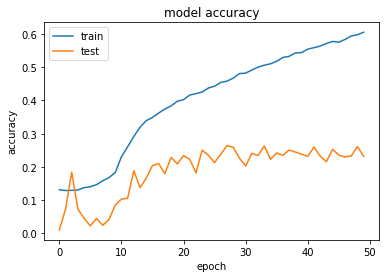

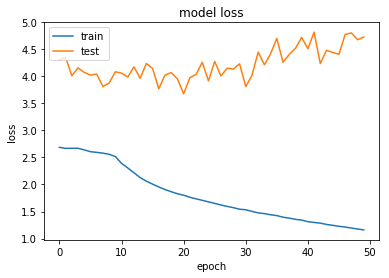

In [39]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
score = model.evaluate(test_data, test_target)

  32/4974 [..............................] - ETA: 0s

 416/4974 [=>............................] - ETA: 0s

 896/4974 [====>.........................] - ETA: 0s

1376/4974 [=======>......................] - ETA: 0s

1856/4974 [==========>...................] - ETA: 0s

2272/4974 [============>.................] - ETA: 0s

2624/4974 [==============>...............] - ETA: 0s

2880/4974 [================>.............] - ETA: 0s

3232/4974 [==================>...........] - ETA: 0s

3616/4974 [====================>.........] - ETA: 0s

3936/4974 [======================>.......] - ETA: 0s

4160/4974 [========================>.....] - ETA: 0s

4416/4974 [=========================>....] - ETA: 0s

4704/4974 [===========================>..] - ETA: 0s

4928/4974 [============================>.] - ETA: 0s

4974/4974 [==============================] - 1s 150us/step


In [41]:
test_y = model.predict(test_data)
test_y = np.argmax(test_y, axis=1)
test_t = np.argmax(test_target, axis=1)
print(test_t.shape, test_y.shape)
acc = evaluate_vec(test_y, test_t).tolist()

print(format(acc.count(1) / len(acc), '.6f'), format(np.mean(acc), '.6f'))

(4974,) (4974,)
0.223563 0.302734
